# ViEWS prediction competition 
## LSTM RNN Code and Results 

## Author: Iris Malone

# Load Packages

In [1]:
import tensorflow as tf
from tensorflow.python.keras.layers import LSTM
from tensorflow.python.keras.layers import Input, Dense, Dropout, RepeatVector, TimeDistributed, Activation, Bidirectional
from tensorflow.python.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

#plots
from plotnine import ggplot, aes
from plotnine import options
import plotnine as p9
from matplotlib import pyplot as plt

#random number generators since rnn is stochastic
from random import seed

In [2]:
import sys
import logging
import os
import pandas as pd
import numpy as np
import math
import csv
from datetime import datetime
from joblib import dump, load

# Import any other sklearn estimator you would like. 
# See https://scikit-learn.org/stable/user_guide.html#user-guide
#from sklearn.ensemble import RandomForestRegressor

from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler

#import views package

import views
from views import Period, Model, Downsampling
from views.utils.data import assign_into_df
from views.apps.transforms import lib as translib
from views.apps.evaluation import lib as evallib, feature_importance as fi
from views.apps.model import api
from views.apps.extras import extras


In [3]:

logging.basicConfig(
    #level=logging.DEBUG,
    level=logging.INFO, # uncomment this and comment debug above for less yelling in red
    format=views.config.LOGFMT,
)

In [4]:
# Do you wish to fetch the latest public data? If so, change False to True and run this cell
# Cells below will fail if this is not run if you haven't imported data yourself yet.
if False:
    path_zip = views.apps.data.public.fetch_latest_zip_from_website(path_dir_destination=views.DIR_SCRATCH)
    views.apps.data.public.import_tables_and_geoms(tables=views.TABLES, geometries=views.GEOMETRIES, path_zip=path_zip)

In [5]:
# Enter the level of analysis, and whether to predict Africa-only.
level = "cm"
pred_africa = True

In [6]:
model_path = "./models/{sub}"
out_paths = {
    "evaluation": model_path.format(sub="evaluation"),
    "features": model_path.format(sub="features")
}
for k, v in out_paths.items():
    if not os.path.isdir(v):
        os.makedirs(v)

In [7]:
if level == "pgm":
    dataset = views.DATASETS["pgm_africa_imp_0"]
elif level == "cm":
    dataset = views.DATASETS["cm_global_imp_0"]
df = dataset.df

In [8]:
df.reset_index(inplace=True)

# Clean Data

In [9]:
df["time"] = df["month_id"]
df["gwno"] = df["country_id"]

df = df.dropna(subset=['country_id'], how='all')
df = df.set_index(["month_id", "country_id"]).sort_index()

[2020-11-24 19:14:43,967] - numexpr.utils:141 - INFO - NumExpr defaulting to 8 threads.


In [10]:
df.head()

acled_count_ns  acled_count_os  acled_count_pr  \
month_id country_id                                                   
1        1                      0.0             0.0             0.0   
         2                      0.0             0.0             0.0   
         3                      0.0             0.0             0.0   
         4                      0.0             0.0             0.0   
         5                      0.0             0.0             0.0   

                     acled_count_sb  acled_dummy_ns  acled_dummy_os  \
month_id country_id                                                   
1        1                      0.0               0               0   
         2                      0.0               0               0   
         3                      0.0               0               0   
         4                      0.0               0               0   
         5                      0.0               0               0   

                     acled_dummy_pr  acled_dummy_sb  cdum_1  cdum_10  ...  \
month_id country_id                                                   ...   
1        1                        0               0       1        0  ...   
         2                        0               0       0        0  ...   
         3                        0               0       0        0  ...   
         4                        0               0       0        0  ...   
         5                        0               0       0        0  ...   

                     wdi_vc_idp_nwcv  wdi_vc_idp_nwds  wdi_vc_idp_tocv  \
month_id country_id                                                      
1        1              3.600000e+04            200.0          23000.0   
         2              2.667522e+05            300.0           2100.0   
         3              7.500000e+04             29.0         164000.0   
         4              1.672000e+06           4700.0         197000.0   
         5              1.500000e+02           5300.0           2100.0   

                     wdi_vc_ihr_psrc_fe_p5  wdi_vc_ihr_psrc_ma_p5  \
month_id country_id                                                 
1        1                             7.5                   30.3   
         2                             5.8                   11.9   
         3                             4.0                   36.6   
         4                             1.9                   22.9   
         5                             0.0                   10.0   

                     wdi_vc_ihr_psrc_p5  wdi_vc_pkp_totl_un  year  time  gwno  
month_id country_id                                                            
1        1                         12.1               141.0  1980     1     1  
         2                         14.4              9057.0  1980     1     2  
         3                          9.5               871.0  1980     1     3  
         4                         12.5              8536.0  1980     1     4  
         5                          8.7              1216.0  1980     1     5  

[5 rows x 3159 columns]

## Define Time Periods

In [11]:
# Define development period
# Keeping periods in a list lets us easily expand this as the 
# updated data becomes available
period_calib = {'train_start': 121,   # 1990-01
          'train_end': 408,     # 2013.12
          'predict_start': 409, # 2014.01
          'predict_end': 444}   # 2016.12

print(period_calib)

period_test = {'train_start': 121,   # 1990-01
          'train_end': 444,     # 2016.12
          'predict_start': 445, # 2017.01
          'predict_end': 480}   # 2019.12

print(period_test)

period_task1 = {'train_start': 121,   # 1990-01
          'train_end': 481,     # 2019.01
          'predict_start': 482, # 2020.02
          'predict_end': 488}   # 2020.08

print(period_task1)

periods = [period_calib, period_test, period_task1]


{'train_start': 121, 'train_end': 408, 'predict_start': 409, 'predict_end': 444}
{'train_start': 121, 'train_end': 444, 'predict_start': 445, 'predict_end': 480}
{'train_start': 121, 'train_end': 481, 'predict_start': 482, 'predict_end': 488}


## Write Model Functions

In [12]:
scaler = MinMaxScaler()

#create training and test based on period predictions

def partition_dataset(dataset, period, look_back):
    #create delta/first diff
    from views.apps.transforms import lib as translib
    dataset['s_outcome'] = translib.delta(dataset['ln_ged_best_sb'], time=1)

    train_df = dataset[dataset['time'].between(period['train_start'] , period['train_end']-look_back, inclusive=True)].dropna()
    test_df = dataset[dataset['time'].between(period['predict_start'] - look_back, period['predict_end'], inclusive=True)].dropna()
    #print(train_df)
    #print(test_df) 
    #identify outcome of interest
    train_df = train_df[['s_outcome']]
    test_df = test_df[['s_outcome']]   
    
    return np.array(train_df), np.array(test_df)

def partition_delta(countryname, period, dataset, look_back):

    #s_actual = df.loc[:, self.model.col_outcome].copy()

    #if self.model.delta_outcome:
    #    s_actual = translib.delta(s_actual, time=step)
    
    dataset['s_outcome1'] = translib.delta(dataset['ln_ged_best_sb'], time=1)
    dataset['s_outcome2'] = translib.delta(dataset['ln_ged_best_sb'], time=2)
    dataset['s_outcome3'] = translib.delta(dataset['ln_ged_best_sb'], time=3)
    dataset['s_outcome4'] = translib.delta(dataset['ln_ged_best_sb'], time=4)
    dataset['s_outcome5'] = translib.delta(dataset['ln_ged_best_sb'], time=5)
    dataset['s_outcome6'] = translib.delta(dataset['ln_ged_best_sb'], time=6)
    dataset['s_outcome7'] = translib.delta(dataset['ln_ged_best_sb'], time=7)
    #translib.delta(dataset['ln_ged_best_sb'], time=1)
    
    train_df = dataset[dataset['time'].between(period['train_start'] , period['train_end']-look_back)].dropna()
    test_df = dataset[dataset['time'].between(period['predict_start'] - look_back , period['predict_end'])].dropna()
     
    #identify outcome of interest
    train_df = train_df[['s_outcome1', 's_outcome2', 's_outcome3', 's_outcome4', 's_outcome5', 's_outcome6', 's_outcome7']]
    test_df = test_df[['s_outcome1', 's_outcome2', 's_outcome3', 's_outcome4', 's_outcome5', 's_outcome6', 's_outcome7']]

    return train_df, test_df
    
     
# split a univariate sequence into samples
def create_dataset(dataset, look_back, look_forward):
    X, y = list(), list()
    for i in range(len(dataset)):
        # find the end of this pattern
        end_ix = i + look_back
        out_end_ix = end_ix + look_forward
        # check if we are beyond the sequence
        if out_end_ix > len(dataset):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = dataset[i:end_ix], dataset[end_ix:out_end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)
 

#VANILLA LSTM
def create_vanilla_model(X_train, y_train, epochs, num_neurons, batch_size, val_split):
    """BUILDING THE MODEL""" 
    print('Building vanilla Model...')
    # simple early stopping
    es = EarlyStopping(monitor='loss', mode='min', verbose=1)

    model = Sequential()

    #Input Layers
    model.add(LSTM(units = num_neurons, input_shape = (X_train.shape[1], 1), activation="tanh"))

    # Dropout Regularization - randomly removes 20\%, helps with overfitting
    model.add(Dropout(0.2))
    
    #Hidden Layers
    
    model.add(Dense(num_neurons, activation="tanh")) # New hidden layer with 2 params, sigmoid function to constrainw weights
    
    model.add(Dropout(0.2))
              
    # Output Layers
    model.add(Dense(units = y_train.shape[1]))

    # Compiling the model
    model.compile(optimizer = 'adam', loss = 'mean_squared_error')

    #Summarize the model
    model.summary()

    # Fitting the model to the training set
    #remove callback, train for more epochs (passes through the data)
    model.fit(X_train, y_train, epochs = epochs, batch_size = batch_size, validation_split=val_split)

    return model

#STATEFUL LSTM


def create_stateful_model(X_train, y_train, epochs, num_neurons, batch_size, val_split):
    """BUILDING THE MODEL""" 
    print('Building stateful model...')
    # simple early stopping
    #es = EarlyStopping(monitor='loss', mode='min', verbose=1)

    model = Sequential()

    #Input Layers
    model.add(LSTM(units = num_neurons, batch_input_shape = (batch_size, X_train.shape[1], 1), activation="tanh",  stateful=True))
    model.add(Dense(num_neurons, activation="tanh"))

    # Dropout Regularization - randomly removes 20\%, helps with overfitting
    model.add(Dropout(0.2))

    
    #Hidden Layers
    
    model.add(Dense(num_neurons, activation="tanh")) # New hidden layer, tanh function to constrain weights
    model.add(Dropout(0.2))
    model.add(Dense(num_neurons, activation="tanh"))
              
    # Output Layers
    model.add(Dense(units = y_train.shape[1]))

    # Compiling the model
    model.compile(optimizer = 'adam', loss = 'mean_squared_error')

    #Summarize the model
    model.summary()

    # Fitting the model to the training set
    model.fit(X_train, y_train, epochs = epochs, batch_size = batch_size, validation_split=val_split)
    #remove callback, train for more epochs (passes through the data)
    #model.fit(X_train, y_train, epochs = epochs, batch_size = batch_size, validation_split=val_split)

    return model

#BIDIRECTIONAL LSTM
def create_bidirectional_model(X_train, y_train, epochs, num_neurons, batch_size, val_split):
    """BUILDING THE MODEL""" 
    print('Building bidirectional model...')
    # simple early stopping
    es = EarlyStopping(monitor='loss', mode='min', verbose=1)

    model = Sequential()

    #Input Layers
    #model.add(LSTM(units = num_neurons, input_shape = (X_train.shape[1], 1), activation = 'tanh'))
    model.add(Bidirectional(LSTM(num_neurons, return_sequences=True), input_shape = (X_train.shape[1], 1)))
    model.add(TimeDistributed(Dense(1, activation='tanh')))

    # Compiling the model
    model.compile(optimizer = 'adam', loss = 'mean_squared_error')

    #Summarize the model
    model.summary()

    # Fitting the model to the training set
    model.fit(X_train, y_train, epochs = epochs, batch_size = batch_size, callbacks=[es])
    
    return model


def make_forecasts(model, period, batch_size, X_train, y_train, test_df, X_test, y_test, look_back, look_forward):
    """FORECASTING""" 
    print('Forecasting...')
    forecasts = []
    futures = []

    for i in range(0, len(X_test)):
        X = X_test[i, 0:look_back]
        y = y_test[i, look_back:]  

        # forecast steps       
        forecast = forecast_lstm(model, X, look_back, batch_size)
        #print(forecast)
        # store the forecast
        forecasts.append(forecast)
    
    print(forecast[-1:])
    currentStep = forecast[-1:]
    #Make one-step predictions for data beyond test_set
    for i in range(look_forward):
        if i == 0:
            X = X.reshape(1, look_back, 1)
            yhat = forecast_lstm(model, X, look_back, batch_size)
            #print(yhat)
        else:
            x0_input = np.append(X, [currentStep[i-1]])
            x0_input = x0_input.reshape((1, look_back+1, 1))
            x_input = x0_input[:,1:]
            yhat = forecast_lstm(model, x_input, look_back, batch_size)
            currentStep = np.append(currentStep, yhat)        
        futures.append(yhat)
    #print(futures)
        
    return forecasts, futures

def forecast_lstm(model, X, look_back, batch_size): 
    #make predictions
    X = X.reshape(1, look_back, 1)
    
    testPredict = model.predict(X, batch_size)
    # convert to array
    return [x for x in testPredict[0, :]]

def eval_model(countryname, model, X_train, y_train, X_test, y_test, futures, forecasts, look_back, look_forward):
    """EVALUATING THE MODEL"""
    print('Evaluating...')
    testScore_values = []
    testScore_valuespercountry = []
    for i in range(look_forward):
        #print(type(y_test))
        s_actual = [row[i] for row in y_test]
        #print(s_actual)
        s_prediction = [forecast[i] for forecast in forecasts]
        #print(s_prediction)
        scores = {}
        scores["Country"] = countryname.ravel().tolist()[0]
        scores["Step"] = 't+%d' % ((i))
        scores["mse"] = evallib.mean_squared_error(actuals=s_actual, preds=s_prediction)
        scores["mae"] = evallib.mean_absolute_error(actuals=s_actual, preds=s_prediction)
        scores["r2"] = evallib.r2_score(actuals=s_actual, preds=s_prediction)
        scores["tadda_score"] = evallib.tadda_score(y_deltas=np.array(s_actual), f_deltas=np.array(s_prediction), epsilon=0.048)
        #print(scores)
        
        testScore_values.append(scores)
    testScore_valuespercountry.append(testScore_values)
    return testScore_valuespercountry


        
def plot_forecasts(period, test_df, y_test, forecasts, look_back, look_forward):
    print('Plotting forecasts...')
    """PLOTTING THE MODEL"""
    plt.plot(range(period['predict_start']- look_back, period['predict_start'] + len(test_df)- look_back), test_df, color='blue', label = 'Real Ln BD')
    # show the plot
    # plot the forecasts in red

    print(y_test.shape)
    for i in range(len(forecasts)):
        off_s = period['predict_start'] + i  
        off_e = off_s + len(forecasts[i]) 
        xaxis = [x for x in range(off_s, off_e)]
        yaxis = forecasts[i:][0]
        #print(xaxis)
        #print(yaxis)
        plt.plot(xaxis, yaxis, color='red')
    plt.title('Change in Ln Battle-Death Prediction')
    plt.xlabel('Time')
    plt.ylabel('Change in Ln Battle-Death')
    plt.legend()
    plt.show()
    
def store_forecasts(period, countryname, y_test, futures, forecasts, look_back, look_forward):
    print('Storing forecasts...')
    """STORING MODEL RESULTS"""
    storage =[]
    storagepredictions = []
    storagepredictionspercountry = []
    for i in range(len(forecasts)):
        off_s = period['predict_start'] + i 
        off_e = off_s + len(forecasts[i]) 
        #print(off_s)      
        xaxis = [x for x in range(off_s, off_e)]
        yaxis = forecasts[i:][0]

        storage = {}
        storage["Country"] = countryname.ravel().tolist()[0]
        storage["Last Month of Data"] = off_s - 1
        #storage["Future Months"] = xaxis
        storage["Malone_LSTM_s1"] = yaxis[0]
        storage["Malone_LSTM_s2"] = yaxis[0] + yaxis[1]
        storage["Malone_LSTM_s3"] = yaxis[0] + yaxis[1] + yaxis[2]
        storage["Malone_LSTM_s4"] = yaxis[0] + yaxis[1] + yaxis[2] + yaxis[3]
        storage["Malone_LSTM_s5"] = yaxis[0] + yaxis[1] + yaxis[2] + yaxis[3] + yaxis[4]
        storage["Malone_LSTM_s6"] = yaxis[0] + yaxis[1] + yaxis[2] + yaxis[3] + yaxis[4] + yaxis[5]
        storage["Malone_LSTM_s7"] = yaxis[0] + yaxis[1] + yaxis[2] + yaxis[3] + yaxis[4] + yaxis[5] + yaxis[6]
        storagepredictions.append(storage)
    #print(storagepredictionspercountry)
    for i in range(len(futures)):
        off_s = period['predict_end'] + i - look_forward + 1   
        off_e = off_s + len(futures[i]) 
        #print(off_s)
        
        xaxis = [x for x in range(off_s +1, off_e)]
        yaxis = futures[i:][0]
        #print(countryname)
        #print(xaxis)
        #print(yaxis)
        storage = {}
        storage["Country"] = countryname.ravel().tolist()[0]
        storage["Last Month of Data"] = off_s 
        #storage["Future Months"] = xaxis
        storage["Malone_LSTM_s1"] = yaxis[0]
        storage["Malone_LSTM_s2"] = yaxis[0] + yaxis[1]
        storage["Malone_LSTM_s3"] = yaxis[0] + yaxis[1] + yaxis[2]
        storage["Malone_LSTM_s4"] = yaxis[0] + yaxis[1] + yaxis[2] + yaxis[3]
        storage["Malone_LSTM_s5"] = yaxis[0] + yaxis[1] + yaxis[2] + yaxis[3] + yaxis[4]
        storage["Malone_LSTM_s6"] = yaxis[0] + yaxis[1] + yaxis[2] + yaxis[3] + yaxis[4] + yaxis[5]
        storage["Malone_LSTM_s7"] = yaxis[0] + yaxis[1] + yaxis[2] + yaxis[3] + yaxis[4] + yaxis[5] + yaxis[6]
       #print(storage)
        storagepredictions.append(storage)
    storagepredictionspercountry.append(storagepredictions)
    #print(storagepredictionspercountry)
    return storagepredictionspercountry



def store_forecasts(period, countryname, gwno, train_step, test_step, y_test, futures, forecasts, look_back, look_forward):
    print('Storing forecasts...')
    """STORING MODEL RESULTS"""
    storage =[]
    storagepredictions = []
    storagepredictionspercountry = []
    for i in range(len(forecasts)):
        off_s = period['predict_start'] + i 
        off_e = off_s + len(forecasts[i]) 
        #print(off_s)      
        xaxis = [x for x in range(off_s, off_e)]
        yaxis = forecasts[i:][0]

        storage = {}
        storage["Country"] = countryname.ravel().tolist()[0]
        storage["country_id"] = gwno.ravel().tolist()[0]
        storage["Last Month of Data"] = off_s 
        #storage["Future Months"] = xaxis
        storage["Malone_LSTM_s1"] = yaxis[0]
        storage["Malone_LSTM_s2"] = yaxis[0] + yaxis[1]
        storage["Malone_LSTM_s3"] = yaxis[0] + yaxis[1] + yaxis[2]
        storage["Malone_LSTM_s4"] = yaxis[0] + yaxis[1] + yaxis[2] + yaxis[3]
        storage["Malone_LSTM_s5"] = yaxis[0] + yaxis[1] + yaxis[2] + yaxis[3] + yaxis[4]
        storage["Malone_LSTM_s6"] = yaxis[0] + yaxis[1] + yaxis[2] + yaxis[3] + yaxis[4] + yaxis[5]
        storage["Malone_LSTM_s7"] = yaxis[0] + yaxis[1] + yaxis[2] + yaxis[3] + yaxis[4] + yaxis[5] + yaxis[6]
        storagepredictions.append(storage)
    #storagepredictionspercountry.append(storagepredictions)
    #print(storagepredictionspercountry)
    for i in range(1, len(futures)):
        off_s = period['predict_end'] + i - look_forward + 1   
        off_e = off_s + len(futures[i]) 
        #print(off_s)
        
        xaxis = [x for x in range(off_s +1, off_e)]
        yaxis = futures[i:][0]
        #print(countryname)
        #print(xaxis)
        #print(yaxis)
        storage = {}
        storage["Country"] = countryname.ravel().tolist()[0]
        storage["country_id"] = gwno.ravel().tolist()[0]
        storage["Last Month of Data"] = off_s 
        #storage["Future Months"] = xaxis
        storage["Malone_LSTM_s1"] = yaxis[0]
        storage["Malone_LSTM_s2"] = yaxis[0] + yaxis[1]
        storage["Malone_LSTM_s3"] = yaxis[0] + yaxis[1] + yaxis[2]
        storage["Malone_LSTM_s4"] = yaxis[0] + yaxis[1] + yaxis[2] + yaxis[3]
        storage["Malone_LSTM_s5"] = yaxis[0] + yaxis[1] + yaxis[2] + yaxis[3] + yaxis[4]
        storage["Malone_LSTM_s6"] = yaxis[0] + yaxis[1] + yaxis[2] + yaxis[3] + yaxis[4] + yaxis[5]
        storage["Malone_LSTM_s7"] = yaxis[0] + yaxis[1] + yaxis[2] + yaxis[3] + yaxis[4] + yaxis[5] + yaxis[6]
        #print(storage)
        storagepredictions.append(storage)

    storagepredictionspercountry.append(storagepredictions)
    
    return storagepredictionspercountry

def export_results(modelname, period, batch_size, epochs, num_neurons, look_back, look_forward, scoresglobal, storagepredictionsglobal, scoresdeltaglobal):
    print('Exporting results...')
    #Write Tables
    if period == period_calib:
        period_print = 'calibration'
    elif period == period_test:
        period_print = 'test'
    #Write .csv file with evaluation metrics, one per country-step
    flattenscores_list = [item for sublist in scoresglobal for item in sublist]
    
    flattenscores_list_final = [item for sublist in flattenscores_list for item in sublist]
    keys = flattenscores_list_final[0].keys()
    with open('country.csv', 'w') as output_file:
        dict_writer = csv.DictWriter(output_file, keys)
        dict_writer.writeheader()
        dict_writer.writerows(flattenscores_list_final)
    
    path_out = os.path.join(
        out_paths["evaluation"], 
        f"{modelname}_{period_print}_epochs{epochs}_batchsize{batch_size}_neurons{num_neurons}_lookback{look_back}_countryscores.csv"
        )
    with open(path_out, "w") as f:
        dict_writer = csv.DictWriter(f, keys)
        dict_writer.writeheader()
        dict_writer.writerows(flattenscores_list_final)
    print(f"Wrote country-level error tables to {path_out}.")
 
    #Write .csv file with evaluation metrics, one per country-step
    flattenscores_listdelta = [item for sublist in scoresdeltaglobal for item in sublist]
    
    flattenscores_list_final = [item for sublist in flattenscores_listdelta for item in sublist]
    keys = flattenscores_list_final[0].keys()
    with open('country.csv', 'w') as output_file:
        dict_writer = csv.DictWriter(output_file, keys)
        dict_writer.writeheader()
        dict_writer.writerows(flattenscores_list_final)
    
    path_out = os.path.join(
        out_paths["evaluation"], 
        f"{modelname}_{period_print}_epochs{epochs}_batchsize{batch_size}_neurons{num_neurons}_lookback{look_back}_countryscores_delta.csv"
        )
    with open(path_out, "w") as f:
        dict_writer = csv.DictWriter(f, keys)
        dict_writer.writeheader()
        dict_writer.writerows(flattenscores_list_final)
    print(f"Wrote country-level delta error tables to {path_out}.")
    
    #write country predictions
    flattenstorage_list = [item for sublist in storagepredictionsglobal for item in sublist]
    flattenstorage_list_final = [item for sublist in flattenstorage_list for item in sublist]
    keys = flattenstorage_list_final[0].keys()
    with open('country.csv', 'w') as output_file:
        dict_writer = csv.DictWriter(output_file, keys)
        dict_writer.writeheader()
        dict_writer.writerows(flattenstorage_list_final)
   
    path_out = os.path.join(
        out_paths["evaluation"], 
        f"predictions_{modelname}_{period_print}_epochs{epochs}_batchsize{batch_size}_neurons{num_neurons}_lookback{look_back}_countryscores.csv"
        )
    with open(path_out, "w") as f:
        dict_writer = csv.DictWriter(f, keys)
        dict_writer.writeheader()
        dict_writer.writerows(flattenstorage_list_final)
    print(f"Wrote country-level prediction tables to {path_out}.")

    #Write .tex file with evaluation metrics, averaged over countries    
    mselist = []
    mse2 = []
    scores2 = []
    sumscores = []
    scores = {
            "Step":[], 
            "MSE":[], 
            "MAE":[],
            "R2":[],
            "tadda_score":[]
        }
    
    for i in range(look_forward):
        evalmetrics = [a[i] for a in flattenscores_listdelta]
        mse = [d['mse'] for d in evalmetrics]
        mae = [d['mae'] for d in evalmetrics]
        r2 = [d['r2'] for d in evalmetrics]
        tadda = [d['tadda_score'] for d in evalmetrics]

        scores["Step"].append('t+%d' % ((i)))
        scores["MSE"].append(np.mean(mse))
        scores["MAE"].append(np.mean(mae))
        scores["R2"].append(np.mean(r2))
        scores["tadda_score"].append(np.mean(tadda))
        #print(scores)
        scores_summary = scores
        #print(scores2)
        
    out = pd.DataFrame([v for v in scores_summary.values()],
                    index = [k for k in scores_summary.keys()])
    #print(out)
    out_transpose = out.T
    tex = out_transpose.to_latex(index=False)
    
    now = datetime.now().strftime("%Y/%m/%d %H:%M:%S")
    meta = f"""
        %Output created by LSTM Multi-Step.ipynb.
        %Produced on {now}, written to {out_paths["evaluation"]}.
        \\
        """
    tex = meta + tex
    path_out = os.path.join(
        out_paths["evaluation"], 
        f"{modelname}_{period_print}_epochs{epochs}_batchsize{batch_size}_neurons{num_neurons}_lookback{look_back}_delta_scores.tex"
        )
    with open(path_out, "w") as f:
        f.write(tex)
    print(f"Wrote scores table to {path_out}.")
#Write .tex file with evaluation metrics, averaged over countries    
    mselist = []
    mse2 = []
    scores2 = []
    sumscores = []
    scores = {
            "Step":[], 
            "MSE":[], 
            "MAE":[],
            "R2":[],
            "tadda_score":[]
        }
    
    for i in range(look_forward):
        evalmetrics = [a[i] for a in flattenscores_list]
        mse = [d['mse'] for d in evalmetrics]
        mae = [d['mae'] for d in evalmetrics]
        r2 = [d['r2'] for d in evalmetrics]
        tadda = [d['tadda_score'] for d in evalmetrics]

        scores["Step"].append('t+%d' % ((i)))
        scores["MSE"].append(np.mean(mse))
        scores["MAE"].append(np.mean(mae))
        scores["R2"].append(np.mean(r2))
        scores["tadda_score"].append(np.mean(tadda))
        #print(scores)
        scores_summary = scores
        #print(scores2)
        
    out = pd.DataFrame([v for v in scores_summary.values()],
                    index = [k for k in scores_summary.keys()])
    #print(out)
    out_transpose = out.T
    tex = out_transpose.to_latex(index=False)
    
    now = datetime.now().strftime("%Y/%m/%d %H:%M:%S")
    meta = f"""
        %Output created by LSTM Multi-Step.ipynb.
        %Produced on {now}, written to {out_paths["evaluation"]}.
        \\
        """
    tex = meta + tex
    path_out = os.path.join(
        out_paths["evaluation"], 
        f"{modelname}_{period_print}_epochs{epochs}_batchsize{batch_size}_neurons{num_neurons}_lookback{look_back}_scores.tex"
        )
    with open(path_out, "w") as f:
        f.write(tex)
    print(f"Wrote scores table to {path_out}.")

def eval_delta_forecasts(period, countryname, gwno, train_step, test_step, y_test, futures, forecasts, look_back, look_forward):
    print('Evaluating delta multi-step forecasts...')
    storage_pred2 = []
    storage_actual2 = []
    testScore_values = []
    testScore_valuespercountry = []
    for i in range(len(forecasts)):
        
        yaxis = forecasts[i:][0]  
        storage_pred = (yaxis[0], yaxis[0] + yaxis[1], yaxis[0] + yaxis[1] + yaxis[2] ,yaxis[0] + yaxis[1] + yaxis[2] + yaxis[3],yaxis[0] + yaxis[2] + yaxis[3] + yaxis[4], yaxis[0] + yaxis[2] + yaxis[3] + yaxis[4] + yaxis[5], yaxis[0] + yaxis[2] + yaxis[3] +yaxis[4] + yaxis[5] + yaxis[6]) 
        storage_pred = list(storage_pred)
        storage_pred2.append(storage_pred)

    for index, row in test_step.iterrows(): 
        #yaxis = test_step[i:, 0]
        #print(yaxis)
        storage_actual = (row.loc['s_outcome1'], row.loc['s_outcome2'], row.loc['s_outcome3'], row.loc['s_outcome4'], row.loc['s_outcome5'], row.loc['s_outcome6'], row.loc['s_outcome7'])
        storage_actual = list(storage_actual)
        storage_actual2.append(storage_actual)
        #print(storage_actual2)
        
    for i in range(look_forward):
        s_actual = [item[i] for item in storage_actual2]
        s_prediction = [item[i] for item in storage_pred2]
        
        scores = {}
        scores["country"] = countryname.ravel().tolist()[0]
        scores["country_id"] = gwno.ravel().tolist()[0]
        scores["step"] = 't+%d' % ((i))
        scores["mse"] = evallib.mean_squared_error(actuals=s_actual, preds=s_prediction)
        scores["mae"] = evallib.mean_absolute_error(actuals=s_actual, preds=s_prediction)
        scores["r2"] = evallib.r2_score(actuals=s_actual, preds=s_prediction)
        scores["tadda_score"] = evallib.tadda_score(y_deltas=np.array(s_actual), f_deltas=np.array(s_prediction), epsilon=0.048)
        print(scores)
        # calculate root mean squared error for scaled data
        
        testScore_values.append(scores)
    testScore_valuespercountry.append(testScore_values)
    return testScore_valuespercountry


In [13]:
#list to store country-specific MSE

def summary_model(dataset, modelname, pred_africa, period, epochs, batch_size, look_back, look_forward, num_neurons, val_split):
    
    if pred_africa == False:
        dataset = dataset
    elif pred_africa == True:
        dataset = dataset[(dataset.in_africa==1)]

    if period == period_calib:
        period_print = 'calibration'
    elif period == period_test:
        period_print = 'test'
    elif period == period_task1:
        period_print = 'task1'    
    #create unique list of names
    gwnonames = dataset.gwno.unique()
    
    #create a data frame dictionary to store data frame for each unique country
    gwno_dict = {elem : pd.DataFrame for elem in gwnonames}

    for key in gwno_dict.keys():
        gwno_dict[key] = dataset[:][dataset.gwno == key]
    
    #model needs to be global
    forecasts = []
    predictions = []
    forecastsglobal = []
    storagepredictionsglobal = []
    scoresglobal = []
    
    scores = []
    scoresdelta = []
    scoresdeltaglobal = []
    futures = []
    storage = []
    for key in gwno_dict:
    #for key in range(53, 57):
        forecasts = []
        dfgwno = pd.DataFrame(gwno_dict[key])
        dfgwno = dfgwno[['gwno','time','ln_ged_best_sb','country_name']]
        countryname = dfgwno.country_name.unique()
        gwno = dfgwno.gwno.unique()

        print(countryname)
        
        train_df, test_df = partition_dataset(dfgwno, period, look_back)
        
        train_step, test_step = partition_delta(countryname, period, dfgwno, look_back)        
        
        test_step = test_step.iloc[look_back: -look_forward+1]
        X_train, y_train = create_dataset(train_df, look_back, look_forward)
    
        # reshape it [samples, time steps, features]
        X_train = np.reshape(X_train, (X_train.shape[0], look_back, 1))
    
        # Create the data to test our model on:
        X_test, y_test = create_dataset(test_df, look_back, look_forward)
        
        # LSTM input shape: (samples, time steps, features)
        X_test = np.reshape(X_test, (X_test.shape[0], look_back, 1))
    
        #Create the model to predict:
        if modelname == "Vanilla":
            model = create_vanilla_model(X_train, y_train, epochs, num_neurons, batch_size, val_split)
        elif modelname == "Stateful":
            model = create_stateful_model(X_train, y_train, epochs, num_neurons, batch_size, val_split)
        elif modelname == "Bidirectional":
            model = create_bidirectional_model(X_train, y_train, epochs, num_neurons, batch_size, val_split)
        elif modelname == "Stacked":
            model = create_stacked_model(X_train, y_train, epochs, num_neurons, batch_size, val_split)
        
        #Make Multi-Step Predictions for Test Data 
        forecasts, futures = make_forecasts(model, period, batch_size, X_train, y_train, test_df, X_test, y_test, look_back, look_forward)

        forecastsglobal.append(forecasts)
        
        #Evaluate out-of-sample forecasting by different metrics
        scores = eval_model(countryname,model, X_train, y_train, X_test, y_test, futures, forecasts, look_back, look_forward)
        
        # plot the forecasts in red
        plot_forecasts(period, test_df, y_test, forecasts, look_back, look_forward)
        scoresglobal.append(scores)

        # Store the Predictions for Write-Out
        storage = store_forecasts(period, countryname, gwno, train_step, test_step, y_test, futures, forecasts, look_back, look_forward)
    
        storagepredictionsglobal.append(storage)
        scoresdelta = eval_delta_forecasts(period, countryname, gwno, train_step, test_step, y_test, futures, forecasts, look_back, look_forward)
        scoresdeltaglobal.append(scoresdelta)
    export_results(modelname, period, batch_size, epochs, num_neurons, look_back, look_forward, scoresglobal, storagepredictionsglobal, scoresdeltaglobal)
    

# MODEL EVALUATION AND FORECASTS

# Calibration Period

['Cape Verde']
Building vanilla Model...
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 2)                 32        
_________________________________________________________________
dropout (Dropout)            (None, 2)                 0         
_________________________________________________________________
dense (Dense)                (None, 2)                 6         
_________________________________________________________________
dropout_1 (Dropout)          (None, 2)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 7)                 21        
Total params: 59
Trainable params: 59
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
4/4 [==============================] - 0s 69ms/step - loss: 0.0000e+00 -

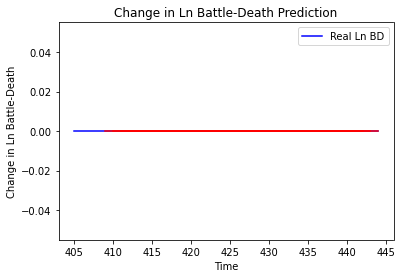

Storing forecasts...
Evaluating delta multi-step forecasts...
{'country': 'Cape Verde', 'country_id': 40, 'step': 't+0', 'mse': 0.0, 'mae': 0.0, 'r2': 1.0, 'tadda_score': 0.0}
{'country': 'Cape Verde', 'country_id': 40, 'step': 't+1', 'mse': 0.0, 'mae': 0.0, 'r2': 1.0, 'tadda_score': 0.0}
{'country': 'Cape Verde', 'country_id': 40, 'step': 't+2', 'mse': 0.0, 'mae': 0.0, 'r2': 1.0, 'tadda_score': 0.0}
{'country': 'Cape Verde', 'country_id': 40, 'step': 't+3', 'mse': 0.0, 'mae': 0.0, 'r2': 1.0, 'tadda_score': 0.0}
{'country': 'Cape Verde', 'country_id': 40, 'step': 't+4', 'mse': 0.0, 'mae': 0.0, 'r2': 1.0, 'tadda_score': 0.0}
{'country': 'Cape Verde', 'country_id': 40, 'step': 't+5', 'mse': 0.0, 'mae': 0.0, 'r2': 1.0, 'tadda_score': 0.0}
{'country': 'Cape Verde', 'country_id': 40, 'step': 't+6', 'mse': 0.0, 'mae': 0.0, 'r2': 1.0, 'tadda_score': 0.0}
["Cote d'Ivoire"]
Building vanilla Model...
Model: "sequential_2"
_________________________________________________________________
Layer (t

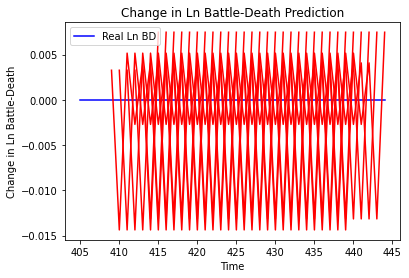

Storing forecasts...
Evaluating delta multi-step forecasts...
{'country': "Cote d'Ivoire", 'country_id': 41, 'step': 't+0', 'mse': 1.0697077119806034e-05, 'mae': 0.0032706386409699917, 'r2': 0.0, 'tadda_score': 0.0032706386409699917}
{'country': "Cote d'Ivoire", 'country_id': 41, 'step': 't+1', 'mse': 0.00012343707354706135, 'mae': 0.011110223829746246, 'r2': 0.0, 'tadda_score': 0.011110223829746246}
{'country': "Cote d'Ivoire", 'country_id': 41, 'step': 't+2', 'mse': 3.537534858818526e-05, 'mae': 0.005947717931121588, 'r2': 0.0, 'tadda_score': 0.005947717931121588}
{'country': "Cote d'Ivoire", 'country_id': 41, 'step': 't+3', 'mse': 7.501492243281241e-05, 'mae': 0.008661115542054176, 'r2': 0.0, 'tadda_score': 0.008661115542054176}
{'country': "Cote d'Ivoire", 'country_id': 41, 'step': 't+4', 'mse': 9.606921077482192e-05, 'mae': 0.009801490232348442, 'r2': 0.0, 'tadda_score': 0.009801490232348442}
{'country': "Cote d'Ivoire", 'country_id': 41, 'step': 't+5', 'mse': 1.1306112615658975e-

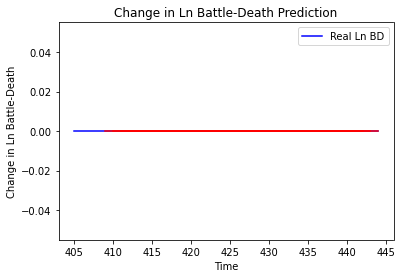

Storing forecasts...
Evaluating delta multi-step forecasts...
{'country': 'Ghana', 'country_id': 42, 'step': 't+0', 'mse': 0.0, 'mae': 0.0, 'r2': 1.0, 'tadda_score': 0.0}
{'country': 'Ghana', 'country_id': 42, 'step': 't+1', 'mse': 0.0, 'mae': 0.0, 'r2': 1.0, 'tadda_score': 0.0}
{'country': 'Ghana', 'country_id': 42, 'step': 't+2', 'mse': 0.0, 'mae': 0.0, 'r2': 1.0, 'tadda_score': 0.0}
{'country': 'Ghana', 'country_id': 42, 'step': 't+3', 'mse': 0.0, 'mae': 0.0, 'r2': 1.0, 'tadda_score': 0.0}
{'country': 'Ghana', 'country_id': 42, 'step': 't+4', 'mse': 0.0, 'mae': 0.0, 'r2': 1.0, 'tadda_score': 0.0}
{'country': 'Ghana', 'country_id': 42, 'step': 't+5', 'mse': 0.0, 'mae': 0.0, 'r2': 1.0, 'tadda_score': 0.0}
{'country': 'Ghana', 'country_id': 42, 'step': 't+6', 'mse': 0.0, 'mae': 0.0, 'r2': 1.0, 'tadda_score': 0.0}
['Liberia']
Building vanilla Model...
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape        

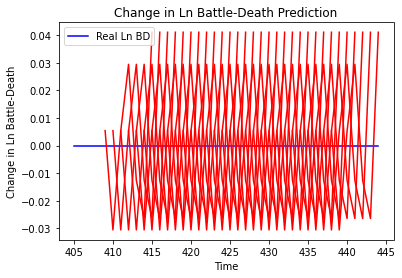

Storing forecasts...
Evaluating delta multi-step forecasts...
{'country': 'Liberia', 'country_id': 43, 'step': 't+0', 'mse': 2.9369205492069117e-05, 'mae': 0.005419336259365082, 'r2': 0.0, 'tadda_score': 0.005419336259365082}
{'country': 'Liberia', 'country_id': 43, 'step': 't+1', 'mse': 0.0006304039138884665, 'mae': 0.025107845664024353, 'r2': 0.0, 'tadda_score': 0.025107845664024353}
{'country': 'Liberia', 'country_id': 43, 'step': 't+2', 'mse': 0.000394252168273327, 'mae': 0.019855784252285957, 'r2': 0.0, 'tadda_score': 0.019855784252285957}
{'country': 'Liberia', 'country_id': 43, 'step': 't+3', 'mse': 9.138477089166985e-05, 'mae': 0.009559538215398788, 'r2': 0.0, 'tadda_score': 0.009559538215398788}
{'country': 'Liberia', 'country_id': 43, 'step': 't+4', 'mse': 0.000755998918768739, 'mae': 0.027495434507727623, 'r2': 0.0, 'tadda_score': 0.027495434507727623}
{'country': 'Liberia', 'country_id': 43, 'step': 't+5', 'mse': 1.2262075035907039e-06, 'mae': 0.001107342541217804, 'r2': 0.

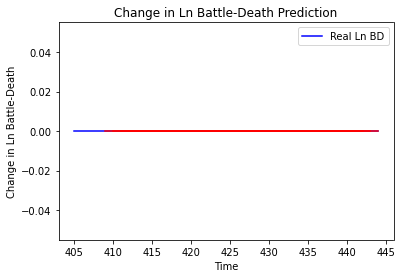

Storing forecasts...
Evaluating delta multi-step forecasts...
{'country': 'Burkina Faso', 'country_id': 47, 'step': 't+0', 'mse': 0.0, 'mae': 0.0, 'r2': 1.0, 'tadda_score': 0.0}
{'country': 'Burkina Faso', 'country_id': 47, 'step': 't+1', 'mse': 0.0, 'mae': 0.0, 'r2': 1.0, 'tadda_score': 0.0}
{'country': 'Burkina Faso', 'country_id': 47, 'step': 't+2', 'mse': 0.0, 'mae': 0.0, 'r2': 1.0, 'tadda_score': 0.0}
{'country': 'Burkina Faso', 'country_id': 47, 'step': 't+3', 'mse': 0.0, 'mae': 0.0, 'r2': 1.0, 'tadda_score': 0.0}
{'country': 'Burkina Faso', 'country_id': 47, 'step': 't+4', 'mse': 0.0, 'mae': 0.0, 'r2': 1.0, 'tadda_score': 0.0}
{'country': 'Burkina Faso', 'country_id': 47, 'step': 't+5', 'mse': 0.0, 'mae': 0.0, 'r2': 1.0, 'tadda_score': 0.0}
{'country': 'Burkina Faso', 'country_id': 47, 'step': 't+6', 'mse': 0.0, 'mae': 0.0, 'r2': 1.0, 'tadda_score': 0.0}
['Guinea']
Building vanilla Model...
Model: "sequential_6"
_________________________________________________________________
L

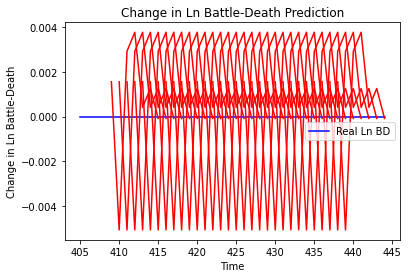

Storing forecasts...
Evaluating delta multi-step forecasts...
{'country': 'Guinea', 'country_id': 48, 'step': 't+0', 'mse': 2.42732406342816e-06, 'mae': 0.0015579871833324432, 'r2': 0.0, 'tadda_score': 0.0015579871833324432}
{'country': 'Guinea', 'country_id': 48, 'step': 't+1', 'mse': 1.237038306103281e-05, 'mae': 0.003517155535519123, 'r2': 0.0, 'tadda_score': 0.003517155535519123}
{'country': 'Guinea', 'country_id': 48, 'step': 't+2', 'mse': 3.530026524436688e-07, 'mae': 0.000594140263274312, 'r2': 0.0, 'tadda_score': 0.000594140263274312}
{'country': 'Guinea', 'country_id': 48, 'step': 't+3', 'mse': 1.0114741282980669e-05, 'mae': 0.0031803681049495935, 'r2': 0.0, 'tadda_score': 0.0031803681049495935}
{'country': 'Guinea', 'country_id': 48, 'step': 't+4', 'mse': 7.511646299490984e-05, 'mae': 0.008666975423693657, 'r2': 0.0, 'tadda_score': 0.008666975423693657}
{'country': 'Guinea', 'country_id': 48, 'step': 't+5', 'mse': 9.844287980364467e-05, 'mae': 0.009921838529407978, 'r2': 0.0,

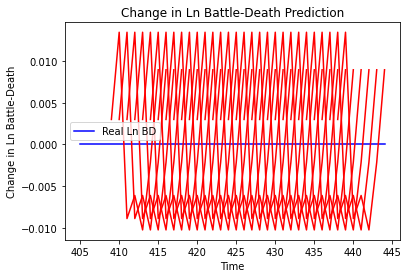

Storing forecasts...
Evaluating delta multi-step forecasts...
{'country': 'Guinea-Bissau', 'country_id': 49, 'step': 't+0', 'mse': 8.985396428053995e-06, 'mae': 0.0029975650832057, 'r2': 0.0, 'tadda_score': 0.0029975650832057}
{'country': 'Guinea-Bissau', 'country_id': 49, 'step': 't+1', 'mse': 0.00027064389676868805, 'mae': 0.016451258212327957, 'r2': 0.0, 'tadda_score': 0.016451258212327957}
{'country': 'Guinea-Bissau', 'country_id': 49, 'step': 't+2', 'mse': 5.7300788340212266e-05, 'mae': 0.007569728419184685, 'r2': 0.0, 'tadda_score': 0.007569728419184685}
{'country': 'Guinea-Bissau', 'country_id': 49, 'step': 't+3', 'mse': 2.115201858511476e-06, 'mae': 0.0014543733559548855, 'r2': 0.0, 'tadda_score': 0.0014543733559548855}
{'country': 'Guinea-Bissau', 'country_id': 49, 'step': 't+4', 'mse': 0.0004948052672144737, 'mae': 0.022244218736886978, 'r2': 0.0, 'tadda_score': 0.022244218736886978}
{'country': 'Guinea-Bissau', 'country_id': 49, 'step': 't+5', 'mse': 0.000594367703788682, 'm

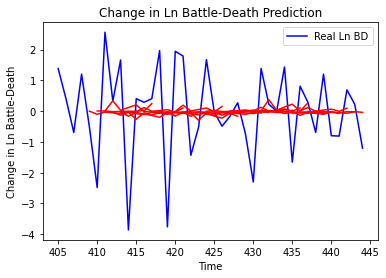

Storing forecasts...
Evaluating delta multi-step forecasts...
{'country': 'Mali', 'country_id': 50, 'step': 't+0', 'mse': 2.5098201799294264, 'mae': 1.2039506489854503, 'r2': 0.0027115693620451964, 'tadda_score': 1.2116917154419122}
{'country': 'Mali', 'country_id': 50, 'step': 't+1', 'mse': 3.275562515858117, 'mae': 1.4654251253501962, 'r2': -0.07445645819786995, 'tadda_score': 1.5549911203753342}
{'country': 'Mali', 'country_id': 50, 'step': 't+2', 'mse': 2.8429629767466134, 'mae': 1.2695215845120447, 'r2': -0.10121586593077869, 'tadda_score': 1.3646801525056358}
{'country': 'Mali', 'country_id': 50, 'step': 't+3', 'mse': 2.6539616623798272, 'mae': 1.332995152187867, 'r2': -0.07520681074739155, 'tadda_score': 1.4354307875130554}
{'country': 'Mali', 'country_id': 50, 'step': 't+4', 'mse': 2.4476810298818763, 'mae': 1.3377695153674236, 'r2': -0.060826071830077266, 'tadda_score': 1.4365400180737924}
{'country': 'Mali', 'country_id': 50, 'step': 't+5', 'mse': 3.4005337894624055, 'mae': 1

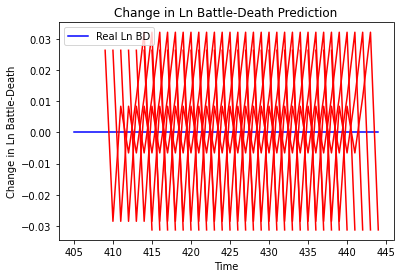

Storing forecasts...
Evaluating delta multi-step forecasts...
{'country': 'Senegal', 'country_id': 52, 'step': 't+0', 'mse': 0.0006982218718861212, 'mae': 0.02642388828098774, 'r2': 0.0, 'tadda_score': 0.02642388828098774}
{'country': 'Senegal', 'country_id': 52, 'step': 't+1', 'mse': 4.515508726987694e-06, 'mae': 0.002124972641468048, 'r2': 0.0, 'tadda_score': 0.002124972641468048}
{'country': 'Senegal', 'country_id': 52, 'step': 't+2', 'mse': 3.9728458042873754e-05, 'mae': 0.006303051486611366, 'r2': 0.0, 'tadda_score': 0.006303051486611366}
{'country': 'Senegal', 'country_id': 52, 'step': 't+3', 'mse': 6.882890663754276e-08, 'mae': 0.0002623526379466057, 'r2': 0.0, 'tadda_score': 0.0002623526379466057}
{'country': 'Senegal', 'country_id': 52, 'step': 't+4', 'mse': 0.0015620809192873342, 'mae': 0.0395231693983078, 'r2': 0.0, 'tadda_score': 0.0395231693983078}
{'country': 'Senegal', 'country_id': 52, 'step': 't+5', 'mse': 0.005147138805759122, 'mae': 0.07174356281757355, 'r2': 0.0, 't

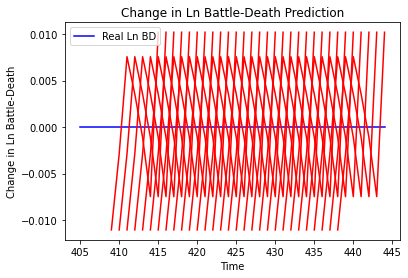

Storing forecasts...
Evaluating delta multi-step forecasts...
{'country': 'Sierra Leone', 'country_id': 53, 'step': 't+0', 'mse': 0.00012211503170456162, 'mae': 0.011050567030906677, 'r2': 0.0, 'tadda_score': 0.011050567030906677}
{'country': 'Sierra Leone', 'country_id': 53, 'step': 't+1', 'mse': 0.00019413225640580248, 'mae': 0.013933135196566582, 'r2': 0.0, 'tadda_score': 0.013933135196566582}
{'country': 'Sierra Leone', 'country_id': 53, 'step': 't+2', 'mse': 4.055324550197013e-05, 'mae': 0.006368143018335104, 'r2': 0.0, 'tadda_score': 0.006368143018335104}
{'country': 'Sierra Leone', 'country_id': 53, 'step': 't+3', 'mse': 7.961355973772283e-06, 'mae': 0.0028215874917805195, 'r2': 0.0, 'tadda_score': 0.0028215874917805195}
{'country': 'Sierra Leone', 'country_id': 53, 'step': 't+4', 'mse': 1.098191893478262e-06, 'mae': 0.0010479465126991272, 'r2': 0.0, 'tadda_score': 0.0010479465126991272}
{'country': 'Sierra Leone', 'country_id': 53, 'step': 't+5', 'mse': 7.262053435337038e-05, '

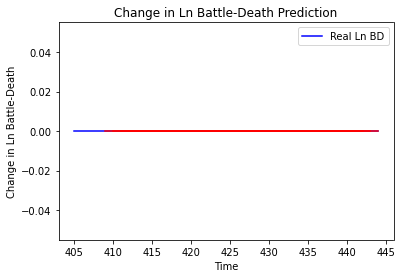

Storing forecasts...
Evaluating delta multi-step forecasts...
{'country': 'The Gambia', 'country_id': 54, 'step': 't+0', 'mse': 0.0, 'mae': 0.0, 'r2': 1.0, 'tadda_score': 0.0}
{'country': 'The Gambia', 'country_id': 54, 'step': 't+1', 'mse': 0.0, 'mae': 0.0, 'r2': 1.0, 'tadda_score': 0.0}
{'country': 'The Gambia', 'country_id': 54, 'step': 't+2', 'mse': 0.0, 'mae': 0.0, 'r2': 1.0, 'tadda_score': 0.0}
{'country': 'The Gambia', 'country_id': 54, 'step': 't+3', 'mse': 0.0, 'mae': 0.0, 'r2': 1.0, 'tadda_score': 0.0}
{'country': 'The Gambia', 'country_id': 54, 'step': 't+4', 'mse': 0.0, 'mae': 0.0, 'r2': 1.0, 'tadda_score': 0.0}
{'country': 'The Gambia', 'country_id': 54, 'step': 't+5', 'mse': 0.0, 'mae': 0.0, 'r2': 1.0, 'tadda_score': 0.0}
{'country': 'The Gambia', 'country_id': 54, 'step': 't+6', 'mse': 0.0, 'mae': 0.0, 'r2': 1.0, 'tadda_score': 0.0}
['Djibouti']
Building vanilla Model...
Model: "sequential_12"
_________________________________________________________________
Layer (type)

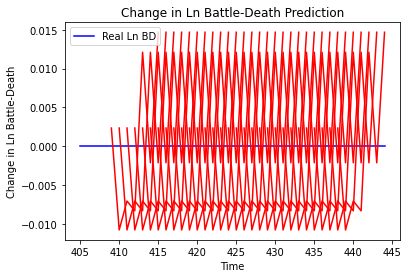

Storing forecasts...
Evaluating delta multi-step forecasts...
{'country': 'Djibouti', 'country_id': 55, 'step': 't+0', 'mse': 5.513373835648811e-06, 'mae': 0.002348057460039854, 'r2': 0.0, 'tadda_score': 0.002348057460039854}
{'country': 'Djibouti', 'country_id': 55, 'step': 't+1', 'mse': 7.112845154541927e-05, 'mae': 0.008433768525719643, 'r2': 0.0, 'tadda_score': 0.008433768525719643}
{'country': 'Djibouti', 'country_id': 55, 'step': 't+2', 'mse': 0.00024005131415048234, 'mae': 0.015493589453399181, 'r2': 0.0, 'tadda_score': 0.015493589453399181}
{'country': 'Djibouti', 'country_id': 55, 'step': 't+3', 'mse': 0.0005670106204608422, 'mae': 0.023811984807252884, 'r2': 0.0, 'tadda_score': 0.023811984807252884}
{'country': 'Djibouti', 'country_id': 55, 'step': 't+4', 'mse': 8.404974716769154e-07, 'mae': 0.0009167864918708801, 'r2': 0.0, 'tadda_score': 0.0009167864918708801}
{'country': 'Djibouti', 'country_id': 55, 'step': 't+5', 'mse': 9.282112949513671e-06, 'mae': 0.0030466560274362564

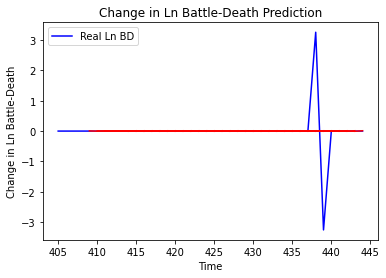

Storing forecasts...
Evaluating delta multi-step forecasts...
{'country': 'Eritrea', 'country_id': 56, 'step': 't+0', 'mse': 0.3525050029675772, 'mae': 0.114510841776408, 'r2': -0.030580450519889224, 'tadda_score': 0.114510841776408}
{'country': 'Eritrea', 'country_id': 56, 'step': 't+1', 'mse': 0.35329248026901994, 'mae': 0.11098284033758167, 'r2': -0.0328827120630244, 'tadda_score': 0.11098284033758167}
{'country': 'Eritrea', 'country_id': 56, 'step': 't+2', 'mse': 0.3515275340611582, 'mae': 0.11908032880174839, 'r2': -0.027722731232316056, 'tadda_score': 0.11908032880174839}
{'country': 'Eritrea', 'country_id': 56, 'step': 't+3', 'mse': 0.3524738950894525, 'mae': 0.11465289032407328, 'r2': -0.03048950380769333, 'tadda_score': 0.11465289032407328}
{'country': 'Eritrea', 'country_id': 56, 'step': 't+4', 'mse': 0.35040463374338654, 'mae': 0.12463114930637403, 'r2': -0.024439829980884564, 'tadda_score': 0.12463114930637403}
{'country': 'Eritrea', 'country_id': 56, 'step': 't+5', 'mse': 

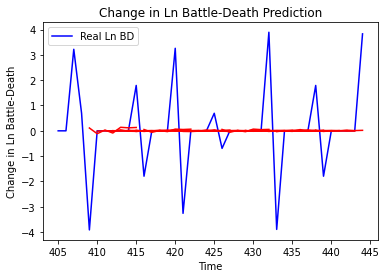

Storing forecasts...
Evaluating delta multi-step forecasts...
{'country': 'Ethiopia', 'country_id': 57, 'step': 't+0', 'mse': 2.5973441170225255, 'mae': 0.843337590392256, 'r2': -0.008427967954992788, 'tadda_score': 0.8506995673187814}
{'country': 'Ethiopia', 'country_id': 57, 'step': 't+1', 'mse': 2.9154830586342246, 'mae': 0.9423351247124331, 'r2': -0.007308441439156432, 'tadda_score': 0.9427894303835885}
{'country': 'Ethiopia', 'country_id': 57, 'step': 't+2', 'mse': 2.911774943964544, 'mae': 0.9466159342660837, 'r2': -0.0060272763171258514, 'tadda_score': 0.9468582917110331}
{'country': 'Ethiopia', 'country_id': 57, 'step': 't+3', 'mse': 2.9312526783337405, 'mae': 0.9473385953061861, 'r2': -0.012756893967311056, 'tadda_score': 0.9485912020889379}
{'country': 'Ethiopia', 'country_id': 57, 'step': 't+4', 'mse': 2.3922220731467574, 'mae': 0.800774537790991, 'r2': -0.01598143882866343, 'tadda_score': 0.8060636406954895}
{'country': 'Ethiopia', 'country_id': 57, 'step': 't+5', 'mse': 2.

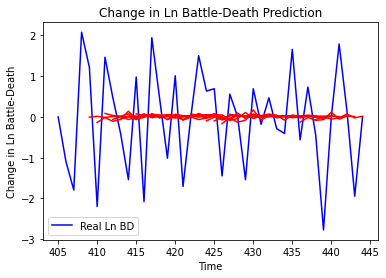

Storing forecasts...
Evaluating delta multi-step forecasts...
{'country': 'Algeria', 'country_id': 67, 'step': 't+0', 'mse': 1.1931835828502293, 'mae': 0.9157282390296893, 'r2': 0.06167089555952854, 'tadda_score': 0.9283207539134161}
{'country': 'Algeria', 'country_id': 67, 'step': 't+1', 'mse': 1.655258391333115, 'mae': 1.0254622568867435, 'r2': -0.044764591495905615, 'tadda_score': 1.0699704638242056}
{'country': 'Algeria', 'country_id': 67, 'step': 't+2', 'mse': 1.6142221826806322, 'mae': 1.025865478684374, 'r2': -0.10325231160010628, 'tadda_score': 1.098248888547091}
{'country': 'Algeria', 'country_id': 67, 'step': 't+3', 'mse': 1.9624546608134508, 'mae': 1.1371030714374006, 'r2': -0.062374675865321194, 'tadda_score': 1.229543574652197}
{'country': 'Algeria', 'country_id': 67, 'step': 't+4', 'mse': 1.7604717664909708, 'mae': 1.1119406168567225, 'r2': -0.049375479587420834, 'tadda_score': 1.1651588958906223}
{'country': 'Algeria', 'country_id': 67, 'step': 't+5', 'mse': 1.6845406151

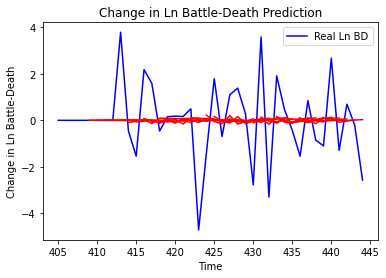

Storing forecasts...
Evaluating delta multi-step forecasts...
{'country': 'Cameroon', 'country_id': 69, 'step': 't+0', 'mse': 3.052405230169509, 'mae': 1.249651071313195, 'r2': 0.03439225863411455, 'tadda_score': 1.274740333521786}
{'country': 'Cameroon', 'country_id': 69, 'step': 't+1', 'mse': 4.495487802694191, 'mae': 1.452053069053744, 'r2': -0.040327308470836654, 'tadda_score': 1.5036438284850666}
{'country': 'Cameroon', 'country_id': 69, 'step': 't+2', 'mse': 5.218353676890812, 'mae': 1.7584274419336638, 'r2': -0.030135096594523292, 'tadda_score': 1.7909093748841804}
{'country': 'Cameroon', 'country_id': 69, 'step': 't+3', 'mse': 6.735453250616392, 'mae': 2.044617349953749, 'r2': -0.06708712299538377, 'tadda_score': 2.1346352152415102}
{'country': 'Cameroon', 'country_id': 69, 'step': 't+4', 'mse': 8.114515774144667, 'mae': 2.285821745510105, 'r2': -0.04774556806966146, 'tadda_score': 2.3253725434307793}
{'country': 'Cameroon', 'country_id': 69, 'step': 't+5', 'mse': 8.10862629270

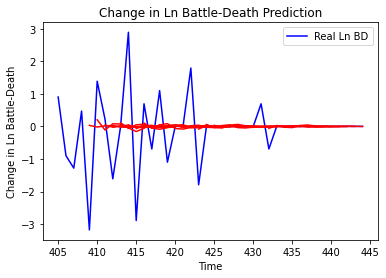

Storing forecasts...
Evaluating delta multi-step forecasts...
{'country': 'Central African Republic', 'country_id': 70, 'step': 't+0', 'mse': 1.3491847809406956, 'mae': 0.6820507529737151, 'r2': 0.03146001622536565, 'tadda_score': 0.6835435643406308}
{'country': 'Central African Republic', 'country_id': 70, 'step': 't+1', 'mse': 1.3435083236648138, 'mae': 0.701749573449374, 'r2': -0.04889033025619538, 'tadda_score': 0.7102071273638118}
{'country': 'Central African Republic', 'country_id': 70, 'step': 't+2', 'mse': 1.458630558889647, 'mae': 0.7196622923758506, 'r2': -0.10663347722804462, 'tadda_score': 0.7331042132151006}
{'country': 'Central African Republic', 'country_id': 70, 'step': 't+3', 'mse': 1.917657731816039, 'mae': 0.7651961989581062, 'r2': -0.1885124561026894, 'tadda_score': 0.7850065250140402}
{'country': 'Central African Republic', 'country_id': 70, 'step': 't+4', 'mse': 2.810983012583814, 'mae': 1.0862977486539065, 'r2': -0.21673745043858772, 'tadda_score': 1.115604457892

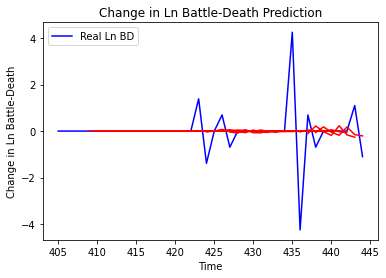

Storing forecasts...
Evaluating delta multi-step forecasts...
{'country': 'Tunisia', 'country_id': 73, 'step': 't+0', 'mse': 1.3838179950781215, 'mae': 0.4675207334604252, 'r2': 0.008367876058655965, 'tadda_score': 0.4710764893985181}
{'country': 'Tunisia', 'country_id': 73, 'step': 't+1', 'mse': 1.2172016358616036, 'mae': 0.4115286625822778, 'r2': -0.029237869382538806, 'tadda_score': 0.4187757598758137}
{'country': 'Tunisia', 'country_id': 73, 'step': 't+2', 'mse': 1.3339446568682864, 'mae': 0.401864518867224, 'r2': -0.01449454099354952, 'tadda_score': 0.40521426234025715}
{'country': 'Tunisia', 'country_id': 73, 'step': 't+3', 'mse': 0.7844256276458241, 'mae': 0.31691976528421206, 'r2': -0.04493946250537073, 'tadda_score': 0.32156639636611106}
{'country': 'Tunisia', 'country_id': 73, 'step': 't+4', 'mse': 0.7791446567480297, 'mae': 0.31585800731981956, 'r2': -0.03790464021379303, 'tadda_score': 0.32048854825203776}
{'country': 'Tunisia', 'country_id': 73, 'step': 't+5', 'mse': 0.796

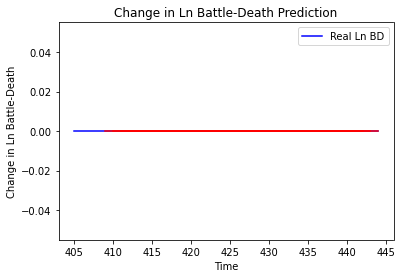

Storing forecasts...
Evaluating delta multi-step forecasts...
{'country': 'Benin', 'country_id': 74, 'step': 't+0', 'mse': 0.0, 'mae': 0.0, 'r2': 1.0, 'tadda_score': 0.0}
{'country': 'Benin', 'country_id': 74, 'step': 't+1', 'mse': 0.0, 'mae': 0.0, 'r2': 1.0, 'tadda_score': 0.0}
{'country': 'Benin', 'country_id': 74, 'step': 't+2', 'mse': 0.0, 'mae': 0.0, 'r2': 1.0, 'tadda_score': 0.0}
{'country': 'Benin', 'country_id': 74, 'step': 't+3', 'mse': 0.0, 'mae': 0.0, 'r2': 1.0, 'tadda_score': 0.0}
{'country': 'Benin', 'country_id': 74, 'step': 't+4', 'mse': 0.0, 'mae': 0.0, 'r2': 1.0, 'tadda_score': 0.0}
{'country': 'Benin', 'country_id': 74, 'step': 't+5', 'mse': 0.0, 'mae': 0.0, 'r2': 1.0, 'tadda_score': 0.0}
{'country': 'Benin', 'country_id': 74, 'step': 't+6', 'mse': 0.0, 'mae': 0.0, 'r2': 1.0, 'tadda_score': 0.0}
['Equatorial Guinea']
Building vanilla Model...
Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Sh

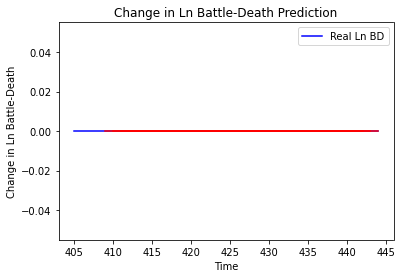

Storing forecasts...
Evaluating delta multi-step forecasts...
{'country': 'Equatorial Guinea', 'country_id': 76, 'step': 't+0', 'mse': 0.0, 'mae': 0.0, 'r2': 1.0, 'tadda_score': 0.0}
{'country': 'Equatorial Guinea', 'country_id': 76, 'step': 't+1', 'mse': 0.0, 'mae': 0.0, 'r2': 1.0, 'tadda_score': 0.0}
{'country': 'Equatorial Guinea', 'country_id': 76, 'step': 't+2', 'mse': 0.0, 'mae': 0.0, 'r2': 1.0, 'tadda_score': 0.0}
{'country': 'Equatorial Guinea', 'country_id': 76, 'step': 't+3', 'mse': 0.0, 'mae': 0.0, 'r2': 1.0, 'tadda_score': 0.0}
{'country': 'Equatorial Guinea', 'country_id': 76, 'step': 't+4', 'mse': 0.0, 'mae': 0.0, 'r2': 1.0, 'tadda_score': 0.0}
{'country': 'Equatorial Guinea', 'country_id': 76, 'step': 't+5', 'mse': 0.0, 'mae': 0.0, 'r2': 1.0, 'tadda_score': 0.0}
{'country': 'Equatorial Guinea', 'country_id': 76, 'step': 't+6', 'mse': 0.0, 'mae': 0.0, 'r2': 1.0, 'tadda_score': 0.0}
['Niger']
Building vanilla Model...
Model: "sequential_21"
________________________________

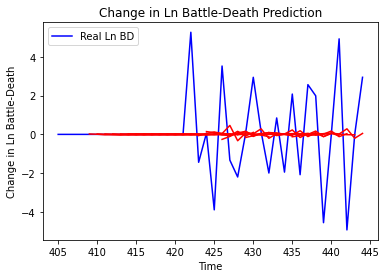

Storing forecasts...
Evaluating delta multi-step forecasts...
{'country': 'Niger', 'country_id': 78, 'step': 't+0', 'mse': 3.4542391537510837, 'mae': 1.1768032289344026, 'r2': -0.03982053067261315, 'tadda_score': 1.1994819095902594}
{'country': 'Niger', 'country_id': 78, 'step': 't+1', 'mse': 4.2466008387628085, 'mae': 1.283498434796598, 'r2': -0.02215355574060829, 'tadda_score': 1.3127414642643596}
{'country': 'Niger', 'country_id': 78, 'step': 't+2', 'mse': 4.599190574953874, 'mae': 1.3455217902077805, 'r2': 0.0026060106619993917, 'tadda_score': 1.3654679762039157}
{'country': 'Niger', 'country_id': 78, 'step': 't+3', 'mse': 3.780991316993244, 'mae': 1.1560458678358432, 'r2': 0.002618084931598652, 'tadda_score': 1.1659924300614632}
{'country': 'Niger', 'country_id': 78, 'step': 't+4', 'mse': 4.666746333277829, 'mae': 1.4130504399764818, 'r2': -0.003524209287252944, 'tadda_score': 1.4552614006130182}
{'country': 'Niger', 'country_id': 78, 'step': 't+5', 'mse': 5.196209117931711, 'mae'

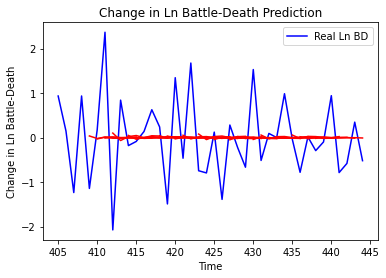

Storing forecasts...
Evaluating delta multi-step forecasts...
{'country': 'Nigeria', 'country_id': 79, 'step': 't+0', 'mse': 0.9560958553721082, 'mae': 0.732202406452388, 'r2': -0.04255824503028016, 'tadda_score': 0.7566564029933666}
{'country': 'Nigeria', 'country_id': 79, 'step': 't+1', 'mse': 0.890364708823197, 'mae': 0.7892321962810092, 'r2': 0.018301140734950594, 'tadda_score': 0.7925397994874946}
{'country': 'Nigeria', 'country_id': 79, 'step': 't+2', 'mse': 1.0600714104380178, 'mae': 0.8511276294844677, 'r2': 0.008337904241528582, 'tadda_score': 0.862484044390411}
{'country': 'Nigeria', 'country_id': 79, 'step': 't+3', 'mse': 1.4000207106593785, 'mae': 0.9984733140531027, 'r2': 0.014185384937659529, 'tadda_score': 1.0193573343071187}
{'country': 'Nigeria', 'country_id': 79, 'step': 't+4', 'mse': 1.0768770561332228, 'mae': 0.8117589438844671, 'r2': 0.03321376851855018, 'tadda_score': 0.8244969069226534}
{'country': 'Nigeria', 'country_id': 79, 'step': 't+5', 'mse': 1.387507619959

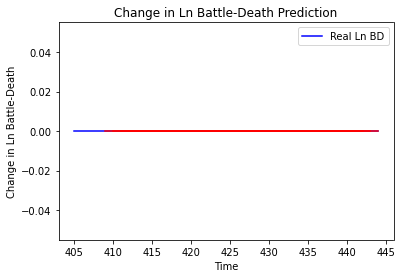

Storing forecasts...
Evaluating delta multi-step forecasts...
{'country': 'Sao Tome and Principe', 'country_id': 80, 'step': 't+0', 'mse': 0.0, 'mae': 0.0, 'r2': 1.0, 'tadda_score': 0.0}
{'country': 'Sao Tome and Principe', 'country_id': 80, 'step': 't+1', 'mse': 0.0, 'mae': 0.0, 'r2': 1.0, 'tadda_score': 0.0}
{'country': 'Sao Tome and Principe', 'country_id': 80, 'step': 't+2', 'mse': 0.0, 'mae': 0.0, 'r2': 1.0, 'tadda_score': 0.0}
{'country': 'Sao Tome and Principe', 'country_id': 80, 'step': 't+3', 'mse': 0.0, 'mae': 0.0, 'r2': 1.0, 'tadda_score': 0.0}
{'country': 'Sao Tome and Principe', 'country_id': 80, 'step': 't+4', 'mse': 0.0, 'mae': 0.0, 'r2': 1.0, 'tadda_score': 0.0}
{'country': 'Sao Tome and Principe', 'country_id': 80, 'step': 't+5', 'mse': 0.0, 'mae': 0.0, 'r2': 1.0, 'tadda_score': 0.0}
{'country': 'Sao Tome and Principe', 'country_id': 80, 'step': 't+6', 'mse': 0.0, 'mae': 0.0, 'r2': 1.0, 'tadda_score': 0.0}
['Togo']
Building vanilla Model...
Model: "sequential_24"
_____

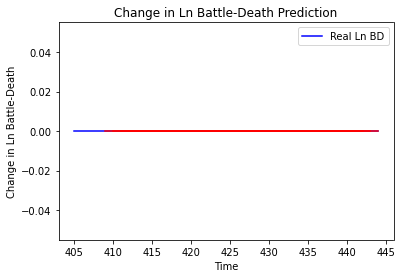

Storing forecasts...
Evaluating delta multi-step forecasts...
{'country': 'Togo', 'country_id': 81, 'step': 't+0', 'mse': 0.0, 'mae': 0.0, 'r2': 1.0, 'tadda_score': 0.0}
{'country': 'Togo', 'country_id': 81, 'step': 't+1', 'mse': 0.0, 'mae': 0.0, 'r2': 1.0, 'tadda_score': 0.0}
{'country': 'Togo', 'country_id': 81, 'step': 't+2', 'mse': 0.0, 'mae': 0.0, 'r2': 1.0, 'tadda_score': 0.0}
{'country': 'Togo', 'country_id': 81, 'step': 't+3', 'mse': 0.0, 'mae': 0.0, 'r2': 1.0, 'tadda_score': 0.0}
{'country': 'Togo', 'country_id': 81, 'step': 't+4', 'mse': 0.0, 'mae': 0.0, 'r2': 1.0, 'tadda_score': 0.0}
{'country': 'Togo', 'country_id': 81, 'step': 't+5', 'mse': 0.0, 'mae': 0.0, 'r2': 1.0, 'tadda_score': 0.0}
{'country': 'Togo', 'country_id': 81, 'step': 't+6', 'mse': 0.0, 'mae': 0.0, 'r2': 1.0, 'tadda_score': 0.0}
['Somalia']
Building vanilla Model...
Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              

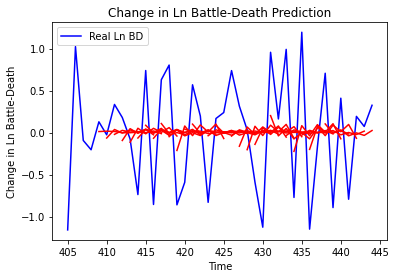

Storing forecasts...
Evaluating delta multi-step forecasts...
{'country': 'Somalia', 'country_id': 120, 'step': 't+0', 'mse': 0.3897518898855656, 'mae': 0.5331268064107796, 'r2': 0.11829962581423059, 'tadda_score': 0.5602353473865788}
{'country': 'Somalia', 'country_id': 120, 'step': 't+1', 'mse': 0.6058599975208767, 'mae': 0.613896657533535, 'r2': -0.06339778447691402, 'tadda_score': 0.6567494411712771}
{'country': 'Somalia', 'country_id': 120, 'step': 't+2', 'mse': 0.7171475241700279, 'mae': 0.6796190602768478, 'r2': -0.11193608916580944, 'tadda_score': 0.7393326960567651}
{'country': 'Somalia', 'country_id': 120, 'step': 't+3', 'mse': 0.6554658360000505, 'mae': 0.6564037026688695, 'r2': -0.10133748099547346, 'tadda_score': 0.6885338506202141}
{'country': 'Somalia', 'country_id': 120, 'step': 't+4', 'mse': 0.6434458713127983, 'mae': 0.6350829303495212, 'r2': -0.14984487519454315, 'tadda_score': 0.6900651143007849}
{'country': 'Somalia', 'country_id': 120, 'step': 't+5', 'mse': 0.4660

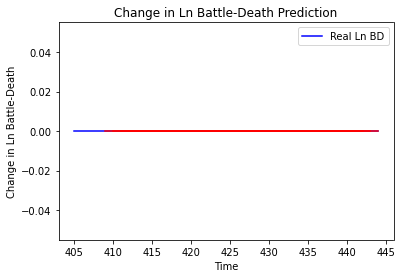

Storing forecasts...
Evaluating delta multi-step forecasts...
{'country': 'Botswana', 'country_id': 154, 'step': 't+0', 'mse': 0.0, 'mae': 0.0, 'r2': 1.0, 'tadda_score': 0.0}
{'country': 'Botswana', 'country_id': 154, 'step': 't+1', 'mse': 0.0, 'mae': 0.0, 'r2': 1.0, 'tadda_score': 0.0}
{'country': 'Botswana', 'country_id': 154, 'step': 't+2', 'mse': 0.0, 'mae': 0.0, 'r2': 1.0, 'tadda_score': 0.0}
{'country': 'Botswana', 'country_id': 154, 'step': 't+3', 'mse': 0.0, 'mae': 0.0, 'r2': 1.0, 'tadda_score': 0.0}
{'country': 'Botswana', 'country_id': 154, 'step': 't+4', 'mse': 0.0, 'mae': 0.0, 'r2': 1.0, 'tadda_score': 0.0}
{'country': 'Botswana', 'country_id': 154, 'step': 't+5', 'mse': 0.0, 'mae': 0.0, 'r2': 1.0, 'tadda_score': 0.0}
{'country': 'Botswana', 'country_id': 154, 'step': 't+6', 'mse': 0.0, 'mae': 0.0, 'r2': 1.0, 'tadda_score': 0.0}
['Burundi']
Building vanilla Model...
Model: "sequential_27"
_________________________________________________________________
Layer (type)        

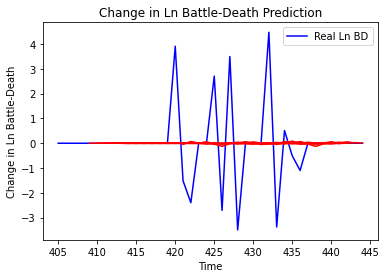

Storing forecasts...
Evaluating delta multi-step forecasts...
{'country': 'Burundi', 'country_id': 155, 'step': 't+0', 'mse': 3.1613810234511734, 'mae': 1.007238112549661, 'r2': 0.008513222274427523, 'tadda_score': 1.0085742949629735}
{'country': 'Burundi', 'country_id': 155, 'step': 't+1', 'mse': 3.174837718446782, 'mae': 1.0273290702189122, 'r2': 0.003336647050563135, 'tadda_score': 1.0281608851984256}
{'country': 'Burundi', 'country_id': 155, 'step': 't+2', 'mse': 4.007986956120908, 'mae': 1.3088284286330751, 'r2': 0.010288920270149049, 'tadda_score': 1.3114682529092443}
{'country': 'Burundi', 'country_id': 155, 'step': 't+3', 'mse': 3.8581955995426447, 'mae': 1.1913207447826324, 'r2': 0.011503942017082713, 'tadda_score': 1.1977639773288824}
{'country': 'Burundi', 'country_id': 155, 'step': 't+4', 'mse': 2.505970087018051, 'mae': 0.888096724022484, 'r2': -0.005234375239485001, 'tadda_score': 0.8907814598707419}
{'country': 'Burundi', 'country_id': 155, 'step': 't+5', 'mse': 3.376766

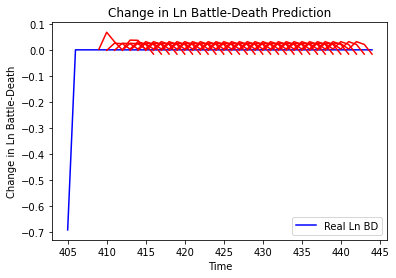

Storing forecasts...
Evaluating delta multi-step forecasts...
{'country': 'Rwanda', 'country_id': 156, 'step': 't+0', 'mse': 3.7679354235911704e-06, 'mae': 0.0019410188348653417, 'r2': 0.0, 'tadda_score': 0.0019410188348653417}
{'country': 'Rwanda', 'country_id': 156, 'step': 't+1', 'mse': 0.0006985374063755264, 'mae': 0.025093304676314196, 'r2': 0.0, 'tadda_score': 0.025093304676314196}
{'country': 'Rwanda', 'country_id': 156, 'step': 't+2', 'mse': 0.002489578015740638, 'mae': 0.04895675828059514, 'r2': 0.0, 'tadda_score': 0.04895675828059514}
{'country': 'Rwanda', 'country_id': 156, 'step': 't+3', 'mse': 0.0027816751177132085, 'mae': 0.051949873690803845, 'r2': 0.0, 'tadda_score': 0.051949873690803845}
{'country': 'Rwanda', 'country_id': 156, 'step': 't+4', 'mse': 0.0225027152695844, 'mae': 0.07982436399766843, 'r2': -0.4535451101883716, 'tadda_score': 0.08217873008160831}
{'country': 'Rwanda', 'country_id': 156, 'step': 't+5', 'mse': 0.025725049532731817, 'mae': 0.1012962507070009, 

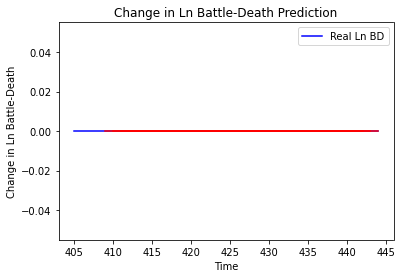

Storing forecasts...
Evaluating delta multi-step forecasts...
{'country': 'Zambia', 'country_id': 157, 'step': 't+0', 'mse': 0.0, 'mae': 0.0, 'r2': 1.0, 'tadda_score': 0.0}
{'country': 'Zambia', 'country_id': 157, 'step': 't+1', 'mse': 0.0, 'mae': 0.0, 'r2': 1.0, 'tadda_score': 0.0}
{'country': 'Zambia', 'country_id': 157, 'step': 't+2', 'mse': 0.0, 'mae': 0.0, 'r2': 1.0, 'tadda_score': 0.0}
{'country': 'Zambia', 'country_id': 157, 'step': 't+3', 'mse': 0.0, 'mae': 0.0, 'r2': 1.0, 'tadda_score': 0.0}
{'country': 'Zambia', 'country_id': 157, 'step': 't+4', 'mse': 0.0, 'mae': 0.0, 'r2': 1.0, 'tadda_score': 0.0}
{'country': 'Zambia', 'country_id': 157, 'step': 't+5', 'mse': 0.0, 'mae': 0.0, 'r2': 1.0, 'tadda_score': 0.0}
{'country': 'Zambia', 'country_id': 157, 'step': 't+6', 'mse': 0.0, 'mae': 0.0, 'r2': 1.0, 'tadda_score': 0.0}
['Zimbabwe']
Building vanilla Model...
Model: "sequential_30"
_________________________________________________________________
Layer (type)                 Outp

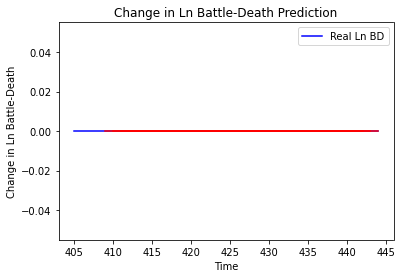

Storing forecasts...
Evaluating delta multi-step forecasts...
{'country': 'Zimbabwe', 'country_id': 158, 'step': 't+0', 'mse': 0.0, 'mae': 0.0, 'r2': 1.0, 'tadda_score': 0.0}
{'country': 'Zimbabwe', 'country_id': 158, 'step': 't+1', 'mse': 0.0, 'mae': 0.0, 'r2': 1.0, 'tadda_score': 0.0}
{'country': 'Zimbabwe', 'country_id': 158, 'step': 't+2', 'mse': 0.0, 'mae': 0.0, 'r2': 1.0, 'tadda_score': 0.0}
{'country': 'Zimbabwe', 'country_id': 158, 'step': 't+3', 'mse': 0.0, 'mae': 0.0, 'r2': 1.0, 'tadda_score': 0.0}
{'country': 'Zimbabwe', 'country_id': 158, 'step': 't+4', 'mse': 0.0, 'mae': 0.0, 'r2': 1.0, 'tadda_score': 0.0}
{'country': 'Zimbabwe', 'country_id': 158, 'step': 't+5', 'mse': 0.0, 'mae': 0.0, 'r2': 1.0, 'tadda_score': 0.0}
{'country': 'Zimbabwe', 'country_id': 158, 'step': 't+6', 'mse': 0.0, 'mae': 0.0, 'r2': 1.0, 'tadda_score': 0.0}
['Comoros']
Building vanilla Model...
Model: "sequential_31"
_________________________________________________________________
Layer (type)        

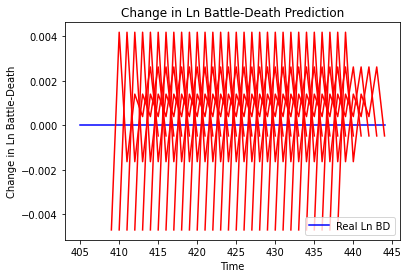

Storing forecasts...
Evaluating delta multi-step forecasts...
{'country': 'Comoros', 'country_id': 159, 'step': 't+0', 'mse': 2.2009505785673894e-05, 'mae': 0.00469142897054553, 'r2': 0.0, 'tadda_score': 0.00469142897054553}
{'country': 'Comoros', 'country_id': 159, 'step': 't+1', 'mse': 2.7001246808767455e-07, 'mae': 0.0005196272395551205, 'r2': 0.0, 'tadda_score': 0.0005196272395551205}
{'country': 'Comoros', 'country_id': 159, 'step': 't+2', 'mse': 4.624499870245892e-06, 'mae': 0.0021504650358110666, 'r2': 0.0, 'tadda_score': 0.0021504650358110666}
{'country': 'Comoros', 'country_id': 159, 'step': 't+3', 'mse': 5.676826539749978e-07, 'mae': 0.0007534471806138754, 'r2': 0.0, 'tadda_score': 0.0007534471806138754}
{'country': 'Comoros', 'country_id': 159, 'step': 't+4', 'mse': 2.056477067369309e-05, 'mae': 0.004534839652478695, 'r2': 0.0, 'tadda_score': 0.004534839652478695}
{'country': 'Comoros', 'country_id': 159, 'step': 't+5', 'mse': 3.6859697787883228e-06, 'mae': 0.001919887959957

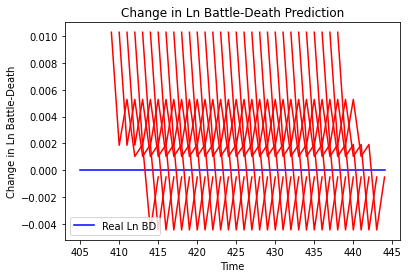

Storing forecasts...
Evaluating delta multi-step forecasts...
{'country': 'Lesotho', 'country_id': 160, 'step': 't+0', 'mse': 0.0001056750309238498, 'mae': 0.010279836133122444, 'r2': 0.0, 'tadda_score': 0.010279836133122444}
{'country': 'Lesotho', 'country_id': 160, 'step': 't+1', 'mse': 0.00014736540548746305, 'mae': 0.012139415368437767, 'r2': 0.0, 'tadda_score': 0.012139415368437767}
{'country': 'Lesotho', 'country_id': 160, 'step': 't+2', 'mse': 0.0003031450971671991, 'mae': 0.017411062493920326, 'r2': 0.0, 'tadda_score': 0.017411062493920326}
{'country': 'Lesotho', 'country_id': 160, 'step': 't+3', 'mse': 0.0003399683697839079, 'mae': 0.018438231199979782, 'r2': 0.0, 'tadda_score': 0.018438231199979782}
{'country': 'Lesotho', 'country_id': 160, 'step': 't+4', 'mse': 0.00034209261850209893, 'mae': 0.018495745956897736, 'r2': 0.0, 'tadda_score': 0.018495745956897736}
{'country': 'Lesotho', 'country_id': 160, 'step': 't+5', 'mse': 0.0001972878749108148, 'mae': 0.014045920222997665, 

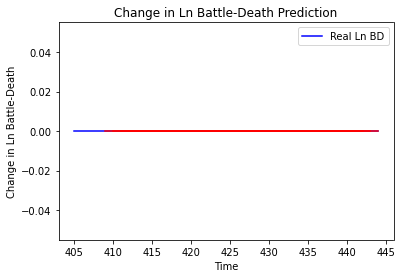

Storing forecasts...
Evaluating delta multi-step forecasts...
{'country': 'Malawi', 'country_id': 161, 'step': 't+0', 'mse': 0.0, 'mae': 0.0, 'r2': 1.0, 'tadda_score': 0.0}
{'country': 'Malawi', 'country_id': 161, 'step': 't+1', 'mse': 0.0, 'mae': 0.0, 'r2': 1.0, 'tadda_score': 0.0}
{'country': 'Malawi', 'country_id': 161, 'step': 't+2', 'mse': 0.0, 'mae': 0.0, 'r2': 1.0, 'tadda_score': 0.0}
{'country': 'Malawi', 'country_id': 161, 'step': 't+3', 'mse': 0.0, 'mae': 0.0, 'r2': 1.0, 'tadda_score': 0.0}
{'country': 'Malawi', 'country_id': 161, 'step': 't+4', 'mse': 0.0, 'mae': 0.0, 'r2': 1.0, 'tadda_score': 0.0}
{'country': 'Malawi', 'country_id': 161, 'step': 't+5', 'mse': 0.0, 'mae': 0.0, 'r2': 1.0, 'tadda_score': 0.0}
{'country': 'Malawi', 'country_id': 161, 'step': 't+6', 'mse': 0.0, 'mae': 0.0, 'r2': 1.0, 'tadda_score': 0.0}
['Mozambique']
Building vanilla Model...
Model: "sequential_34"
_________________________________________________________________
Layer (type)                 Ou

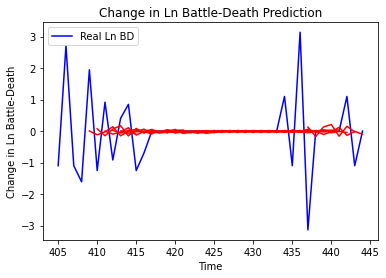

Storing forecasts...
Evaluating delta multi-step forecasts...
{'country': 'Mozambique', 'country_id': 162, 'step': 't+0', 'mse': 1.1085937325407969, 'mae': 0.5732984556898482, 'r2': -0.037883156506169025, 'tadda_score': 0.5838792880768584}
{'country': 'Mozambique', 'country_id': 162, 'step': 't+1', 'mse': 0.7196540457769811, 'mae': 0.424690242190589, 'r2': 0.021742963310705687, 'tadda_score': 0.4349180581526751}
{'country': 'Mozambique', 'country_id': 162, 'step': 't+2', 'mse': 0.7927168803575907, 'mae': 0.49661777383203914, 'r2': -0.01067213275495904, 'tadda_score': 0.5101395350929658}
{'country': 'Mozambique', 'country_id': 162, 'step': 't+3', 'mse': 1.005924629080869, 'mae': 0.6184825674082367, 'r2': -0.019282537159985846, 'tadda_score': 0.6298826299990742}
{'country': 'Mozambique', 'country_id': 162, 'step': 't+4', 'mse': 0.7735148917882142, 'mae': 0.5141154085462897, 'r2': 0.03263348877891603, 'tadda_score': 0.5187435279777257}
{'country': 'Mozambique', 'country_id': 162, 'step': 

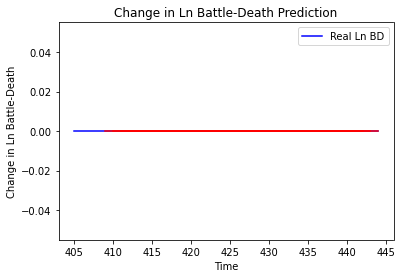

Storing forecasts...
Evaluating delta multi-step forecasts...
{'country': 'South Africa', 'country_id': 163, 'step': 't+0', 'mse': 0.0, 'mae': 0.0, 'r2': 1.0, 'tadda_score': 0.0}
{'country': 'South Africa', 'country_id': 163, 'step': 't+1', 'mse': 0.0, 'mae': 0.0, 'r2': 1.0, 'tadda_score': 0.0}
{'country': 'South Africa', 'country_id': 163, 'step': 't+2', 'mse': 0.0, 'mae': 0.0, 'r2': 1.0, 'tadda_score': 0.0}
{'country': 'South Africa', 'country_id': 163, 'step': 't+3', 'mse': 0.0, 'mae': 0.0, 'r2': 1.0, 'tadda_score': 0.0}
{'country': 'South Africa', 'country_id': 163, 'step': 't+4', 'mse': 0.0, 'mae': 0.0, 'r2': 1.0, 'tadda_score': 0.0}
{'country': 'South Africa', 'country_id': 163, 'step': 't+5', 'mse': 0.0, 'mae': 0.0, 'r2': 1.0, 'tadda_score': 0.0}
{'country': 'South Africa', 'country_id': 163, 'step': 't+6', 'mse': 0.0, 'mae': 0.0, 'r2': 1.0, 'tadda_score': 0.0}
['Swaziland']
Building vanilla Model...
Model: "sequential_36"
________________________________________________________

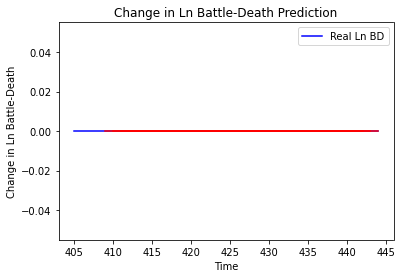

Storing forecasts...
Evaluating delta multi-step forecasts...
{'country': 'Swaziland', 'country_id': 164, 'step': 't+0', 'mse': 0.0, 'mae': 0.0, 'r2': 1.0, 'tadda_score': 0.0}
{'country': 'Swaziland', 'country_id': 164, 'step': 't+1', 'mse': 0.0, 'mae': 0.0, 'r2': 1.0, 'tadda_score': 0.0}
{'country': 'Swaziland', 'country_id': 164, 'step': 't+2', 'mse': 0.0, 'mae': 0.0, 'r2': 1.0, 'tadda_score': 0.0}
{'country': 'Swaziland', 'country_id': 164, 'step': 't+3', 'mse': 0.0, 'mae': 0.0, 'r2': 1.0, 'tadda_score': 0.0}
{'country': 'Swaziland', 'country_id': 164, 'step': 't+4', 'mse': 0.0, 'mae': 0.0, 'r2': 1.0, 'tadda_score': 0.0}
{'country': 'Swaziland', 'country_id': 164, 'step': 't+5', 'mse': 0.0, 'mae': 0.0, 'r2': 1.0, 'tadda_score': 0.0}
{'country': 'Swaziland', 'country_id': 164, 'step': 't+6', 'mse': 0.0, 'mae': 0.0, 'r2': 1.0, 'tadda_score': 0.0}
['Angola']
Building vanilla Model...
Model: "sequential_37"
_________________________________________________________________
Layer (type)  

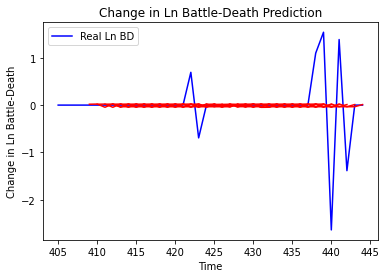

Storing forecasts...
Evaluating delta multi-step forecasts...
{'country': 'Angola', 'country_id': 165, 'step': 't+0', 'mse': 0.06987160992265556, 'mae': 0.09744411985120105, 'r2': 0.014793529524043891, 'tadda_score': 0.09744411985120105}
{'country': 'Angola', 'country_id': 165, 'step': 't+1', 'mse': 0.07063428131800785, 'mae': 0.11555254892797201, 'r2': 0.004039679793377271, 'tadda_score': 0.11675569103450506}
{'country': 'Angola', 'country_id': 165, 'step': 't+2', 'mse': 0.07252038514129457, 'mae': 0.0888111921217633, 'r2': -0.02255483681713799, 'tadda_score': 0.08917564273542093}
{'country': 'Angola', 'country_id': 165, 'step': 't+3', 'mse': 0.07096080742914147, 'mae': 0.09922613553122607, 'r2': -0.0005644167463232375, 'tadda_score': 0.09964742662425764}
{'country': 'Angola', 'country_id': 165, 'step': 't+4', 'mse': 0.07638829419358167, 'mae': 0.1185742848432653, 'r2': -0.07709328282895944, 'tadda_score': 0.1210985748287631}
{'country': 'Angola', 'country_id': 165, 'step': 't+5', 'ms

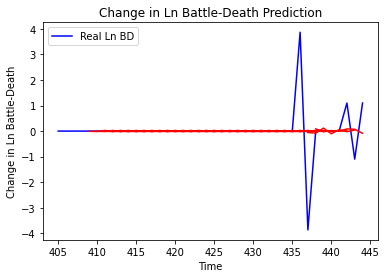

Storing forecasts...
Evaluating delta multi-step forecasts...
{'country': 'Congo', 'country_id': 166, 'step': 't+0', 'mse': 0.9872337589077367, 'mae': 0.2673504559026958, 'r2': 0.011856969454902, 'tadda_score': 0.2676479240583183}
{'country': 'Congo', 'country_id': 166, 'step': 't+1', 'mse': 1.0234758099363013, 'mae': 0.2882336742258868, 'r2': -0.024418461579950534, 'tadda_score': 0.29121138779588557}
{'country': 'Congo', 'country_id': 166, 'step': 't+2', 'mse': 0.499842560905441, 'mae': 0.1327352984039387, 'r2': -0.03510951192095746, 'tadda_score': 0.13274101982895542}
{'country': 'Congo', 'country_id': 166, 'step': 't+3', 'mse': 0.5058781277428043, 'mae': 0.15475803000613061, 'r2': -0.047608392832323654, 'tadda_score': 0.15543234616899498}
{'country': 'Congo', 'country_id': 166, 'step': 't+4', 'mse': 0.5000679722446575, 'mae': 0.13765607676539826, 'r2': -0.03557630974804793, 'tadda_score': 0.13765607676539826}
{'country': 'Congo', 'country_id': 166, 'step': 't+5', 'mse': 0.5017198390

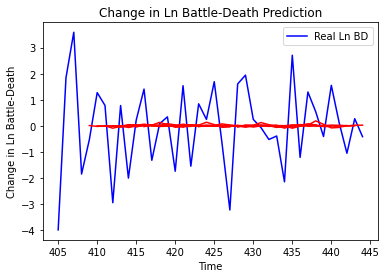

Storing forecasts...
Evaluating delta multi-step forecasts...
{'country': 'Congo, DRC', 'country_id': 167, 'step': 't+0', 'mse': 2.1591759336092102, 'mae': 1.204855585219309, 'r2': -0.010778090325718859, 'tadda_score': 1.2169132616650018}
{'country': 'Congo, DRC', 'country_id': 167, 'step': 't+1', 'mse': 2.8652971469176975, 'mae': 1.389633731623461, 'r2': -0.005176971316908308, 'tadda_score': 1.3902258958375406}
{'country': 'Congo, DRC', 'country_id': 167, 'step': 't+2', 'mse': 3.0240788630752826, 'mae': 1.3663056683845105, 'r2': -0.011967907644909959, 'tadda_score': 1.3756173775028968}
{'country': 'Congo, DRC', 'country_id': 167, 'step': 't+3', 'mse': 3.787335415609919, 'mae': 1.5364747151213345, 'r2': -0.04253777974070139, 'tadda_score': 1.581524718469874}
{'country': 'Congo, DRC', 'country_id': 167, 'step': 't+4', 'mse': 3.7297916559616704, 'mae': 1.5710159023347174, 'r2': -0.0624115796325615, 'tadda_score': 1.6301499455601152}
{'country': 'Congo, DRC', 'country_id': 167, 'step': 't

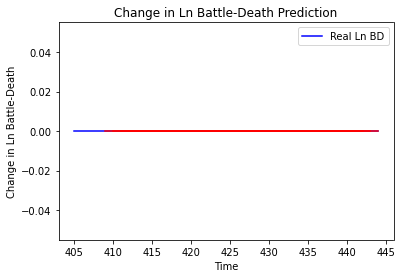

Storing forecasts...
Evaluating delta multi-step forecasts...
{'country': 'Gabon', 'country_id': 169, 'step': 't+0', 'mse': 0.0, 'mae': 0.0, 'r2': 1.0, 'tadda_score': 0.0}
{'country': 'Gabon', 'country_id': 169, 'step': 't+1', 'mse': 0.0, 'mae': 0.0, 'r2': 1.0, 'tadda_score': 0.0}
{'country': 'Gabon', 'country_id': 169, 'step': 't+2', 'mse': 0.0, 'mae': 0.0, 'r2': 1.0, 'tadda_score': 0.0}
{'country': 'Gabon', 'country_id': 169, 'step': 't+3', 'mse': 0.0, 'mae': 0.0, 'r2': 1.0, 'tadda_score': 0.0}
{'country': 'Gabon', 'country_id': 169, 'step': 't+4', 'mse': 0.0, 'mae': 0.0, 'r2': 1.0, 'tadda_score': 0.0}
{'country': 'Gabon', 'country_id': 169, 'step': 't+5', 'mse': 0.0, 'mae': 0.0, 'r2': 1.0, 'tadda_score': 0.0}
{'country': 'Gabon', 'country_id': 169, 'step': 't+6', 'mse': 0.0, 'mae': 0.0, 'r2': 1.0, 'tadda_score': 0.0}
['Namibia']
Building vanilla Model...
Model: "sequential_41"
_________________________________________________________________
Layer (type)                 Output Shape

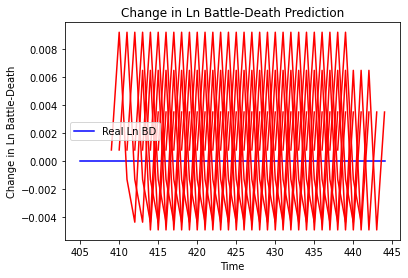

Storing forecasts...
Evaluating delta multi-step forecasts...
{'country': 'Namibia', 'country_id': 170, 'step': 't+0', 'mse': 6.088691869457572e-07, 'mae': 0.0007803007028996944, 'r2': 0.0, 'tadda_score': 0.0007803007028996944}
{'country': 'Namibia', 'country_id': 170, 'step': 't+1', 'mse': 9.912865664368775e-05, 'mae': 0.00995633751153946, 'r2': 0.0, 'tadda_score': 0.00995633751153946}
{'country': 'Namibia', 'country_id': 170, 'step': 't+2', 'mse': 7.457264002811229e-05, 'mae': 0.008635545149445534, 'r2': 0.0, 'tadda_score': 0.008635545149445534}
{'country': 'Namibia', 'country_id': 170, 'step': 't+3', 'mse': 1.8210219010343122e-05, 'mae': 0.004267343319952488, 'r2': 0.0, 'tadda_score': 0.004267343319952488}
{'country': 'Namibia', 'country_id': 170, 'step': 't+4', 'mse': 2.40095181924479e-06, 'mae': 0.0015495005063712597, 'r2': 0.0, 'tadda_score': 0.0015495005063712597}
{'country': 'Namibia', 'country_id': 170, 'step': 't+5', 'mse': 1.1364069929090115e-05, 'mae': 0.003371063619852066,

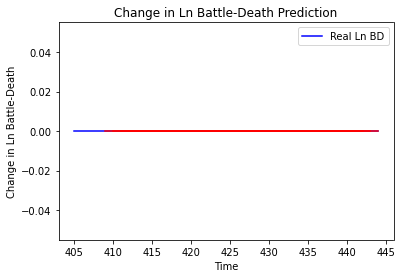

Storing forecasts...
Evaluating delta multi-step forecasts...
{'country': 'Madagascar', 'country_id': 172, 'step': 't+0', 'mse': 0.0, 'mae': 0.0, 'r2': 1.0, 'tadda_score': 0.0}
{'country': 'Madagascar', 'country_id': 172, 'step': 't+1', 'mse': 0.0, 'mae': 0.0, 'r2': 1.0, 'tadda_score': 0.0}
{'country': 'Madagascar', 'country_id': 172, 'step': 't+2', 'mse': 0.0, 'mae': 0.0, 'r2': 1.0, 'tadda_score': 0.0}
{'country': 'Madagascar', 'country_id': 172, 'step': 't+3', 'mse': 0.0, 'mae': 0.0, 'r2': 1.0, 'tadda_score': 0.0}
{'country': 'Madagascar', 'country_id': 172, 'step': 't+4', 'mse': 0.0, 'mae': 0.0, 'r2': 1.0, 'tadda_score': 0.0}
{'country': 'Madagascar', 'country_id': 172, 'step': 't+5', 'mse': 0.0, 'mae': 0.0, 'r2': 1.0, 'tadda_score': 0.0}
{'country': 'Madagascar', 'country_id': 172, 'step': 't+6', 'mse': 0.0, 'mae': 0.0, 'r2': 1.0, 'tadda_score': 0.0}
['Mauritius']
Building vanilla Model...
Model: "sequential_43"
_________________________________________________________________
Laye

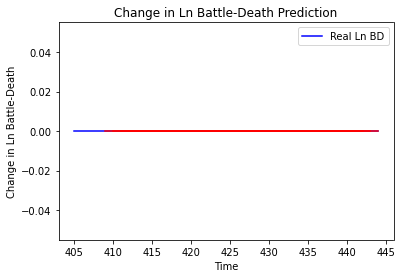

Storing forecasts...
Evaluating delta multi-step forecasts...
{'country': 'Mauritius', 'country_id': 173, 'step': 't+0', 'mse': 0.0, 'mae': 0.0, 'r2': 1.0, 'tadda_score': 0.0}
{'country': 'Mauritius', 'country_id': 173, 'step': 't+1', 'mse': 0.0, 'mae': 0.0, 'r2': 1.0, 'tadda_score': 0.0}
{'country': 'Mauritius', 'country_id': 173, 'step': 't+2', 'mse': 0.0, 'mae': 0.0, 'r2': 1.0, 'tadda_score': 0.0}
{'country': 'Mauritius', 'country_id': 173, 'step': 't+3', 'mse': 0.0, 'mae': 0.0, 'r2': 1.0, 'tadda_score': 0.0}
{'country': 'Mauritius', 'country_id': 173, 'step': 't+4', 'mse': 0.0, 'mae': 0.0, 'r2': 1.0, 'tadda_score': 0.0}
{'country': 'Mauritius', 'country_id': 173, 'step': 't+5', 'mse': 0.0, 'mae': 0.0, 'r2': 1.0, 'tadda_score': 0.0}
{'country': 'Mauritius', 'country_id': 173, 'step': 't+6', 'mse': 0.0, 'mae': 0.0, 'r2': 1.0, 'tadda_score': 0.0}
['Seychelles']
Building vanilla Model...
Model: "sequential_44"
_________________________________________________________________
Layer (typ

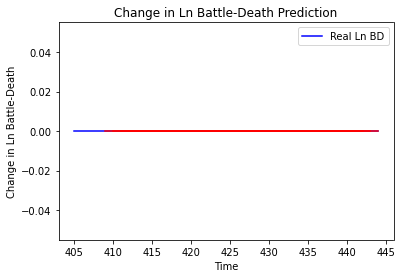

Storing forecasts...
Evaluating delta multi-step forecasts...
{'country': 'Seychelles', 'country_id': 174, 'step': 't+0', 'mse': 0.0, 'mae': 0.0, 'r2': 1.0, 'tadda_score': 0.0}
{'country': 'Seychelles', 'country_id': 174, 'step': 't+1', 'mse': 0.0, 'mae': 0.0, 'r2': 1.0, 'tadda_score': 0.0}
{'country': 'Seychelles', 'country_id': 174, 'step': 't+2', 'mse': 0.0, 'mae': 0.0, 'r2': 1.0, 'tadda_score': 0.0}
{'country': 'Seychelles', 'country_id': 174, 'step': 't+3', 'mse': 0.0, 'mae': 0.0, 'r2': 1.0, 'tadda_score': 0.0}
{'country': 'Seychelles', 'country_id': 174, 'step': 't+4', 'mse': 0.0, 'mae': 0.0, 'r2': 1.0, 'tadda_score': 0.0}
{'country': 'Seychelles', 'country_id': 174, 'step': 't+5', 'mse': 0.0, 'mae': 0.0, 'r2': 1.0, 'tadda_score': 0.0}
{'country': 'Seychelles', 'country_id': 174, 'step': 't+6', 'mse': 0.0, 'mae': 0.0, 'r2': 1.0, 'tadda_score': 0.0}
['Libya']
Building vanilla Model...
Model: "sequential_45"
_________________________________________________________________
Layer (t

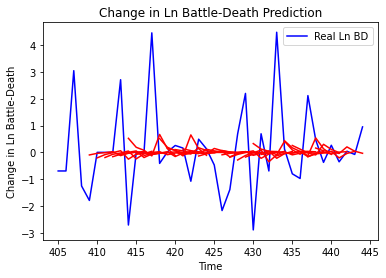

Storing forecasts...
Evaluating delta multi-step forecasts...
{'country': 'Libya', 'country_id': 213, 'step': 't+0', 'mse': 3.230879615094636, 'mae': 1.2484714198439044, 'r2': -0.11703033205829771, 'tadda_score': 1.3434872217368306}
{'country': 'Libya', 'country_id': 213, 'step': 't+1', 'mse': 4.536368025354799, 'mae': 1.64786629637202, 'r2': 0.06302933953941448, 'tadda_score': 1.714773551537299}
{'country': 'Libya', 'country_id': 213, 'step': 't+2', 'mse': 5.302089413638272, 'mae': 1.7805970627760632, 'r2': 0.09150769430724792, 'tadda_score': 1.8195081685926262}
{'country': 'Libya', 'country_id': 213, 'step': 't+3', 'mse': 4.559169555934364, 'mae': 1.6520638962072967, 'r2': 0.07437877815472493, 'tadda_score': 1.6919336582330702}
{'country': 'Libya', 'country_id': 213, 'step': 't+4', 'mse': 6.3760545261543315, 'mae': 1.9021063839265209, 'r2': 5.238373328464441e-05, 'tadda_score': 1.965499713631322}
{'country': 'Libya', 'country_id': 213, 'step': 't+5', 'mse': 7.850918803026443, 'mae': 

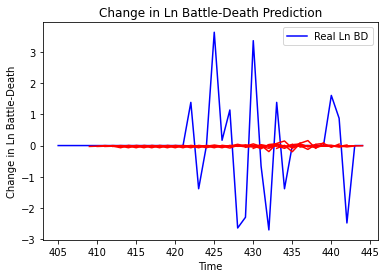

Storing forecasts...
Evaluating delta multi-step forecasts...
{'country': 'Chad', 'country_id': 214, 'step': 't+0', 'mse': 1.8086552239822402, 'mae': 0.7623638671195468, 'r2': -0.011114523721475367, 'tadda_score': 0.7708611062100491}
{'country': 'Chad', 'country_id': 214, 'step': 't+1', 'mse': 2.764774783588578, 'mae': 0.9537418992225412, 'r2': 0.0068183601420239714, 'tadda_score': 0.9616456363627397}
{'country': 'Chad', 'country_id': 214, 'step': 't+2', 'mse': 2.4971160521266755, 'mae': 0.8680456387624915, 'r2': 0.04066639469862798, 'tadda_score': 0.873356438751099}
{'country': 'Chad', 'country_id': 214, 'step': 't+3', 'mse': 3.190773932096899, 'mae': 1.0985289173529327, 'r2': 0.013851428890147233, 'tadda_score': 1.1112383446363885}
{'country': 'Chad', 'country_id': 214, 'step': 't+4', 'mse': 3.1654422375283904, 'mae': 1.039382640962766, 'r2': -0.0012846262996888402, 'tadda_score': 1.0515909850671552}
{'country': 'Chad', 'country_id': 214, 'step': 't+5', 'mse': 3.927896309937577, 'mae

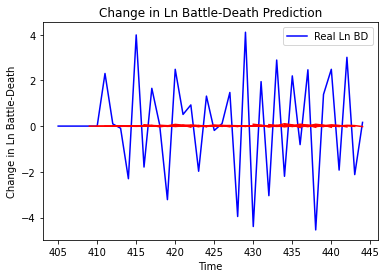

Storing forecasts...
Evaluating delta multi-step forecasts...
{'country': 'Egypt', 'country_id': 222, 'step': 't+0', 'mse': 5.648086496999577, 'mae': 1.9048286713353342, 'r2': -0.00716938917698684, 'tadda_score': 1.9178640800532247}
{'country': 'Egypt', 'country_id': 222, 'step': 't+1', 'mse': 2.555120946546117, 'mae': 1.2703204142612965, 'r2': -0.0011787476350599846, 'tadda_score': 1.2857976203458634}
{'country': 'Egypt', 'country_id': 222, 'step': 't+2', 'mse': 5.430296545650868, 'mae': 1.8598372111512222, 'r2': -0.015732638776039032, 'tadda_score': 1.8755931987066317}
{'country': 'Egypt', 'country_id': 222, 'step': 't+3', 'mse': 3.3596646759680757, 'mae': 1.4773594460818935, 'r2': -0.0339343489464945, 'tadda_score': 1.4936915319005666}
{'country': 'Egypt', 'country_id': 222, 'step': 't+4', 'mse': 5.186616176880208, 'mae': 1.7482361102880215, 'r2': -0.04226476823475278, 'tadda_score': 1.7743434432366167}
{'country': 'Egypt', 'country_id': 222, 'step': 't+5', 'mse': 4.4872757627699, '

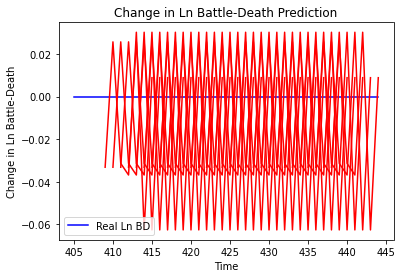

Storing forecasts...
Evaluating delta multi-step forecasts...
{'country': 'Uganda', 'country_id': 235, 'step': 't+0', 'mse': 0.0011011056205836867, 'mae': 0.033182911574840546, 'r2': 0.0, 'tadda_score': 0.033182911574840546}
{'country': 'Uganda', 'country_id': 235, 'step': 't+1', 'mse': 5.620598015459999e-05, 'mae': 0.007497064769268036, 'r2': 0.0, 'tadda_score': 0.007497064769268036}
{'country': 'Uganda', 'country_id': 235, 'step': 't+2', 'mse': 0.001511575455137637, 'mae': 0.03887898474931717, 'r2': 0.0, 'tadda_score': 0.03887898474931717}
{'country': 'Uganda', 'country_id': 235, 'step': 't+3', 'mse': 0.005730688522041172, 'mae': 0.07570131123065948, 'r2': 0.0, 'tadda_score': 0.07570131123065948}
{'country': 'Uganda', 'country_id': 235, 'step': 't+4', 'mse': 0.0050674729182134115, 'mae': 0.07118618488311768, 'r2': 0.0, 'tadda_score': 0.07118618488311768}
{'country': 'Uganda', 'country_id': 235, 'step': 't+5', 'mse': 0.01790092873740634, 'mae': 0.13379435241222382, 'r2': 0.0, 'tadda_s

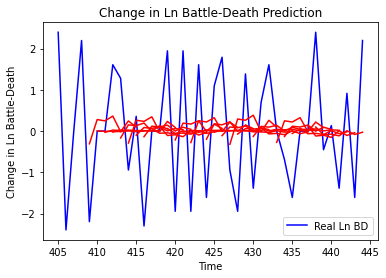

Storing forecasts...
Evaluating delta multi-step forecasts...
{'country': 'Kenya', 'country_id': 237, 'step': 't+0', 'mse': 1.8339743272627425, 'mae': 1.1354995975445121, 'r2': 0.09113869268593311, 'tadda_score': 1.1529733899534158}
{'country': 'Kenya', 'country_id': 237, 'step': 't+1', 'mse': 2.327789328152048, 'mae': 1.1215288571128281, 'r2': -0.0017217157094668867, 'tadda_score': 1.126128681784772}
{'country': 'Kenya', 'country_id': 237, 'step': 't+2', 'mse': 3.126039461974308, 'mae': 1.5998140304080097, 'r2': 0.01813038423015423, 'tadda_score': 1.6236523008946528}
{'country': 'Kenya', 'country_id': 237, 'step': 't+3', 'mse': 2.591980656806748, 'mae': 1.2806678037948884, 'r2': 0.04898633803530272, 'tadda_score': 1.3276501792031008}
{'country': 'Kenya', 'country_id': 237, 'step': 't+4', 'mse': 2.2893300440628885, 'mae': 1.238708164580037, 'r2': 0.046247161071586995, 'tadda_score': 1.2598467676340241}
{'country': 'Kenya', 'country_id': 237, 'step': 't+5', 'mse': 1.5086876110279517, 'm

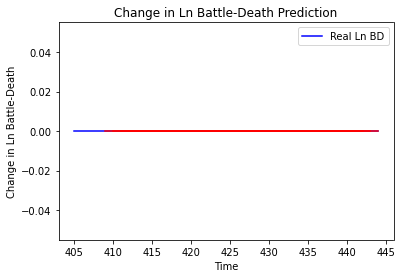

Storing forecasts...
Evaluating delta multi-step forecasts...
{'country': 'Tanzania', 'country_id': 242, 'step': 't+0', 'mse': 0.0, 'mae': 0.0, 'r2': 1.0, 'tadda_score': 0.0}
{'country': 'Tanzania', 'country_id': 242, 'step': 't+1', 'mse': 0.0, 'mae': 0.0, 'r2': 1.0, 'tadda_score': 0.0}
{'country': 'Tanzania', 'country_id': 242, 'step': 't+2', 'mse': 0.0, 'mae': 0.0, 'r2': 1.0, 'tadda_score': 0.0}
{'country': 'Tanzania', 'country_id': 242, 'step': 't+3', 'mse': 0.0, 'mae': 0.0, 'r2': 1.0, 'tadda_score': 0.0}
{'country': 'Tanzania', 'country_id': 242, 'step': 't+4', 'mse': 0.0, 'mae': 0.0, 'r2': 1.0, 'tadda_score': 0.0}
{'country': 'Tanzania', 'country_id': 242, 'step': 't+5', 'mse': 0.0, 'mae': 0.0, 'r2': 1.0, 'tadda_score': 0.0}
{'country': 'Tanzania', 'country_id': 242, 'step': 't+6', 'mse': 0.0, 'mae': 0.0, 'r2': 1.0, 'tadda_score': 0.0}
['Morocco']
Building vanilla Model...
Model: "sequential_51"
_________________________________________________________________
Layer (type)        

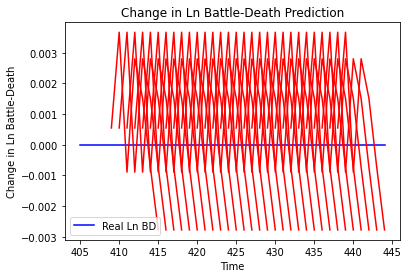

Storing forecasts...
Evaluating delta multi-step forecasts...
{'country': 'Morocco', 'country_id': 243, 'step': 't+0', 'mse': 3.019057848752182e-07, 'mae': 0.0005494595388881862, 'r2': 0.0, 'tadda_score': 0.0005494595388881862}
{'country': 'Morocco', 'country_id': 243, 'step': 't+1', 'mse': 1.7811713318285904e-05, 'mae': 0.004220392554998398, 'r2': 0.0, 'tadda_score': 0.004220392554998398}
{'country': 'Morocco', 'country_id': 243, 'step': 't+2', 'mse': 1.1085595658235714e-05, 'mae': 0.0033295038156211376, 'r2': 0.0, 'tadda_score': 0.0033295038156211376}
{'country': 'Morocco', 'country_id': 243, 'step': 't+3', 'mse': 3.7631807797682904e-05, 'mae': 0.006134476978331804, 'r2': 0.0, 'tadda_score': 0.006134476978331804}
{'country': 'Morocco', 'country_id': 243, 'step': 't+4', 'mse': 1.5827952062696417e-05, 'mae': 0.003978435881435871, 'r2': 0.0, 'tadda_score': 0.003978435881435871}
{'country': 'Morocco', 'country_id': 243, 'step': 't+5', 'mse': 1.0534545286100538e-05, 'mae': 0.0032456964254

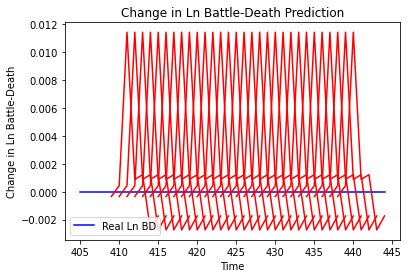

Storing forecasts...
Evaluating delta multi-step forecasts...
{'country': 'Mauritania', 'country_id': 244, 'step': 't+0', 'mse': 1.1978179635712067e-07, 'mae': 0.0003460950683802366, 'r2': 0.0, 'tadda_score': 0.0003460950683802366}
{'country': 'Mauritania', 'country_id': 244, 'step': 't+1', 'mse': 7.479237538544709e-09, 'mae': 8.648258517496288e-05, 'r2': 0.0, 'tadda_score': 8.648258517496288e-05}
{'country': 'Mauritania', 'country_id': 244, 'step': 't+2', 'mse': 0.00013261973939027172, 'mae': 0.011516064405441284, 'r2': 0.0, 'tadda_score': 0.011516064405441284}
{'country': 'Mauritania', 'country_id': 244, 'step': 't+3', 'mse': 0.00015375513544592379, 'mae': 0.012399803847074509, 'r2': 0.0, 'tadda_score': 0.012399803847074509}
{'country': 'Mauritania', 'country_id': 244, 'step': 't+4', 'mse': 0.00017380382907265877, 'mae': 0.013183468021452427, 'r2': 0.0, 'tadda_score': 0.013183468021452427}
{'country': 'Mauritania', 'country_id': 244, 'step': 't+5', 'mse': 0.00010903845407594318, 'mae

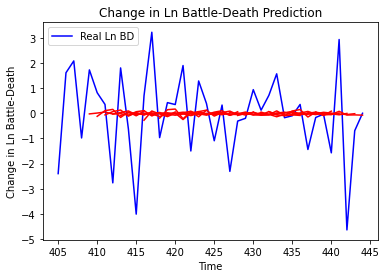

Storing forecasts...
Evaluating delta multi-step forecasts...
{'country': 'Sudan', 'country_id': 245, 'step': 't+0', 'mse': 2.137706365075407, 'mae': 1.0874419119363472, 'r2': -0.007585696286239729, 'tadda_score': 1.1145607369795882}
{'country': 'Sudan', 'country_id': 245, 'step': 't+1', 'mse': 3.4082421828610037, 'mae': 1.4910766656112693, 'r2': 0.013797464108665225, 'tadda_score': 1.4983973162782214}
{'country': 'Sudan', 'country_id': 245, 'step': 't+2', 'mse': 3.6562401430566775, 'mae': 1.6011722121600669, 'r2': 0.04699286474030928, 'tadda_score': 1.6143086071649553}
{'country': 'Sudan', 'country_id': 245, 'step': 't+3', 'mse': 5.481588486040167, 'mae': 1.9960642913883708, 'r2': -0.0021173282054618436, 'tadda_score': 2.005247391875166}
{'country': 'Sudan', 'country_id': 245, 'step': 't+4', 'mse': 7.2611848069467175, 'mae': 2.256951734740989, 'r2': -0.00823046920558168, 'tadda_score': 2.274893558715241}
{'country': 'Sudan', 'country_id': 245, 'step': 't+5', 'mse': 6.98139142222137, '

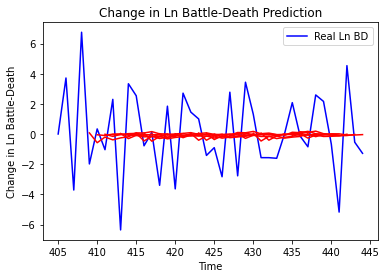

Storing forecasts...
Evaluating delta multi-step forecasts...
{'country': 'South Sudan', 'country_id': 246, 'step': 't+0', 'mse': 5.6692337380734505, 'mae': 1.9796266955075097, 'r2': -0.02237433848622139, 'tadda_score': 2.012523103076958}
{'country': 'South Sudan', 'country_id': 246, 'step': 't+1', 'mse': 7.4136834664329125, 'mae': 2.183126420566703, 'r2': -0.06500139497431978, 'tadda_score': 2.2832709645621625}
{'country': 'South Sudan', 'country_id': 246, 'step': 't+2', 'mse': 9.597629505733531, 'mae': 2.6139003783725774, 'r2': -0.05131585597896238, 'tadda_score': 2.7856874676061745}
{'country': 'South Sudan', 'country_id': 246, 'step': 't+3', 'mse': 10.375345325820861, 'mae': 2.759094662571244, 'r2': -0.13951233230673799, 'tadda_score': 3.0595465039007785}
{'country': 'South Sudan', 'country_id': 246, 'step': 't+4', 'mse': 10.123756470758053, 'mae': 2.5314620417559595, 'r2': -0.051212180806584184, 'tadda_score': 2.727193898926621}
{'country': 'South Sudan', 'country_id': 246, 'step'

In [14]:
np.random.seed(1)
tf.random.set_seed(1)
model = Sequential()
summary_model(dataset=df,
              modelname = "Vanilla",
              pred_africa=True,
              period=period_calib, 
              epochs=50, 
              batch_size=64, 
              look_back=4, 
              look_forward=7,
              num_neurons=2, 
              val_split=0.2)

# Test Period

['Cape Verde']
Building vanilla Model...
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 2)                 32        
_________________________________________________________________
dropout (Dropout)            (None, 2)                 0         
_________________________________________________________________
dense (Dense)                (None, 2)                 6         
_________________________________________________________________
dropout_1 (Dropout)          (None, 2)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 7)                 21        
Total params: 59
Trainable params: 59
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
4/4 [==============================] - 0s 67ms/step - loss: 0.0000e+00 -

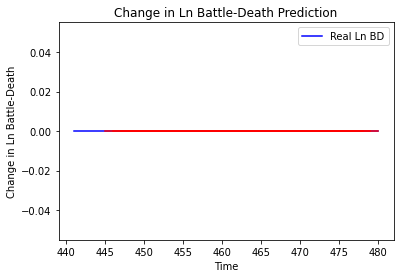

Storing forecasts...
Evaluating delta multi-step forecasts...
{'country': 'Cape Verde', 'country_id': 40, 'step': 't+0', 'mse': 0.0, 'mae': 0.0, 'r2': 1.0, 'tadda_score': 0.0}
{'country': 'Cape Verde', 'country_id': 40, 'step': 't+1', 'mse': 0.0, 'mae': 0.0, 'r2': 1.0, 'tadda_score': 0.0}
{'country': 'Cape Verde', 'country_id': 40, 'step': 't+2', 'mse': 0.0, 'mae': 0.0, 'r2': 1.0, 'tadda_score': 0.0}
{'country': 'Cape Verde', 'country_id': 40, 'step': 't+3', 'mse': 0.0, 'mae': 0.0, 'r2': 1.0, 'tadda_score': 0.0}
{'country': 'Cape Verde', 'country_id': 40, 'step': 't+4', 'mse': 0.0, 'mae': 0.0, 'r2': 1.0, 'tadda_score': 0.0}
{'country': 'Cape Verde', 'country_id': 40, 'step': 't+5', 'mse': 0.0, 'mae': 0.0, 'r2': 1.0, 'tadda_score': 0.0}
{'country': 'Cape Verde', 'country_id': 40, 'step': 't+6', 'mse': 0.0, 'mae': 0.0, 'r2': 1.0, 'tadda_score': 0.0}
["Cote d'Ivoire"]
Building vanilla Model...
Model: "sequential_2"
_________________________________________________________________
Layer (t

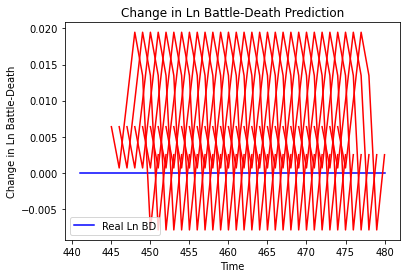

Storing forecasts...
Evaluating delta multi-step forecasts...
{'country': "Cote d'Ivoire", 'country_id': 41, 'step': 't+0', 'mse': 4.0892886772562554e-05, 'mae': 0.006394754629582167, 'r2': 0.0, 'tadda_score': 0.006394754629582167}
{'country': "Cote d'Ivoire", 'country_id': 41, 'step': 't+1', 'mse': 5.008888700250378e-05, 'mae': 0.007077350281178951, 'r2': 0.0, 'tadda_score': 0.007077350281178951}
{'country': "Cote d'Ivoire", 'country_id': 41, 'step': 't+2', 'mse': 0.00029172479804363827, 'mae': 0.017079953104257584, 'r2': 0.0, 'tadda_score': 0.017079953104257584}
{'country': "Cote d'Ivoire", 'country_id': 41, 'step': 't+3', 'mse': 0.001336172404140648, 'mae': 0.03655369207262993, 'r2': 0.0, 'tadda_score': 0.03655369207262993}
{'country': "Cote d'Ivoire", 'country_id': 41, 'step': 't+4', 'mse': 0.0024361734636022536, 'mae': 0.04935760796070099, 'r2': 0.0, 'tadda_score': 0.04935760796070099}
{'country': "Cote d'Ivoire", 'country_id': 41, 'step': 't+5', 'mse': 0.001718655451754536, 'mae'

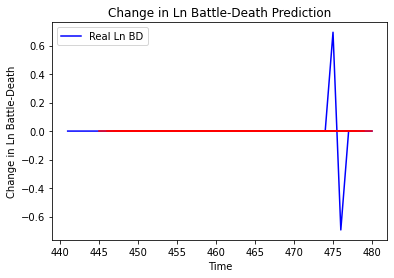

Storing forecasts...
Evaluating delta multi-step forecasts...
{'country': 'Ghana', 'country_id': 42, 'step': 't+0', 'mse': 0.0, 'mae': 0.0, 'r2': 1.0, 'tadda_score': 0.0}
{'country': 'Ghana', 'country_id': 42, 'step': 't+1', 'mse': 0.0, 'mae': 0.0, 'r2': 1.0, 'tadda_score': 0.0}
{'country': 'Ghana', 'country_id': 42, 'step': 't+2', 'mse': 0.0, 'mae': 0.0, 'r2': 1.0, 'tadda_score': 0.0}
{'country': 'Ghana', 'country_id': 42, 'step': 't+3', 'mse': 0.0, 'mae': 0.0, 'r2': 1.0, 'tadda_score': 0.0}
{'country': 'Ghana', 'country_id': 42, 'step': 't+4', 'mse': 0.0, 'mae': 0.0, 'r2': 1.0, 'tadda_score': 0.0}
{'country': 'Ghana', 'country_id': 42, 'step': 't+5', 'mse': 0.0, 'mae': 0.0, 'r2': 1.0, 'tadda_score': 0.0}
{'country': 'Ghana', 'country_id': 42, 'step': 't+6', 'mse': 0.0, 'mae': 0.0, 'r2': 1.0, 'tadda_score': 0.0}
['Liberia']
Building vanilla Model...
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape        

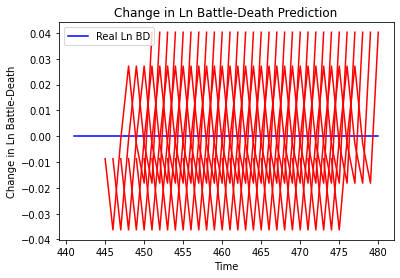

Storing forecasts...
Evaluating delta multi-step forecasts...
{'country': 'Liberia', 'country_id': 43, 'step': 't+0', 'mse': 7.542259672838406e-05, 'mae': 0.008684618398547173, 'r2': 0.0, 'tadda_score': 0.008684618398547173}
{'country': 'Liberia', 'country_id': 43, 'step': 't+1', 'mse': 0.002022976939763943, 'mae': 0.04497751593589783, 'r2': 0.0, 'tadda_score': 0.04497751593589783}
{'country': 'Liberia', 'country_id': 43, 'step': 't+2', 'mse': 0.0021399123968817713, 'mae': 0.046259187161922455, 'r2': 0.0, 'tadda_score': 0.046259187161922455}
{'country': 'Liberia', 'country_id': 43, 'step': 't+3', 'mse': 0.00036327844635242537, 'mae': 0.019059864804148674, 'r2': 0.0, 'tadda_score': 0.019059864804148674}
{'country': 'Liberia', 'country_id': 43, 'step': 't+4', 'mse': 0.00020553305162846272, 'mae': 0.014336423948407173, 'r2': 0.0, 'tadda_score': 0.014336423948407173}
{'country': 'Liberia', 'country_id': 43, 'step': 't+5', 'mse': 1.4618740155240145e-05, 'mae': 0.003823446109890938, 'r2': 0.

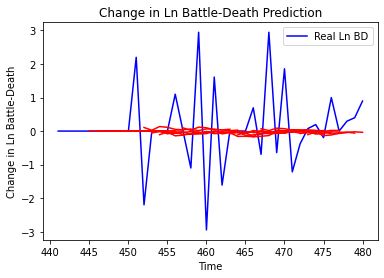

Storing forecasts...
Evaluating delta multi-step forecasts...
{'country': 'Burkina Faso', 'country_id': 47, 'step': 't+0', 'mse': 1.706212315322928, 'mae': 0.8503295860873339, 'r2': -0.034643640132711706, 'tadda_score': 0.8749251070431547}
{'country': 'Burkina Faso', 'country_id': 47, 'step': 't+1', 'mse': 1.2065009094536052, 'mae': 0.748429861113917, 'r2': -0.0195435843830003, 'tadda_score': 0.7644215079103819}
{'country': 'Burkina Faso', 'country_id': 47, 'step': 't+2', 'mse': 2.0044622121008984, 'mae': 0.9235017732416152, 'r2': -0.005441219826363364, 'tadda_score': 0.9550029424959977}
{'country': 'Burkina Faso', 'country_id': 47, 'step': 't+3', 'mse': 2.332484311366327, 'mae': 1.0644392156725637, 'r2': -0.050748068458287054, 'tadda_score': 1.114611642472497}
{'country': 'Burkina Faso', 'country_id': 47, 'step': 't+4', 'mse': 2.3372972582674985, 'mae': 0.9765523585992248, 'r2': -0.12123089028680534, 'tadda_score': 1.0174654300825985}
{'country': 'Burkina Faso', 'country_id': 47, 'ste

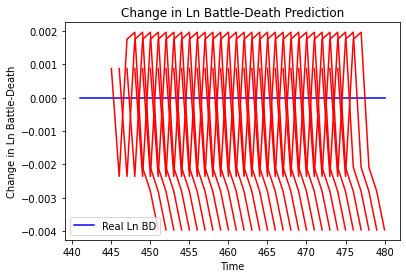

Storing forecasts...
Evaluating delta multi-step forecasts...
{'country': 'Guinea', 'country_id': 48, 'step': 't+0', 'mse': 7.68273643465072e-07, 'mae': 0.0008765122038312256, 'r2': 0.0, 'tadda_score': 0.0008765122038312256}
{'country': 'Guinea', 'country_id': 48, 'step': 't+1', 'mse': 2.1990807963796614e-06, 'mae': 0.001482929801568389, 'r2': 0.0, 'tadda_score': 0.001482929801568389}
{'country': 'Guinea', 'country_id': 48, 'step': 't+2', 'mse': 7.274861727196854e-08, 'mae': 0.00026971951592713594, 'r2': 0.0, 'tadda_score': 0.00026971951592713594}
{'country': 'Guinea', 'country_id': 48, 'step': 't+3', 'mse': 4.984650404861674e-06, 'mae': 0.00223263306543231, 'r2': 0.0, 'tadda_score': 0.00223263306543231}
{'country': 'Guinea', 'country_id': 48, 'step': 't+4', 'mse': 6.263821195271781e-06, 'mae': 0.0025027627125382423, 'r2': 0.0, 'tadda_score': 0.0025027627125382423}
{'country': 'Guinea', 'country_id': 48, 'step': 't+5', 'mse': 9.248791878213071e-08, 'mae': 0.0003041182644665241, 'r2': 0

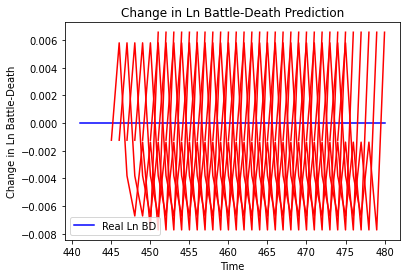

Storing forecasts...
Evaluating delta multi-step forecasts...
{'country': 'Guinea-Bissau', 'country_id': 49, 'step': 't+0', 'mse': 1.5339843336562107e-06, 'mae': 0.0012385412119328976, 'r2': 0.0, 'tadda_score': 0.0012385412119328976}
{'country': 'Guinea-Bissau', 'country_id': 49, 'step': 't+1', 'mse': 2.0829031804073467e-05, 'mae': 0.004563883412629366, 'r2': 0.0, 'tadda_score': 0.004563883412629366}
{'country': 'Guinea-Bissau', 'country_id': 49, 'step': 't+2', 'mse': 5.634659145574514e-07, 'mae': 0.0007506436668336391, 'r2': 0.0, 'tadda_score': 0.0007506436668336391}
{'country': 'Guinea-Bissau', 'country_id': 49, 'step': 't+3', 'mse': 3.560431139824579e-05, 'mae': 0.0059669348411262035, 'r2': 0.0, 'tadda_score': 0.0059669348411262035}
{'country': 'Guinea-Bissau', 'country_id': 49, 'step': 't+4', 'mse': 0.00017294836675556344, 'mae': 0.013150983490049839, 'r2': 0.0, 'tadda_score': 0.013150983490049839}
{'country': 'Guinea-Bissau', 'country_id': 49, 'step': 't+5', 'mse': 0.0004359433925

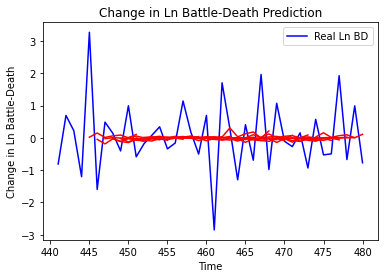

Storing forecasts...
Evaluating delta multi-step forecasts...
{'country': 'Mali', 'country_id': 50, 'step': 't+0', 'mse': 1.2505820383699568, 'mae': 0.8072755133620874, 'r2': 0.009373459884858937, 'tadda_score': 0.8119347114934996}
{'country': 'Mali', 'country_id': 50, 'step': 't+1', 'mse': 1.043443835688947, 'mae': 0.8160131370228576, 'r2': -0.0777386034273082, 'tadda_score': 0.8765479819118528}
{'country': 'Mali', 'country_id': 50, 'step': 't+2', 'mse': 1.171254375960295, 'mae': 0.8535315323038444, 'r2': -0.03168765087593117, 'tadda_score': 0.9216849707881406}
{'country': 'Mali', 'country_id': 50, 'step': 't+3', 'mse': 1.5921724681001408, 'mae': 1.0219296721922495, 'r2': -0.06468752632896013, 'tadda_score': 1.1081540947340072}
{'country': 'Mali', 'country_id': 50, 'step': 't+4', 'mse': 1.301507778923192, 'mae': 0.9620231106795903, 'r2': -0.20200464153550168, 'tadda_score': 1.0469999193442898}
{'country': 'Mali', 'country_id': 50, 'step': 't+5', 'mse': 1.6802761168794333, 'mae': 1.070

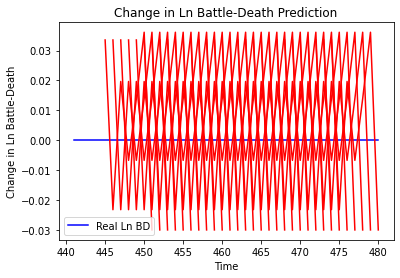

Storing forecasts...
Evaluating delta multi-step forecasts...
{'country': 'Senegal', 'country_id': 52, 'step': 't+0', 'mse': 0.0011235765429967876, 'mae': 0.033519793301820755, 'r2': 0.0, 'tadda_score': 0.033519793301820755}
{'country': 'Senegal', 'country_id': 52, 'step': 't+1', 'mse': 0.00010668413730308482, 'mae': 0.010328801348805428, 'r2': 0.0, 'tadda_score': 0.010328801348805428}
{'country': 'Senegal', 'country_id': 52, 'step': 't+2', 'mse': 0.0008989805621515169, 'mae': 0.029983004555106163, 'r2': 0.0, 'tadda_score': 0.029983004555106163}
{'country': 'Senegal', 'country_id': 52, 'step': 't+3', 'mse': 0.0005420519079475973, 'mae': 0.02328200824558735, 'r2': 0.0, 'tadda_score': 0.02328200824558735}
{'country': 'Senegal', 'country_id': 52, 'step': 't+4', 'mse': 0.0036441498742176837, 'mae': 0.06036679446697235, 'r2': 0.0, 'tadda_score': 0.06036679446697235}
{'country': 'Senegal', 'country_id': 52, 'step': 't+5', 'mse': 0.009306174520230803, 'mae': 0.09646851569414139, 'r2': 0.0, 't

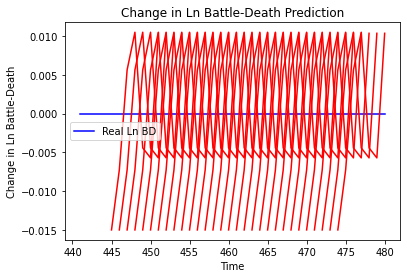

Storing forecasts...
Evaluating delta multi-step forecasts...
{'country': 'Sierra Leone', 'country_id': 53, 'step': 't+0', 'mse': 0.00022400094479716262, 'mae': 0.014966661110520363, 'r2': 0.0, 'tadda_score': 0.014966661110520363}
{'country': 'Sierra Leone', 'country_id': 53, 'step': 't+1', 'mse': 0.0004938471356104174, 'mae': 0.022222671657800674, 'r2': 0.0, 'tadda_score': 0.022222671657800674}
{'country': 'Sierra Leone', 'country_id': 53, 'step': 't+2', 'mse': 0.0002758048077430332, 'mae': 0.01660737209022045, 'r2': 0.0, 'tadda_score': 0.01660737209022045}
{'country': 'Sierra Leone', 'country_id': 53, 'step': 't+3', 'mse': 3.7804663758863634e-05, 'mae': 0.0061485497280955315, 'r2': 0.0, 'tadda_score': 0.0061485497280955315}
{'country': 'Sierra Leone', 'country_id': 53, 'step': 't+4', 'mse': 1.0956306926089045e-05, 'mae': 0.00331003125756979, 'r2': 0.0, 'tadda_score': 0.00331003125756979}
{'country': 'Sierra Leone', 'country_id': 53, 'step': 't+5', 'mse': 8.117412834560481e-05, 'mae':

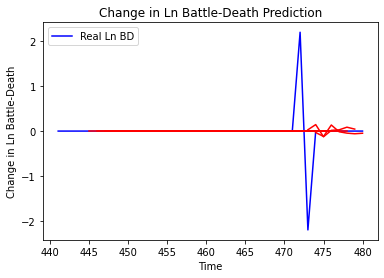

Storing forecasts...
Evaluating delta multi-step forecasts...
{'country': 'The Gambia', 'country_id': 54, 'step': 't+0', 'mse': 0.32616992729942124, 'mae': 0.14851274014802163, 'r2': -0.013412552714199943, 'tadda_score': 0.14948097438903038}
{'country': 'The Gambia', 'country_id': 54, 'step': 't+1', 'mse': 0.3013676464255681, 'mae': 0.14718909793884938, 'r2': 0.0636483308001542, 'tadda_score': 0.14718909793884938}
{'country': 'The Gambia', 'country_id': 54, 'step': 't+2', 'mse': 0.16100772418429618, 'mae': 0.07534553028042805, 'r2': -0.0350047107290663, 'tadda_score': 0.07534553028042805}
{'country': 'The Gambia', 'country_id': 54, 'step': 't+3', 'mse': 0.1610932915356636, 'mae': 0.07640862941141617, 'r2': -0.03555476267345936, 'tadda_score': 0.07640862941141617}
{'country': 'The Gambia', 'country_id': 54, 'step': 't+4', 'mse': 0.16108053316729926, 'mae': 0.07642459141111067, 'r2': -0.035472748152570954, 'tadda_score': 0.07642459141111067}
{'country': 'The Gambia', 'country_id': 54, 's

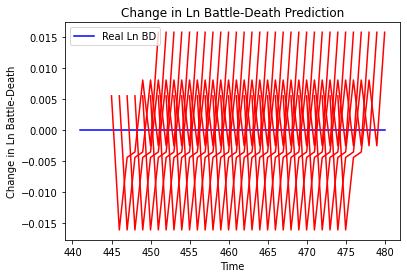

Storing forecasts...
Evaluating delta multi-step forecasts...
{'country': 'Djibouti', 'country_id': 55, 'step': 't+0', 'mse': 3.0996598869381534e-05, 'mae': 0.005567458923906088, 'r2': 0.0, 'tadda_score': 0.005567458923906088}
{'country': 'Djibouti', 'country_id': 55, 'step': 't+1', 'mse': 0.00011094960929160236, 'mae': 0.01053326204419136, 'r2': 0.0, 'tadda_score': 0.01053326204419136}
{'country': 'Djibouti', 'country_id': 55, 'step': 't+2', 'mse': 0.00022261434781001635, 'mae': 0.014920266345143318, 'r2': 0.0, 'tadda_score': 0.014920266345143318}
{'country': 'Djibouti', 'country_id': 55, 'step': 't+3', 'mse': 0.00033962693998969284, 'mae': 0.018428970128297806, 'r2': 0.0, 'tadda_score': 0.018428970128297806}
{'country': 'Djibouti', 'country_id': 55, 'step': 't+4', 'mse': 3.3615107449678355e-05, 'mae': 0.005797853693366051, 'r2': 0.0, 'tadda_score': 0.005797853693366051}
{'country': 'Djibouti', 'country_id': 55, 'step': 't+5', 'mse': 1.0875274227474746e-05, 'mae': 0.003297768067568540

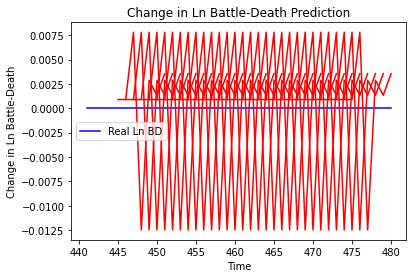

Storing forecasts...
Evaluating delta multi-step forecasts...
{'country': 'Eritrea', 'country_id': 56, 'step': 't+0', 'mse': 8.090131990312525e-07, 'mae': 0.0008994516101665795, 'r2': 0.0, 'tadda_score': 0.0008994516101665795}
{'country': 'Eritrea', 'country_id': 56, 'step': 't+1', 'mse': 3.2201292961971887e-06, 'mae': 0.0017944718711078167, 'r2': 0.0, 'tadda_score': 0.0017944718711078167}
{'country': 'Eritrea', 'country_id': 56, 'step': 't+2', 'mse': 9.204767632401203e-05, 'mae': 0.009594148024916649, 'r2': 0.0, 'tadda_score': 0.009594148024916649}
{'country': 'Eritrea', 'country_id': 56, 'step': 't+3', 'mse': 8.30583844936561e-06, 'mae': 0.002881985157728195, 'r2': 0.0, 'tadda_score': 0.002881985157728195}
{'country': 'Eritrea', 'country_id': 56, 'step': 't+4', 'mse': 8.042929736519857e-07, 'mae': 0.000896823825314641, 'r2': 0.0, 'tadda_score': 0.000896823825314641}
{'country': 'Eritrea', 'country_id': 56, 'step': 't+5', 'mse': 1.9055212443754238e-07, 'mae': 0.00043652276508510113, '

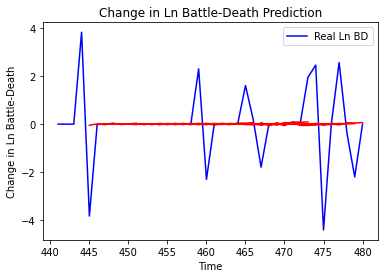

Storing forecasts...
Evaluating delta multi-step forecasts...
{'country': 'Ethiopia', 'country_id': 57, 'step': 't+0', 'mse': 1.3534336721664604, 'mae': 0.5552127940641163, 'r2': 0.007921941089606421, 'tadda_score': 0.5580340889032998}
{'country': 'Ethiopia', 'country_id': 57, 'step': 't+1', 'mse': 2.001238174463329, 'mae': 0.7240411318460311, 'r2': -0.003008483106300641, 'tadda_score': 0.7245219051459636}
{'country': 'Ethiopia', 'country_id': 57, 'step': 't+2', 'mse': 1.9932813634447315, 'mae': 0.7290126079703204, 'r2': 0.0009794225073163076, 'tadda_score': 0.7293586436436035}
{'country': 'Ethiopia', 'country_id': 57, 'step': 't+3', 'mse': 2.018204188168323, 'mae': 0.728919512329358, 'r2': -0.011511746679698343, 'tadda_score': 0.7319942400334856}
{'country': 'Ethiopia', 'country_id': 57, 'step': 't+4', 'mse': 1.9737520132575312, 'mae': 0.7390765281326281, 'r2': 0.010767414839897183, 'tadda_score': 0.7418317900902736}
{'country': 'Ethiopia', 'country_id': 57, 'step': 't+5', 'mse': 1.71

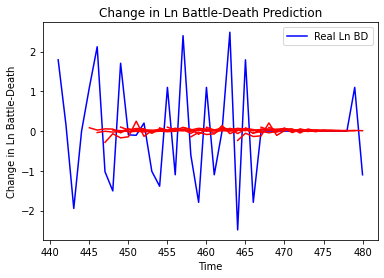

Storing forecasts...
Evaluating delta multi-step forecasts...
{'country': 'Algeria', 'country_id': 67, 'step': 't+0', 'mse': 1.4881446656719628, 'mae': 0.9091565824837978, 'r2': 0.06691751741508523, 'tadda_score': 0.9175937056955195}
{'country': 'Algeria', 'country_id': 67, 'step': 't+1', 'mse': 1.7881101264885297, 'mae': 0.9155305609704979, 'r2': -0.06169691515206699, 'tadda_score': 0.9627912461113859}
{'country': 'Algeria', 'country_id': 67, 'step': 't+2', 'mse': 1.9618388175995416, 'mae': 1.0422661969086537, 'r2': -0.09363659796193846, 'tadda_score': 1.113835711617868}
{'country': 'Algeria', 'country_id': 67, 'step': 't+3', 'mse': 2.25906012732076, 'mae': 1.196579811145368, 'r2': -0.106574861854001, 'tadda_score': 1.282650578562918}
{'country': 'Algeria', 'country_id': 67, 'step': 't+4', 'mse': 1.4457077128421871, 'mae': 0.8372057784899218, 'r2': -0.07426020165503311, 'tadda_score': 0.8820360571696503}
{'country': 'Algeria', 'country_id': 67, 'step': 't+5', 'mse': 1.8628879414539248

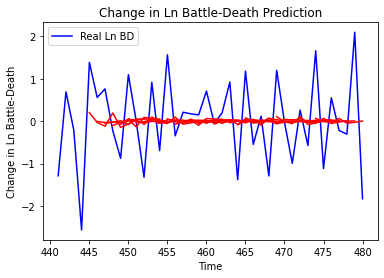

Storing forecasts...
Evaluating delta multi-step forecasts...
{'country': 'Cameroon', 'country_id': 69, 'step': 't+0', 'mse': 0.6948536744538482, 'mae': 0.682333562328508, 'r2': 0.05649184873981283, 'tadda_score': 0.6916683270357207}
{'country': 'Cameroon', 'country_id': 69, 'step': 't+1', 'mse': 0.8140025084885533, 'mae': 0.772987134464177, 'r2': -0.10279668352763216, 'tadda_score': 0.8138743102827718}
{'country': 'Cameroon', 'country_id': 69, 'step': 't+2', 'mse': 1.0441578243000254, 'mae': 0.8113776260300656, 'r2': -0.06546390457748275, 'tadda_score': 0.8283549630638639}
{'country': 'Cameroon', 'country_id': 69, 'step': 't+3', 'mse': 1.0117695615715054, 'mae': 0.8190582442586705, 'r2': -0.14883788248684282, 'tadda_score': 0.8713064622545699}
{'country': 'Cameroon', 'country_id': 69, 'step': 't+4', 'mse': 1.1102106548953081, 'mae': 0.8403001239956817, 'r2': -0.11614276294982528, 'tadda_score': 0.8655303058259959}
{'country': 'Cameroon', 'country_id': 69, 'step': 't+5', 'mse': 1.55700

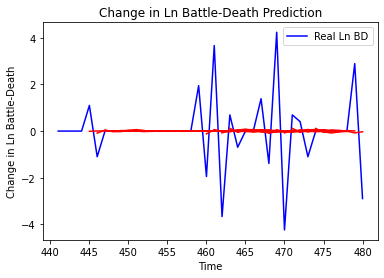

Storing forecasts...
Evaluating delta multi-step forecasts...
{'country': 'Central African Republic', 'country_id': 70, 'step': 't+0', 'mse': 2.5398881394486525, 'mae': 0.9276420007539776, 'r2': 0.03964359561998043, 'tadda_score': 0.9300513443345378}
{'country': 'Central African Republic', 'country_id': 70, 'step': 't+1', 'mse': 1.4903428696717904, 'mae': 0.6902700665936083, 'r2': -0.01801240065158405, 'tadda_score': 0.6987079153677037}
{'country': 'Central African Republic', 'country_id': 70, 'step': 't+2', 'mse': 2.3287995027339026, 'mae': 0.8852737959453343, 'r2': 0.006408339501264404, 'tadda_score': 0.8959241832275071}
{'country': 'Central African Republic', 'country_id': 70, 'step': 't+3', 'mse': 2.426365049010079, 'mae': 0.828977482351623, 'r2': -0.003606081473044309, 'tadda_score': 0.8462443108563245}
{'country': 'Central African Republic', 'country_id': 70, 'step': 't+4', 'mse': 2.5655598916121325, 'mae': 0.8749073643851255, 'r2': -0.012392876465506797, 'tadda_score': 0.8942129

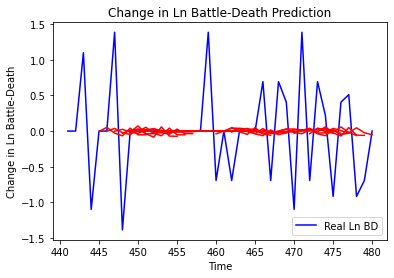

Storing forecasts...
Evaluating delta multi-step forecasts...
{'country': 'Tunisia', 'country_id': 73, 'step': 't+0', 'mse': 0.40573447690103914, 'mae': 0.4034184168427276, 'r2': 0.017212932396180824, 'tadda_score': 0.40543361670033634}
{'country': 'Tunisia', 'country_id': 73, 'step': 't+1', 'mse': 0.42738511445082883, 'mae': 0.4282026742207369, 'r2': -0.038612537448786455, 'tadda_score': 0.4367345973782103}
{'country': 'Tunisia', 'country_id': 73, 'step': 't+2', 'mse': 0.48495019338617334, 'mae': 0.4657836011063085, 'r2': -0.014955774193894822, 'tadda_score': 0.46855884443457185}
{'country': 'Tunisia', 'country_id': 73, 'step': 't+3', 'mse': 0.49941067268929384, 'mae': 0.4665163315569174, 'r2': -0.03425640118270623, 'tadda_score': 0.4736051459843727}
{'country': 'Tunisia', 'country_id': 73, 'step': 't+4', 'mse': 0.4596034327632018, 'mae': 0.4541267746667827, 'r2': -0.04469898594606825, 'tadda_score': 0.4630324108134473}
{'country': 'Tunisia', 'country_id': 73, 'step': 't+5', 'mse': 0.

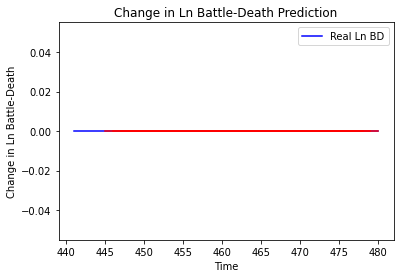

Storing forecasts...
Evaluating delta multi-step forecasts...
{'country': 'Benin', 'country_id': 74, 'step': 't+0', 'mse': 0.0, 'mae': 0.0, 'r2': 1.0, 'tadda_score': 0.0}
{'country': 'Benin', 'country_id': 74, 'step': 't+1', 'mse': 0.0, 'mae': 0.0, 'r2': 1.0, 'tadda_score': 0.0}
{'country': 'Benin', 'country_id': 74, 'step': 't+2', 'mse': 0.0, 'mae': 0.0, 'r2': 1.0, 'tadda_score': 0.0}
{'country': 'Benin', 'country_id': 74, 'step': 't+3', 'mse': 0.0, 'mae': 0.0, 'r2': 1.0, 'tadda_score': 0.0}
{'country': 'Benin', 'country_id': 74, 'step': 't+4', 'mse': 0.0, 'mae': 0.0, 'r2': 1.0, 'tadda_score': 0.0}
{'country': 'Benin', 'country_id': 74, 'step': 't+5', 'mse': 0.0, 'mae': 0.0, 'r2': 1.0, 'tadda_score': 0.0}
{'country': 'Benin', 'country_id': 74, 'step': 't+6', 'mse': 0.0, 'mae': 0.0, 'r2': 1.0, 'tadda_score': 0.0}
['Equatorial Guinea']
Building vanilla Model...
Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Sh

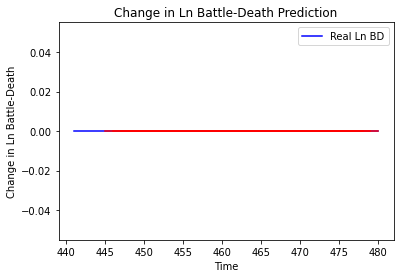

Storing forecasts...
Evaluating delta multi-step forecasts...
{'country': 'Equatorial Guinea', 'country_id': 76, 'step': 't+0', 'mse': 0.0, 'mae': 0.0, 'r2': 1.0, 'tadda_score': 0.0}
{'country': 'Equatorial Guinea', 'country_id': 76, 'step': 't+1', 'mse': 0.0, 'mae': 0.0, 'r2': 1.0, 'tadda_score': 0.0}
{'country': 'Equatorial Guinea', 'country_id': 76, 'step': 't+2', 'mse': 0.0, 'mae': 0.0, 'r2': 1.0, 'tadda_score': 0.0}
{'country': 'Equatorial Guinea', 'country_id': 76, 'step': 't+3', 'mse': 0.0, 'mae': 0.0, 'r2': 1.0, 'tadda_score': 0.0}
{'country': 'Equatorial Guinea', 'country_id': 76, 'step': 't+4', 'mse': 0.0, 'mae': 0.0, 'r2': 1.0, 'tadda_score': 0.0}
{'country': 'Equatorial Guinea', 'country_id': 76, 'step': 't+5', 'mse': 0.0, 'mae': 0.0, 'r2': 1.0, 'tadda_score': 0.0}
{'country': 'Equatorial Guinea', 'country_id': 76, 'step': 't+6', 'mse': 0.0, 'mae': 0.0, 'r2': 1.0, 'tadda_score': 0.0}
['Niger']
Building vanilla Model...
Model: "sequential_21"
________________________________

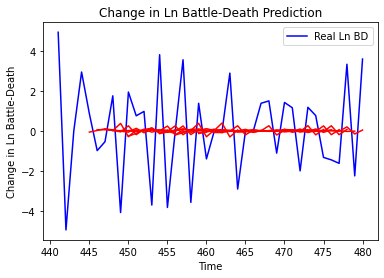

Storing forecasts...
Evaluating delta multi-step forecasts...
{'country': 'Niger', 'country_id': 78, 'step': 't+0', 'mse': 4.403184759798552, 'mae': 1.6721094185857388, 'r2': -0.016463335496949005, 'tadda_score': 1.7036642881481263}
{'country': 'Niger', 'country_id': 78, 'step': 't+1', 'mse': 3.8192730330592792, 'mae': 1.522079096472944, 'r2': 0.027384619780649433, 'tadda_score': 1.5481210841354582}
{'country': 'Niger', 'country_id': 78, 'step': 't+2', 'mse': 3.8913469327561376, 'mae': 1.5060360119006702, 'r2': -0.004728161693552391, 'tadda_score': 1.5394916083923647}
{'country': 'Niger', 'country_id': 78, 'step': 't+3', 'mse': 4.549630159274475, 'mae': 1.6947885500174205, 'r2': -0.0027334712645934456, 'tadda_score': 1.7221897210522432}
{'country': 'Niger', 'country_id': 78, 'step': 't+4', 'mse': 5.474451640046637, 'mae': 1.904030965834304, 'r2': 0.004795008775060672, 'tadda_score': 1.9757048483386082}
{'country': 'Niger', 'country_id': 78, 'step': 't+5', 'mse': 4.768879534189218, 'mae

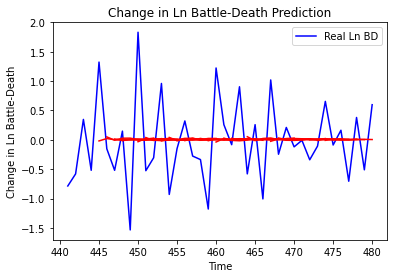

Storing forecasts...
Evaluating delta multi-step forecasts...
{'country': 'Nigeria', 'country_id': 79, 'step': 't+0', 'mse': 0.5912802299964691, 'mae': 0.5964184853699661, 'r2': -0.034599729190489814, 'tadda_score': 0.6120370967493375}
{'country': 'Nigeria', 'country_id': 79, 'step': 't+1', 'mse': 0.532388781203305, 'mae': 0.5694853926755875, 'r2': 0.016044908659033297, 'tadda_score': 0.5734947555445521}
{'country': 'Nigeria', 'country_id': 79, 'step': 't+2', 'mse': 0.6094079699796399, 'mae': 0.6037532044269196, 'r2': 0.005356547662051625, 'tadda_score': 0.6159235776717515}
{'country': 'Nigeria', 'country_id': 79, 'step': 't+3', 'mse': 0.7400544944493836, 'mae': 0.6171345983742558, 'r2': 0.005137112491650608, 'tadda_score': 0.6308358755849434}
{'country': 'Nigeria', 'country_id': 79, 'step': 't+4', 'mse': 0.4969613897943153, 'mae': 0.5644076145294546, 'r2': 0.029302300745700283, 'tadda_score': 0.582032779899282}
{'country': 'Nigeria', 'country_id': 79, 'step': 't+5', 'mse': 0.689737444

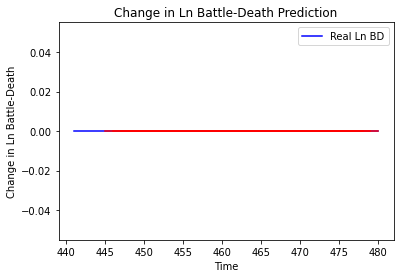

Storing forecasts...
Evaluating delta multi-step forecasts...
{'country': 'Sao Tome and Principe', 'country_id': 80, 'step': 't+0', 'mse': 0.0, 'mae': 0.0, 'r2': 1.0, 'tadda_score': 0.0}
{'country': 'Sao Tome and Principe', 'country_id': 80, 'step': 't+1', 'mse': 0.0, 'mae': 0.0, 'r2': 1.0, 'tadda_score': 0.0}
{'country': 'Sao Tome and Principe', 'country_id': 80, 'step': 't+2', 'mse': 0.0, 'mae': 0.0, 'r2': 1.0, 'tadda_score': 0.0}
{'country': 'Sao Tome and Principe', 'country_id': 80, 'step': 't+3', 'mse': 0.0, 'mae': 0.0, 'r2': 1.0, 'tadda_score': 0.0}
{'country': 'Sao Tome and Principe', 'country_id': 80, 'step': 't+4', 'mse': 0.0, 'mae': 0.0, 'r2': 1.0, 'tadda_score': 0.0}
{'country': 'Sao Tome and Principe', 'country_id': 80, 'step': 't+5', 'mse': 0.0, 'mae': 0.0, 'r2': 1.0, 'tadda_score': 0.0}
{'country': 'Sao Tome and Principe', 'country_id': 80, 'step': 't+6', 'mse': 0.0, 'mae': 0.0, 'r2': 1.0, 'tadda_score': 0.0}
['Togo']
Building vanilla Model...
Model: "sequential_24"
_____

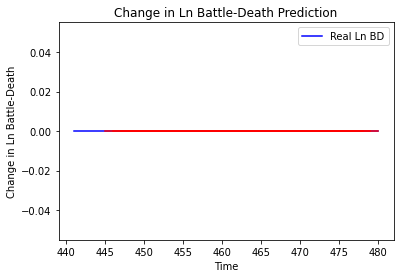

Storing forecasts...
Evaluating delta multi-step forecasts...
{'country': 'Togo', 'country_id': 81, 'step': 't+0', 'mse': 0.0, 'mae': 0.0, 'r2': 1.0, 'tadda_score': 0.0}
{'country': 'Togo', 'country_id': 81, 'step': 't+1', 'mse': 0.0, 'mae': 0.0, 'r2': 1.0, 'tadda_score': 0.0}
{'country': 'Togo', 'country_id': 81, 'step': 't+2', 'mse': 0.0, 'mae': 0.0, 'r2': 1.0, 'tadda_score': 0.0}
{'country': 'Togo', 'country_id': 81, 'step': 't+3', 'mse': 0.0, 'mae': 0.0, 'r2': 1.0, 'tadda_score': 0.0}
{'country': 'Togo', 'country_id': 81, 'step': 't+4', 'mse': 0.0, 'mae': 0.0, 'r2': 1.0, 'tadda_score': 0.0}
{'country': 'Togo', 'country_id': 81, 'step': 't+5', 'mse': 0.0, 'mae': 0.0, 'r2': 1.0, 'tadda_score': 0.0}
{'country': 'Togo', 'country_id': 81, 'step': 't+6', 'mse': 0.0, 'mae': 0.0, 'r2': 1.0, 'tadda_score': 0.0}
['Somalia']
Building vanilla Model...
Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              

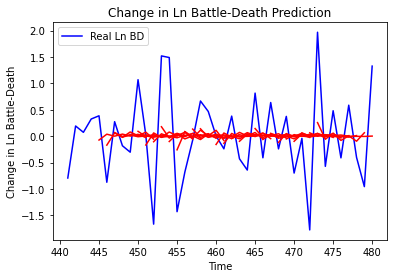

Storing forecasts...
Evaluating delta multi-step forecasts...
{'country': 'Somalia', 'country_id': 120, 'step': 't+0', 'mse': 0.6698932243190048, 'mae': 0.6456081822047054, 'r2': 0.12062766884902998, 'tadda_score': 0.6802091411157866}
{'country': 'Somalia', 'country_id': 120, 'step': 't+1', 'mse': 1.0188894330651508, 'mae': 0.7232282347081792, 'r2': -0.03901320349253723, 'tadda_score': 0.7635655821957879}
{'country': 'Somalia', 'country_id': 120, 'step': 't+2', 'mse': 0.8891533138753822, 'mae': 0.7070887206315876, 'r2': -0.11409665161099447, 'tadda_score': 0.770136305957524}
{'country': 'Somalia', 'country_id': 120, 'step': 't+3', 'mse': 0.7292942059925763, 'mae': 0.6985503552971671, 'r2': -0.05210140582628742, 'tadda_score': 0.7297041855621725}
{'country': 'Somalia', 'country_id': 120, 'step': 't+4', 'mse': 0.8161717281476146, 'mae': 0.6541281519404476, 'r2': -0.0587321290053302, 'tadda_score': 0.7099471446383917}
{'country': 'Somalia', 'country_id': 120, 'step': 't+5', 'mse': 0.66842

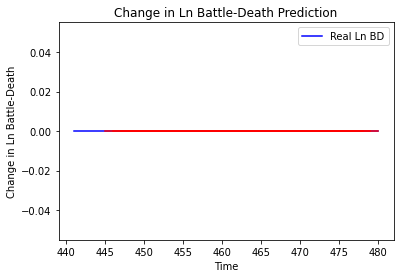

Storing forecasts...
Evaluating delta multi-step forecasts...
{'country': 'Botswana', 'country_id': 154, 'step': 't+0', 'mse': 0.0, 'mae': 0.0, 'r2': 1.0, 'tadda_score': 0.0}
{'country': 'Botswana', 'country_id': 154, 'step': 't+1', 'mse': 0.0, 'mae': 0.0, 'r2': 1.0, 'tadda_score': 0.0}
{'country': 'Botswana', 'country_id': 154, 'step': 't+2', 'mse': 0.0, 'mae': 0.0, 'r2': 1.0, 'tadda_score': 0.0}
{'country': 'Botswana', 'country_id': 154, 'step': 't+3', 'mse': 0.0, 'mae': 0.0, 'r2': 1.0, 'tadda_score': 0.0}
{'country': 'Botswana', 'country_id': 154, 'step': 't+4', 'mse': 0.0, 'mae': 0.0, 'r2': 1.0, 'tadda_score': 0.0}
{'country': 'Botswana', 'country_id': 154, 'step': 't+5', 'mse': 0.0, 'mae': 0.0, 'r2': 1.0, 'tadda_score': 0.0}
{'country': 'Botswana', 'country_id': 154, 'step': 't+6', 'mse': 0.0, 'mae': 0.0, 'r2': 1.0, 'tadda_score': 0.0}
['Burundi']
Building vanilla Model...
Model: "sequential_27"
_________________________________________________________________
Layer (type)        

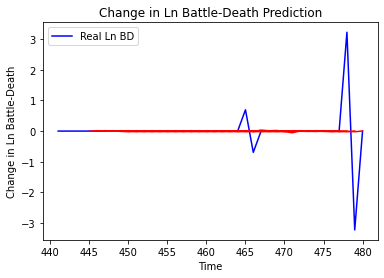

Storing forecasts...
Evaluating delta multi-step forecasts...
{'country': 'Burundi', 'country_id': 155, 'step': 't+0', 'mse': 0.03152086792428738, 'mae': 0.05070589269852222, 'r2': 0.015901648720204498, 'tadda_score': 0.05089840337664466}
{'country': 'Burundi', 'country_id': 155, 'step': 't+1', 'mse': 0.031894939492390736, 'mae': 0.05257652229349396, 'r2': 0.004222934342307472, 'tadda_score': 0.05267415257511617}
{'country': 'Burundi', 'country_id': 155, 'step': 't+2', 'mse': 0.03192923539848445, 'mae': 0.057432382504449105, 'r2': 0.003152197815523672, 'tadda_score': 0.05765679282787523}
{'country': 'Burundi', 'country_id': 155, 'step': 't+3', 'mse': 0.03209829044586696, 'mae': 0.06311110555845581, 'r2': -0.0021257911600425228, 'tadda_score': 0.06351095419097028}
{'country': 'Burundi', 'country_id': 155, 'step': 't+4', 'mse': 0.03204092800752217, 'mae': 0.049269843874803, 'r2': -0.00033490516235690215, 'tadda_score': 0.04937646312669497}
{'country': 'Burundi', 'country_id': 155, 'step'

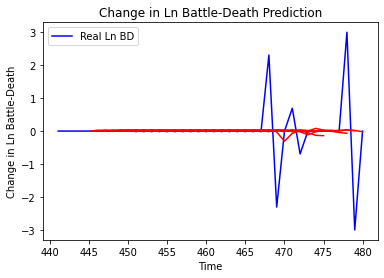

Storing forecasts...
Evaluating delta multi-step forecasts...
{'country': 'Rwanda', 'country_id': 156, 'step': 't+0', 'mse': 0.38166354381581985, 'mae': 0.204692626278632, 'r2': 0.009926406391533638, 'tadda_score': 0.20515762021122683}
{'country': 'Rwanda', 'country_id': 156, 'step': 't+1', 'mse': 0.39470069493379534, 'mae': 0.23313880610102972, 'r2': -0.023893273970758244, 'tadda_score': 0.23699897624685923}
{'country': 'Rwanda', 'country_id': 156, 'step': 't+2', 'mse': 0.28158315394813294, 'mae': 0.20965351680707414, 'r2': -0.008940201237907841, 'tadda_score': 0.2110246183454144}
{'country': 'Rwanda', 'country_id': 156, 'step': 't+3', 'mse': 0.34931651605464453, 'mae': 0.22286151378378788, 'r2': 0.053191741846275065, 'tadda_score': 0.22316996297762312}
{'country': 'Rwanda', 'country_id': 156, 'step': 't+4', 'mse': 0.3717725632726911, 'mae': 0.22421205553810317, 'r2': -0.007674463942318299, 'tadda_score': 0.2259362040797921}
{'country': 'Rwanda', 'country_id': 156, 'step': 't+5', 'mse

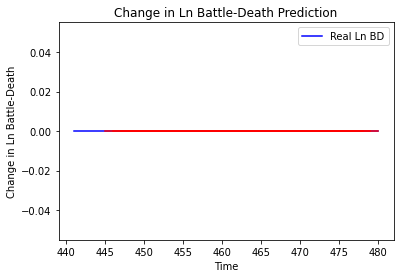

Storing forecasts...
Evaluating delta multi-step forecasts...
{'country': 'Zambia', 'country_id': 157, 'step': 't+0', 'mse': 0.0, 'mae': 0.0, 'r2': 1.0, 'tadda_score': 0.0}
{'country': 'Zambia', 'country_id': 157, 'step': 't+1', 'mse': 0.0, 'mae': 0.0, 'r2': 1.0, 'tadda_score': 0.0}
{'country': 'Zambia', 'country_id': 157, 'step': 't+2', 'mse': 0.0, 'mae': 0.0, 'r2': 1.0, 'tadda_score': 0.0}
{'country': 'Zambia', 'country_id': 157, 'step': 't+3', 'mse': 0.0, 'mae': 0.0, 'r2': 1.0, 'tadda_score': 0.0}
{'country': 'Zambia', 'country_id': 157, 'step': 't+4', 'mse': 0.0, 'mae': 0.0, 'r2': 1.0, 'tadda_score': 0.0}
{'country': 'Zambia', 'country_id': 157, 'step': 't+5', 'mse': 0.0, 'mae': 0.0, 'r2': 1.0, 'tadda_score': 0.0}
{'country': 'Zambia', 'country_id': 157, 'step': 't+6', 'mse': 0.0, 'mae': 0.0, 'r2': 1.0, 'tadda_score': 0.0}
['Zimbabwe']
Building vanilla Model...
Model: "sequential_30"
_________________________________________________________________
Layer (type)                 Outp

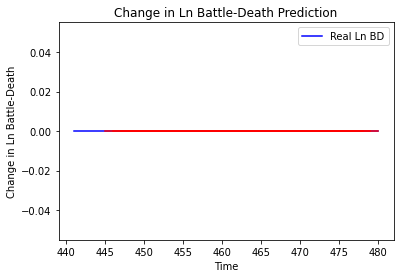

Storing forecasts...
Evaluating delta multi-step forecasts...
{'country': 'Zimbabwe', 'country_id': 158, 'step': 't+0', 'mse': 0.0, 'mae': 0.0, 'r2': 1.0, 'tadda_score': 0.0}
{'country': 'Zimbabwe', 'country_id': 158, 'step': 't+1', 'mse': 0.0, 'mae': 0.0, 'r2': 1.0, 'tadda_score': 0.0}
{'country': 'Zimbabwe', 'country_id': 158, 'step': 't+2', 'mse': 0.0, 'mae': 0.0, 'r2': 1.0, 'tadda_score': 0.0}
{'country': 'Zimbabwe', 'country_id': 158, 'step': 't+3', 'mse': 0.0, 'mae': 0.0, 'r2': 1.0, 'tadda_score': 0.0}
{'country': 'Zimbabwe', 'country_id': 158, 'step': 't+4', 'mse': 0.0, 'mae': 0.0, 'r2': 1.0, 'tadda_score': 0.0}
{'country': 'Zimbabwe', 'country_id': 158, 'step': 't+5', 'mse': 0.0, 'mae': 0.0, 'r2': 1.0, 'tadda_score': 0.0}
{'country': 'Zimbabwe', 'country_id': 158, 'step': 't+6', 'mse': 0.0, 'mae': 0.0, 'r2': 1.0, 'tadda_score': 0.0}
['Comoros']
Building vanilla Model...
Model: "sequential_31"
_________________________________________________________________
Layer (type)        

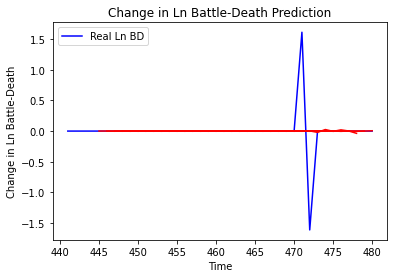

Storing forecasts...
Evaluating delta multi-step forecasts...
{'country': 'Comoros', 'country_id': 159, 'step': 't+0', 'mse': 0.17292326872117705, 'mae': 0.10785055415428511, 'r2': -0.0013738370206255457, 'tadda_score': 0.10794137988273632}
{'country': 'Comoros', 'country_id': 159, 'step': 't+1', 'mse': 0.17255926223600104, 'mae': 0.10896481911918726, 'r2': 0.0007340723050349718, 'tadda_score': 0.10896481911918726}
{'country': 'Comoros', 'country_id': 159, 'step': 't+2', 'mse': 0.1726491514684118, 'mae': 0.10925310669850205, 'r2': 0.0002135366580299225, 'tadda_score': 0.10931852117408955}
{'country': 'Comoros', 'country_id': 159, 'step': 't+3', 'mse': 0.0864225188299987, 'mae': 0.05442324714849216, 'r2': -0.035435322934928015, 'tadda_score': 0.05444774202262806}
{'country': 'Comoros', 'country_id': 159, 'step': 't+4', 'mse': 0.08690486557328782, 'mae': 0.059384043024596544, 'r2': -0.04121435903183501, 'tadda_score': 0.0595330899336606}
{'country': 'Comoros', 'country_id': 159, 'step': 

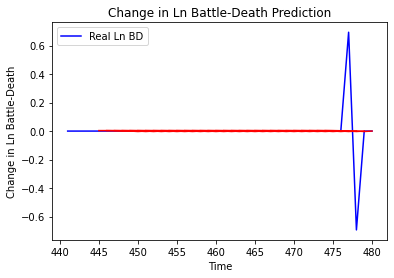

Storing forecasts...
Evaluating delta multi-step forecasts...
{'country': 'Lesotho', 'country_id': 160, 'step': 't+0', 'mse': 1.186122040898463e-05, 'mae': 0.0034440122544765472, 'r2': 0.0, 'tadda_score': 0.0034440122544765472}
{'country': 'Lesotho', 'country_id': 160, 'step': 't+1', 'mse': 4.7430776159481736e-05, 'mae': 0.006887000519782305, 'r2': 0.0, 'tadda_score': 0.006887000519782305}
{'country': 'Lesotho', 'country_id': 160, 'step': 't+2', 'mse': 8.683664336562105e-05, 'mae': 0.009318618103861809, 'r2': 0.0, 'tadda_score': 0.009318618103861809}
{'country': 'Lesotho', 'country_id': 160, 'step': 't+3', 'mse': 9.841928115422727e-05, 'mae': 0.009920649230480194, 'r2': 0.0, 'tadda_score': 0.009920649230480194}
{'country': 'Lesotho', 'country_id': 160, 'step': 't+4', 'mse': 4.771276306001285e-05, 'mae': 0.006907442584633827, 'r2': 0.0, 'tadda_score': 0.006907442584633827}
{'country': 'Lesotho', 'country_id': 160, 'step': 't+5', 'mse': 1.535436243562619e-05, 'mae': 0.003918464295566082,

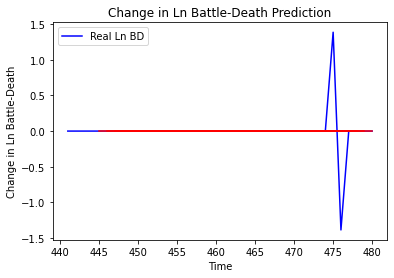

Storing forecasts...
Evaluating delta multi-step forecasts...
{'country': 'Malawi', 'country_id': 161, 'step': 't+0', 'mse': 0.0, 'mae': 0.0, 'r2': 1.0, 'tadda_score': 0.0}
{'country': 'Malawi', 'country_id': 161, 'step': 't+1', 'mse': 0.0, 'mae': 0.0, 'r2': 1.0, 'tadda_score': 0.0}
{'country': 'Malawi', 'country_id': 161, 'step': 't+2', 'mse': 0.0, 'mae': 0.0, 'r2': 1.0, 'tadda_score': 0.0}
{'country': 'Malawi', 'country_id': 161, 'step': 't+3', 'mse': 0.0, 'mae': 0.0, 'r2': 1.0, 'tadda_score': 0.0}
{'country': 'Malawi', 'country_id': 161, 'step': 't+4', 'mse': 0.0, 'mae': 0.0, 'r2': 1.0, 'tadda_score': 0.0}
{'country': 'Malawi', 'country_id': 161, 'step': 't+5', 'mse': 0.0, 'mae': 0.0, 'r2': 1.0, 'tadda_score': 0.0}
{'country': 'Malawi', 'country_id': 161, 'step': 't+6', 'mse': 0.0, 'mae': 0.0, 'r2': 1.0, 'tadda_score': 0.0}
['Mozambique']
Building vanilla Model...
Model: "sequential_34"
_________________________________________________________________
Layer (type)                 Ou

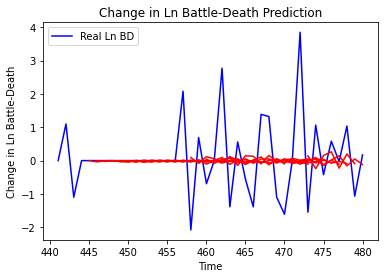

Storing forecasts...
Evaluating delta multi-step forecasts...
{'country': 'Mozambique', 'country_id': 162, 'step': 't+0', 'mse': 1.6439281985449654, 'mae': 0.8225237542150268, 'r2': -0.04472350317285456, 'tadda_score': 0.842617234184876}
{'country': 'Mozambique', 'country_id': 162, 'step': 't+1', 'mse': 1.9588996912416963, 'mae': 0.836206067288612, 'r2': -0.023822001489294697, 'tadda_score': 0.8463608396832591}
{'country': 'Mozambique', 'country_id': 162, 'step': 't+2', 'mse': 2.000014248730366, 'mae': 0.9964913037018459, 'r2': -0.04503355605973769, 'tadda_score': 1.013457884177216}
{'country': 'Mozambique', 'country_id': 162, 'step': 't+3', 'mse': 1.5696315859736951, 'mae': 0.7810196604121686, 'r2': -0.04154065426296927, 'tadda_score': 0.789443643593685}
{'country': 'Mozambique', 'country_id': 162, 'step': 't+4', 'mse': 0.8833883863738792, 'mae': 0.6145030057251026, 'r2': -0.07862364184523529, 'tadda_score': 0.6380693871100316}
{'country': 'Mozambique', 'country_id': 162, 'step': 't+5

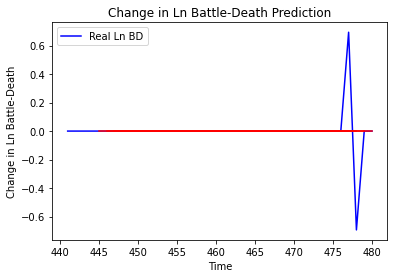

Storing forecasts...
Evaluating delta multi-step forecasts...
{'country': 'South Africa', 'country_id': 163, 'step': 't+0', 'mse': 0.0, 'mae': 0.0, 'r2': 1.0, 'tadda_score': 0.0}
{'country': 'South Africa', 'country_id': 163, 'step': 't+1', 'mse': 0.0, 'mae': 0.0, 'r2': 1.0, 'tadda_score': 0.0}
{'country': 'South Africa', 'country_id': 163, 'step': 't+2', 'mse': 0.0, 'mae': 0.0, 'r2': 1.0, 'tadda_score': 0.0}
{'country': 'South Africa', 'country_id': 163, 'step': 't+3', 'mse': 0.0, 'mae': 0.0, 'r2': 1.0, 'tadda_score': 0.0}
{'country': 'South Africa', 'country_id': 163, 'step': 't+4', 'mse': 0.0, 'mae': 0.0, 'r2': 1.0, 'tadda_score': 0.0}
{'country': 'South Africa', 'country_id': 163, 'step': 't+5', 'mse': 0.0, 'mae': 0.0, 'r2': 1.0, 'tadda_score': 0.0}
{'country': 'South Africa', 'country_id': 163, 'step': 't+6', 'mse': 0.0, 'mae': 0.0, 'r2': 1.0, 'tadda_score': 0.0}
['Swaziland']
Building vanilla Model...
Model: "sequential_36"
________________________________________________________

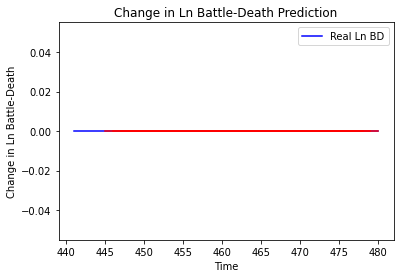

Storing forecasts...
Evaluating delta multi-step forecasts...
{'country': 'Swaziland', 'country_id': 164, 'step': 't+0', 'mse': 0.0, 'mae': 0.0, 'r2': 1.0, 'tadda_score': 0.0}
{'country': 'Swaziland', 'country_id': 164, 'step': 't+1', 'mse': 0.0, 'mae': 0.0, 'r2': 1.0, 'tadda_score': 0.0}
{'country': 'Swaziland', 'country_id': 164, 'step': 't+2', 'mse': 0.0, 'mae': 0.0, 'r2': 1.0, 'tadda_score': 0.0}
{'country': 'Swaziland', 'country_id': 164, 'step': 't+3', 'mse': 0.0, 'mae': 0.0, 'r2': 1.0, 'tadda_score': 0.0}
{'country': 'Swaziland', 'country_id': 164, 'step': 't+4', 'mse': 0.0, 'mae': 0.0, 'r2': 1.0, 'tadda_score': 0.0}
{'country': 'Swaziland', 'country_id': 164, 'step': 't+5', 'mse': 0.0, 'mae': 0.0, 'r2': 1.0, 'tadda_score': 0.0}
{'country': 'Swaziland', 'country_id': 164, 'step': 't+6', 'mse': 0.0, 'mae': 0.0, 'r2': 1.0, 'tadda_score': 0.0}
['Angola']
Building vanilla Model...
Model: "sequential_37"
_________________________________________________________________
Layer (type)  

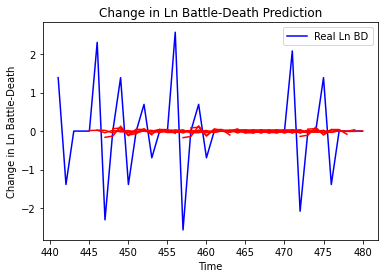

Storing forecasts...
Evaluating delta multi-step forecasts...
{'country': 'Angola', 'country_id': 165, 'step': 't+0', 'mse': 1.1778587128579117, 'mae': 0.6403332155756196, 'r2': 0.07438197989666362, 'tadda_score': 0.6403551073682349}
{'country': 'Angola', 'country_id': 165, 'step': 't+1', 'mse': 1.3272224680238152, 'mae': 0.7129567625248969, 'r2': -0.04299524185551862, 'tadda_score': 0.7283385773747704}
{'country': 'Angola', 'country_id': 165, 'step': 't+2', 'mse': 0.8733921600097977, 'mae': 0.4910369768167346, 'r2': 0.004250420565256485, 'tadda_score': 0.4910369768167346}
{'country': 'Angola', 'country_id': 165, 'step': 't+3', 'mse': 1.026136797819212, 'mae': 0.6141538037277091, 'r2': 0.04400939669800563, 'tadda_score': 0.6164769915843337}
{'country': 'Angola', 'country_id': 165, 'step': 't+4', 'mse': 0.9732763923834489, 'mae': 0.5525286891194702, 'r2': 0.005945056740118804, 'tadda_score': 0.5584055302672108}
{'country': 'Angola', 'country_id': 165, 'step': 't+5', 'mse': 1.31760370365

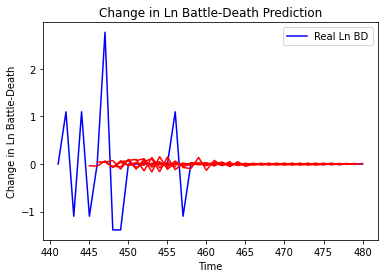

Storing forecasts...
Evaluating delta multi-step forecasts...
{'country': 'Congo', 'country_id': 166, 'step': 't+0', 'mse': 0.49236383114894494, 'mae': 0.3077560011219568, 'r2': 0.022537334466638415, 'tadda_score': 0.3099141106552468}
{'country': 'Congo', 'country_id': 166, 'step': 't+1', 'mse': 0.8076422447006089, 'mae': 0.44086571235112376, 'r2': -0.06274609022100353, 'tadda_score': 0.4596169564739071}
{'country': 'Congo', 'country_id': 166, 'step': 't+2', 'mse': 0.6074388821193389, 'mae': 0.36052576529685837, 'r2': -0.02417675051655288, 'tadda_score': 0.3632926761130907}
{'country': 'Congo', 'country_id': 166, 'step': 't+3', 'mse': 0.7441744829850652, 'mae': 0.4019949669287024, 'r2': -0.07132037932105773, 'tadda_score': 0.42054383316590566}
{'country': 'Congo', 'country_id': 166, 'step': 't+4', 'mse': 0.5817874912623977, 'mae': 0.35499909705995697, 'r2': 0.01907296382908008, 'tadda_score': 0.35697541348218104}
{'country': 'Congo', 'country_id': 166, 'step': 't+5', 'mse': 0.699815479

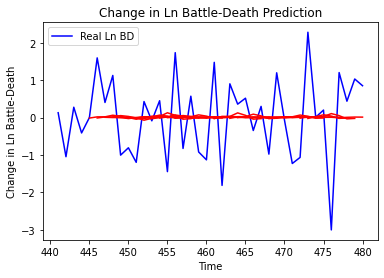

Storing forecasts...
Evaluating delta multi-step forecasts...
{'country': 'Congo, DRC', 'country_id': 167, 'step': 't+0', 'mse': 1.1056153753701696, 'mae': 0.8798843690194639, 'r2': -0.010173455850845503, 'tadda_score': 0.8863309445636175}
{'country': 'Congo, DRC', 'country_id': 167, 'step': 't+1', 'mse': 1.413397088624068, 'mae': 0.9620683837647807, 'r2': 0.0003727696496484967, 'tadda_score': 0.9654599620926451}
{'country': 'Congo, DRC', 'country_id': 167, 'step': 't+2', 'mse': 1.7372758434145898, 'mae': 1.0607421726111195, 'r2': -0.007153857965328081, 'tadda_score': 1.0721505971127372}
{'country': 'Congo, DRC', 'country_id': 167, 'step': 't+3', 'mse': 1.8499456992367838, 'mae': 1.0376606061643066, 'r2': -0.06185768963317084, 'tadda_score': 1.0763097106688422}
{'country': 'Congo, DRC', 'country_id': 167, 'step': 't+4', 'mse': 1.972537253072416, 'mae': 1.1727231252312837, 'r2': -0.07452587761034568, 'tadda_score': 1.2219551372802686}
{'country': 'Congo, DRC', 'country_id': 167, 'step':

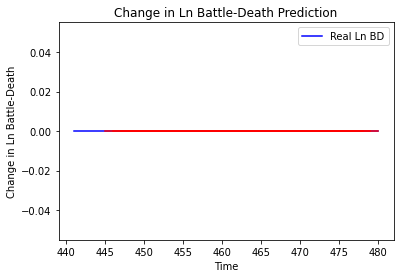

Storing forecasts...
Evaluating delta multi-step forecasts...
{'country': 'Gabon', 'country_id': 169, 'step': 't+0', 'mse': 0.0, 'mae': 0.0, 'r2': 1.0, 'tadda_score': 0.0}
{'country': 'Gabon', 'country_id': 169, 'step': 't+1', 'mse': 0.0, 'mae': 0.0, 'r2': 1.0, 'tadda_score': 0.0}
{'country': 'Gabon', 'country_id': 169, 'step': 't+2', 'mse': 0.0, 'mae': 0.0, 'r2': 1.0, 'tadda_score': 0.0}
{'country': 'Gabon', 'country_id': 169, 'step': 't+3', 'mse': 0.0, 'mae': 0.0, 'r2': 1.0, 'tadda_score': 0.0}
{'country': 'Gabon', 'country_id': 169, 'step': 't+4', 'mse': 0.0, 'mae': 0.0, 'r2': 1.0, 'tadda_score': 0.0}
{'country': 'Gabon', 'country_id': 169, 'step': 't+5', 'mse': 0.0, 'mae': 0.0, 'r2': 1.0, 'tadda_score': 0.0}
{'country': 'Gabon', 'country_id': 169, 'step': 't+6', 'mse': 0.0, 'mae': 0.0, 'r2': 1.0, 'tadda_score': 0.0}
['Namibia']
Building vanilla Model...
Model: "sequential_41"
_________________________________________________________________
Layer (type)                 Output Shape

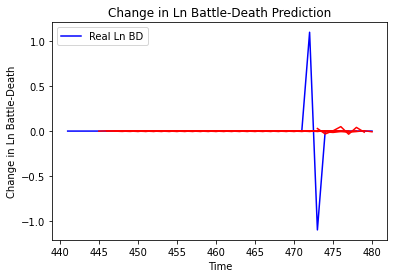

Storing forecasts...
Evaluating delta multi-step forecasts...
{'country': 'Namibia', 'country_id': 170, 'step': 't+0', 'mse': 0.08264373634999789, 'mae': 0.07529299615902893, 'r2': -0.027098978912385885, 'tadda_score': 0.0762716377784691}
{'country': 'Namibia', 'country_id': 170, 'step': 't+1', 'mse': 0.0786339128880532, 'mae': 0.0740618853567982, 'r2': 0.022735234365925283, 'tadda_score': 0.0740618853567982}
{'country': 'Namibia', 'country_id': 170, 'step': 't+2', 'mse': 0.04015362771946414, 'mae': 0.03886260300884988, 'r2': -0.03247702066606939, 'tadda_score': 0.03886260300884988}
{'country': 'Namibia', 'country_id': 170, 'step': 't+3', 'mse': 0.04055417567674013, 'mae': 0.04192501786796099, 'r2': -0.042776378035509044, 'tadda_score': 0.04200733684944954}
{'country': 'Namibia', 'country_id': 170, 'step': 't+4', 'mse': 0.04051335652613255, 'mae': 0.0414074419905528, 'r2': -0.041726788312262064, 'tadda_score': 0.04148634952192849}
{'country': 'Namibia', 'country_id': 170, 'step': 't+5'

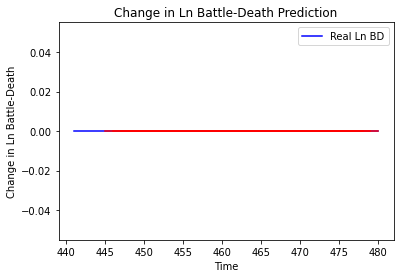

Storing forecasts...
Evaluating delta multi-step forecasts...
{'country': 'Madagascar', 'country_id': 172, 'step': 't+0', 'mse': 0.0, 'mae': 0.0, 'r2': 1.0, 'tadda_score': 0.0}
{'country': 'Madagascar', 'country_id': 172, 'step': 't+1', 'mse': 0.0, 'mae': 0.0, 'r2': 1.0, 'tadda_score': 0.0}
{'country': 'Madagascar', 'country_id': 172, 'step': 't+2', 'mse': 0.0, 'mae': 0.0, 'r2': 1.0, 'tadda_score': 0.0}
{'country': 'Madagascar', 'country_id': 172, 'step': 't+3', 'mse': 0.0, 'mae': 0.0, 'r2': 1.0, 'tadda_score': 0.0}
{'country': 'Madagascar', 'country_id': 172, 'step': 't+4', 'mse': 0.0, 'mae': 0.0, 'r2': 1.0, 'tadda_score': 0.0}
{'country': 'Madagascar', 'country_id': 172, 'step': 't+5', 'mse': 0.0, 'mae': 0.0, 'r2': 1.0, 'tadda_score': 0.0}
{'country': 'Madagascar', 'country_id': 172, 'step': 't+6', 'mse': 0.0, 'mae': 0.0, 'r2': 1.0, 'tadda_score': 0.0}
['Mauritius']
Building vanilla Model...
Model: "sequential_43"
_________________________________________________________________
Laye

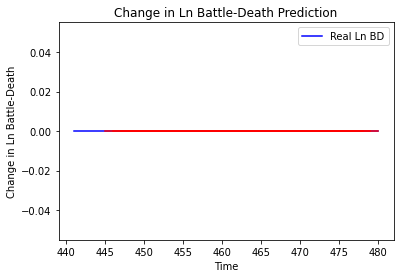

Storing forecasts...
Evaluating delta multi-step forecasts...
{'country': 'Mauritius', 'country_id': 173, 'step': 't+0', 'mse': 0.0, 'mae': 0.0, 'r2': 1.0, 'tadda_score': 0.0}
{'country': 'Mauritius', 'country_id': 173, 'step': 't+1', 'mse': 0.0, 'mae': 0.0, 'r2': 1.0, 'tadda_score': 0.0}
{'country': 'Mauritius', 'country_id': 173, 'step': 't+2', 'mse': 0.0, 'mae': 0.0, 'r2': 1.0, 'tadda_score': 0.0}
{'country': 'Mauritius', 'country_id': 173, 'step': 't+3', 'mse': 0.0, 'mae': 0.0, 'r2': 1.0, 'tadda_score': 0.0}
{'country': 'Mauritius', 'country_id': 173, 'step': 't+4', 'mse': 0.0, 'mae': 0.0, 'r2': 1.0, 'tadda_score': 0.0}
{'country': 'Mauritius', 'country_id': 173, 'step': 't+5', 'mse': 0.0, 'mae': 0.0, 'r2': 1.0, 'tadda_score': 0.0}
{'country': 'Mauritius', 'country_id': 173, 'step': 't+6', 'mse': 0.0, 'mae': 0.0, 'r2': 1.0, 'tadda_score': 0.0}
['Seychelles']
Building vanilla Model...
Model: "sequential_44"
_________________________________________________________________
Layer (typ

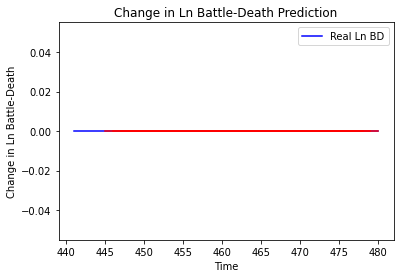

Storing forecasts...
Evaluating delta multi-step forecasts...
{'country': 'Seychelles', 'country_id': 174, 'step': 't+0', 'mse': 0.0, 'mae': 0.0, 'r2': 1.0, 'tadda_score': 0.0}
{'country': 'Seychelles', 'country_id': 174, 'step': 't+1', 'mse': 0.0, 'mae': 0.0, 'r2': 1.0, 'tadda_score': 0.0}
{'country': 'Seychelles', 'country_id': 174, 'step': 't+2', 'mse': 0.0, 'mae': 0.0, 'r2': 1.0, 'tadda_score': 0.0}
{'country': 'Seychelles', 'country_id': 174, 'step': 't+3', 'mse': 0.0, 'mae': 0.0, 'r2': 1.0, 'tadda_score': 0.0}
{'country': 'Seychelles', 'country_id': 174, 'step': 't+4', 'mse': 0.0, 'mae': 0.0, 'r2': 1.0, 'tadda_score': 0.0}
{'country': 'Seychelles', 'country_id': 174, 'step': 't+5', 'mse': 0.0, 'mae': 0.0, 'r2': 1.0, 'tadda_score': 0.0}
{'country': 'Seychelles', 'country_id': 174, 'step': 't+6', 'mse': 0.0, 'mae': 0.0, 'r2': 1.0, 'tadda_score': 0.0}
['Libya']
Building vanilla Model...
Model: "sequential_45"
_________________________________________________________________
Layer (t

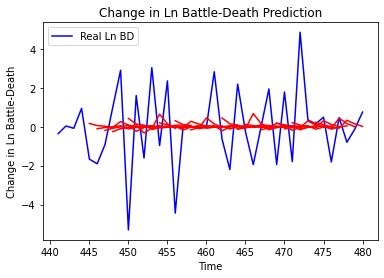

Storing forecasts...
Evaluating delta multi-step forecasts...
{'country': 'Libya', 'country_id': 213, 'step': 't+0', 'mse': 5.359034730199751, 'mae': 1.7903372369028323, 'r2': -0.10595079024827503, 'tadda_score': 1.8978676731213933}
{'country': 'Libya', 'country_id': 213, 'step': 't+1', 'mse': 5.304899174397927, 'mae': 1.8100308613088274, 'r2': 0.02073565730279725, 'tadda_score': 1.8870969630033847}
{'country': 'Libya', 'country_id': 213, 'step': 't+2', 'mse': 7.280718889480239, 'mae': 2.1154095577063097, 'r2': 0.01910685776863308, 'tadda_score': 2.201301435441964}
{'country': 'Libya', 'country_id': 213, 'step': 't+3', 'mse': 5.566665920435435, 'mae': 1.975165404935178, 'r2': 0.038046721018017204, 'tadda_score': 2.029524522768454}
{'country': 'Libya', 'country_id': 213, 'step': 't+4', 'mse': 7.360233433285282, 'mae': 2.274924588593826, 'r2': -0.011551912387939067, 'tadda_score': 2.41316136278757}
{'country': 'Libya', 'country_id': 213, 'step': 't+5', 'mse': 6.225583109933633, 'mae': 1.

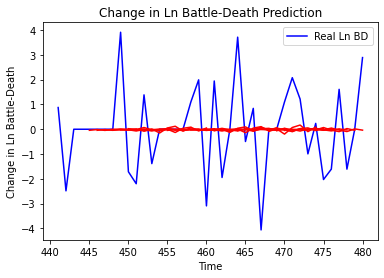

Storing forecasts...
Evaluating delta multi-step forecasts...
{'country': 'Chad', 'country_id': 214, 'step': 't+0', 'mse': 2.9965062066693333, 'mae': 1.210419353776097, 'r2': -0.020804709036938096, 'tadda_score': 1.2248021656291381}
{'country': 'Chad', 'country_id': 214, 'step': 't+1', 'mse': 4.298836986755137, 'mae': 1.4704637804491874, 'r2': -0.012741892397032162, 'tadda_score': 1.483034008504307}
{'country': 'Chad', 'country_id': 214, 'step': 't+2', 'mse': 5.275126861035137, 'mae': 1.7471693551560277, 'r2': -0.010041623020477619, 'tadda_score': 1.7707152105018529}
{'country': 'Chad', 'country_id': 214, 'step': 't+3', 'mse': 6.192231234233899, 'mae': 2.0135373981751736, 'r2': -0.015464144620528586, 'tadda_score': 2.038867311808739}
{'country': 'Chad', 'country_id': 214, 'step': 't+4', 'mse': 4.917779872167575, 'mae': 1.6997500388474223, 'r2': -0.03513457363627914, 'tadda_score': 1.7258267478298104}
{'country': 'Chad', 'country_id': 214, 'step': 't+5', 'mse': 4.138547247432311, 'mae':

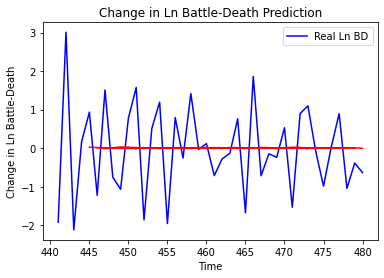

Storing forecasts...
Evaluating delta multi-step forecasts...
{'country': 'Egypt', 'country_id': 222, 'step': 't+0', 'mse': 1.1283424257952464, 'mae': 0.8892483722135849, 'r2': -0.0011514147235811567, 'tadda_score': 0.8934280775592777}
{'country': 'Egypt', 'country_id': 222, 'step': 't+1', 'mse': 1.0826613314050677, 'mae': 0.8786282144776457, 'r2': -0.0011149712339388884, 'tadda_score': 0.8849424223026018}
{'country': 'Egypt', 'country_id': 222, 'step': 't+2', 'mse': 0.9282805898997675, 'mae': 0.8050101128663792, 'r2': -0.0009237103829637938, 'tadda_score': 0.8108735231473967}
{'country': 'Egypt', 'country_id': 222, 'step': 't+3', 'mse': 1.2309329784850678, 'mae': 0.9385140366050739, 'r2': 0.0006846766018115957, 'tadda_score': 0.9442207131354152}
{'country': 'Egypt', 'country_id': 222, 'step': 't+4', 'mse': 1.1890228578398865, 'mae': 0.8691353759178081, 'r2': -0.0022460003810094165, 'tadda_score': 0.8772463057726431}
{'country': 'Egypt', 'country_id': 222, 'step': 't+5', 'mse': 1.09835

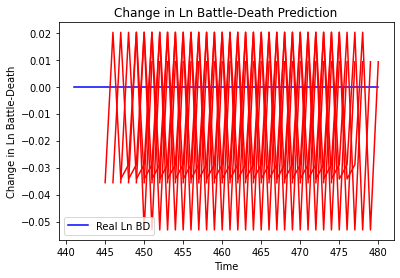

Storing forecasts...
Evaluating delta multi-step forecasts...
{'country': 'Uganda', 'country_id': 235, 'step': 't+0', 'mse': 0.0012652012685521186, 'mae': 0.03556966781616211, 'r2': 0.0, 'tadda_score': 0.03556966781616211}
{'country': 'Uganda', 'country_id': 235, 'step': 't+1', 'mse': 0.00023868376077297582, 'mae': 0.015449393540620804, 'r2': 0.0, 'tadda_score': 0.015449393540620804}
{'country': 'Uganda', 'country_id': 235, 'step': 't+2', 'mse': 0.0024652385122441722, 'mae': 0.049651168286800385, 'r2': 0.0, 'tadda_score': 0.049651168286800385}
{'country': 'Uganda', 'country_id': 235, 'step': 't+3', 'mse': 0.006168175404682508, 'mae': 0.07853773236274719, 'r2': 0.0, 'tadda_score': 0.07853773236274719}
{'country': 'Uganda', 'country_id': 235, 'step': 't+4', 'mse': 0.006161788372638866, 'mae': 0.07849705964326859, 'r2': 0.0, 'tadda_score': 0.07849705964326859}
{'country': 'Uganda', 'country_id': 235, 'step': 't+5', 'mse': 0.017309550400677276, 'mae': 0.13156576454639435, 'r2': 0.0, 'tadda

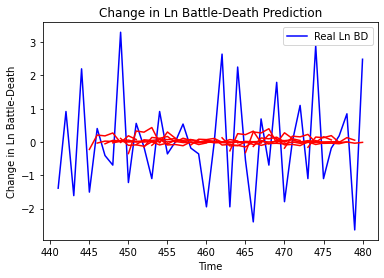

Storing forecasts...
Evaluating delta multi-step forecasts...
{'country': 'Kenya', 'country_id': 237, 'step': 't+0', 'mse': 1.8584962317314093, 'mae': 1.0350103242138167, 'r2': 0.1030979217692981, 'tadda_score': 1.0400598212891956}
{'country': 'Kenya', 'country_id': 237, 'step': 't+1', 'mse': 1.9090738133149174, 'mae': 1.0835243510402717, 'r2': -9.076953674780341e-05, 'tadda_score': 1.086899749019864}
{'country': 'Kenya', 'country_id': 237, 'step': 't+2', 'mse': 2.203212876148485, 'mae': 1.174583452820022, 'r2': -0.008990305804849719, 'tadda_score': 1.2157286467072759}
{'country': 'Kenya', 'country_id': 237, 'step': 't+3', 'mse': 2.855770325313039, 'mae': 1.3673708559909747, 'r2': -0.016900176825246582, 'tadda_score': 1.4440590756288954}
{'country': 'Kenya', 'country_id': 237, 'step': 't+4', 'mse': 1.4843769661119794, 'mae': 0.9917380750615244, 'r2': 0.019972297039215214, 'tadda_score': 1.02790270972079}
{'country': 'Kenya', 'country_id': 237, 'step': 't+5', 'mse': 2.82956128638496, 'm

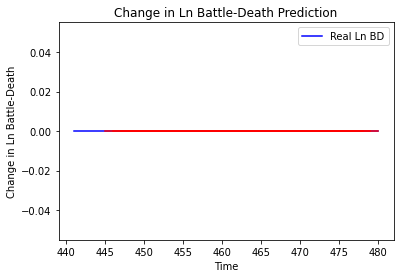

Storing forecasts...
Evaluating delta multi-step forecasts...
{'country': 'Tanzania', 'country_id': 242, 'step': 't+0', 'mse': 0.0, 'mae': 0.0, 'r2': 1.0, 'tadda_score': 0.0}
{'country': 'Tanzania', 'country_id': 242, 'step': 't+1', 'mse': 0.0, 'mae': 0.0, 'r2': 1.0, 'tadda_score': 0.0}
{'country': 'Tanzania', 'country_id': 242, 'step': 't+2', 'mse': 0.0, 'mae': 0.0, 'r2': 1.0, 'tadda_score': 0.0}
{'country': 'Tanzania', 'country_id': 242, 'step': 't+3', 'mse': 0.0, 'mae': 0.0, 'r2': 1.0, 'tadda_score': 0.0}
{'country': 'Tanzania', 'country_id': 242, 'step': 't+4', 'mse': 0.0, 'mae': 0.0, 'r2': 1.0, 'tadda_score': 0.0}
{'country': 'Tanzania', 'country_id': 242, 'step': 't+5', 'mse': 0.0, 'mae': 0.0, 'r2': 1.0, 'tadda_score': 0.0}
{'country': 'Tanzania', 'country_id': 242, 'step': 't+6', 'mse': 0.0, 'mae': 0.0, 'r2': 1.0, 'tadda_score': 0.0}
['Morocco']
Building vanilla Model...
Model: "sequential_51"
_________________________________________________________________
Layer (type)        

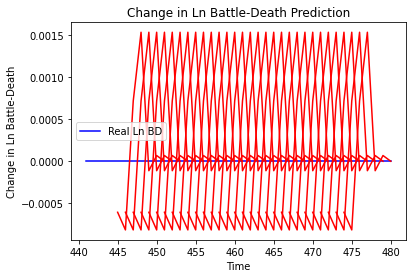

Storing forecasts...
Evaluating delta multi-step forecasts...
{'country': 'Morocco', 'country_id': 243, 'step': 't+0', 'mse': 3.6578945542903524e-07, 'mae': 0.0006048053037375212, 'r2': 0.0, 'tadda_score': 0.0006048053037375212}
{'country': 'Morocco', 'country_id': 243, 'step': 't+1', 'mse': 2.0143357698185226e-06, 'mae': 0.0014192729722708464, 'r2': 0.0, 'tadda_score': 0.0014192729722708464}
{'country': 'Morocco', 'country_id': 243, 'step': 't+2', 'mse': 4.914391685653164e-07, 'mae': 0.0007010272238403559, 'r2': 0.0, 'tadda_score': 0.0007010272238403559}
{'country': 'Morocco', 'country_id': 243, 'step': 't+3', 'mse': 6.933500235064508e-07, 'mae': 0.0008326764218509197, 'r2': 0.0, 'tadda_score': 0.0008326764218509197}
{'country': 'Morocco', 'country_id': 243, 'step': 't+4', 'mse': 2.35941347030374e-06, 'mae': 0.001536038238555193, 'r2': 0.0, 'tadda_score': 0.001536038238555193}
{'country': 'Morocco', 'country_id': 243, 'step': 't+5', 'mse': 2.576696562879273e-06, 'mae': 0.0016052091959

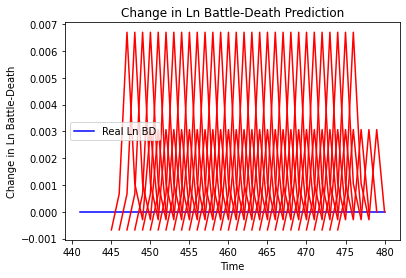

Storing forecasts...
Evaluating delta multi-step forecasts...
{'country': 'Mauritania', 'country_id': 244, 'step': 't+0', 'mse': 4.619294955968183e-07, 'mae': 0.0006796539528295398, 'r2': 0.0, 'tadda_score': 0.0006796539528295398}
{'country': 'Mauritania', 'country_id': 244, 'step': 't+1', 'mse': 2.951760954937469e-10, 'mae': 1.7180689610540867e-05, 'r2': 0.0, 'tadda_score': 1.7180689610540867e-05}
{'country': 'Mauritania', 'country_id': 244, 'step': 't+2', 'mse': 4.461219919732495e-05, 'mae': 0.006679236423224211, 'r2': 0.0, 'tadda_score': 0.006679236423224211}
{'country': 'Mauritania', 'country_id': 244, 'step': 't+3', 'mse': 5.9755710577775534e-05, 'mae': 0.0077301817946136, 'r2': 0.0, 'tadda_score': 0.0077301817946136}
{'country': 'Mauritania', 'country_id': 244, 'step': 't+4', 'mse': 4.582397691082715e-05, 'mae': 0.006769340950995684, 'r2': 0.0, 'tadda_score': 0.006769340950995684}
{'country': 'Mauritania', 'country_id': 244, 'step': 't+5', 'mse': 9.67003190399697e-05, 'mae': 0.00

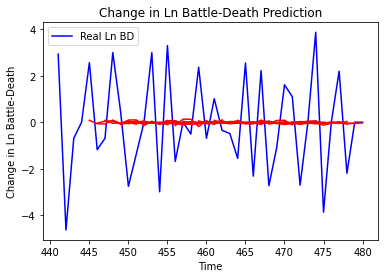

Storing forecasts...
Evaluating delta multi-step forecasts...
{'country': 'Sudan', 'country_id': 245, 'step': 't+0', 'mse': 3.956186856311988, 'mae': 1.6690437614762315, 'r2': 0.01128558661841994, 'tadda_score': 1.6847177773558626}
{'country': 'Sudan', 'country_id': 245, 'step': 't+1', 'mse': 4.282907398656629, 'mae': 1.6993906742001033, 'r2': -0.003786366447580347, 'tadda_score': 1.710418490510628}
{'country': 'Sudan', 'country_id': 245, 'step': 't+2', 'mse': 3.844185156181311, 'mae': 1.6725592954125676, 'r2': 0.008733470479202143, 'tadda_score': 1.7038938912914865}
{'country': 'Sudan', 'country_id': 245, 'step': 't+3', 'mse': 3.28214463674507, 'mae': 1.440461685603075, 'r2': 0.011429257864751685, 'tadda_score': 1.457321347701264}
{'country': 'Sudan', 'country_id': 245, 'step': 't+4', 'mse': 5.178561030828447, 'mae': 1.920182591521102, 'r2': 0.012252771005928476, 'tadda_score': 1.9409047953470129}
{'country': 'Sudan', 'country_id': 245, 'step': 't+5', 'mse': 4.6182012625284825, 'mae':

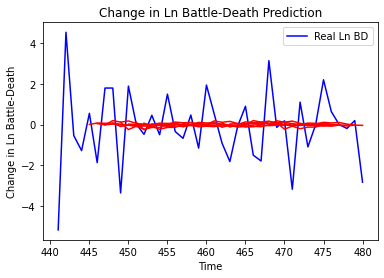

Storing forecasts...
Evaluating delta multi-step forecasts...
{'country': 'South Sudan', 'country_id': 246, 'step': 't+0', 'mse': 2.2970855406204436, 'mae': 1.1922799975535974, 'r2': -0.03258277568015355, 'tadda_score': 1.2201264525688393}
{'country': 'South Sudan', 'country_id': 246, 'step': 't+1', 'mse': 2.869104458051238, 'mae': 1.3209774215516668, 'r2': -0.06169211549483444, 'tadda_score': 1.3756069541719775}
{'country': 'South Sudan', 'country_id': 246, 'step': 't+2', 'mse': 2.911808386944682, 'mae': 1.4120976921449133, 'r2': -0.11368298654639131, 'tadda_score': 1.5029598146955199}
{'country': 'South Sudan', 'country_id': 246, 'step': 't+3', 'mse': 3.5274110981087605, 'mae': 1.5563058208607927, 'r2': -0.11902909738817802, 'tadda_score': 1.6847830152693684}
{'country': 'South Sudan', 'country_id': 246, 'step': 't+4', 'mse': 2.9862120890362434, 'mae': 1.3279367828287705, 'r2': -0.1838854843126303, 'tadda_score': 1.432101422440809}
{'country': 'South Sudan', 'country_id': 246, 'step'

In [14]:
np.random.seed(1)
tf.random.set_seed(1)
model = Sequential()
summary_model(dataset=df,
              modelname = "Vanilla",
              pred_africa=True,
              period=period_test, 
              epochs=50, 
              batch_size=64, 
              look_back=4, 
              look_forward=7,
              num_neurons=2, 
              val_split=0.2)

# Single Forecast for Aug 2020

In [16]:
scaler = MinMaxScaler()

#create training and test based on period predictions

def partition_dataset(dataset, period, look_back):
    #create delta/first diff
    from views.apps.transforms import lib as translib
    dataset['s_outcome'] = translib.delta(dataset['ln_ged_best_sb'], time=1)

    train_df = dataset[dataset['time'].between(period['train_start'] , period['train_end']-look_back, inclusive=True)].dropna()
    test_df = dataset[dataset['time'].between(period['predict_start'] - look_back, period['predict_end'], inclusive=True)].dropna()
    #print(train_df)
    #print(test_df) 
    #identify outcome of interest
    train_df = train_df[['s_outcome']]
    test_df = test_df[['s_outcome']]   
    
    return np.array(train_df), np.array(test_df)

def partition_delta(countryname, period, dataset, look_back):

    #s_actual = df.loc[:, self.model.col_outcome].copy()

    #if self.model.delta_outcome:
    #    s_actual = translib.delta(s_actual, time=step)
    
    dataset['s_outcome1'] = translib.delta(dataset['ln_ged_best_sb'], time=1)
    dataset['s_outcome2'] = translib.delta(dataset['ln_ged_best_sb'], time=2)
    dataset['s_outcome3'] = translib.delta(dataset['ln_ged_best_sb'], time=3)
    dataset['s_outcome4'] = translib.delta(dataset['ln_ged_best_sb'], time=4)
    dataset['s_outcome5'] = translib.delta(dataset['ln_ged_best_sb'], time=5)
    dataset['s_outcome6'] = translib.delta(dataset['ln_ged_best_sb'], time=6)
    dataset['s_outcome7'] = translib.delta(dataset['ln_ged_best_sb'], time=7)
    #translib.delta(dataset['ln_ged_best_sb'], time=1)
    
    train_df = dataset[dataset['time'].between(period['train_start'] , period['train_end']-look_back)].dropna()
    test_df = dataset[dataset['time'].between(period['predict_start'] - look_back , period['predict_end'])].dropna()
     
    #identify outcome of interest
    train_df = train_df[['s_outcome1', 's_outcome2', 's_outcome3', 's_outcome4', 's_outcome5', 's_outcome6', 's_outcome7']]
    test_df = test_df[['s_outcome1', 's_outcome2', 's_outcome3', 's_outcome4', 's_outcome5', 's_outcome6', 's_outcome7']]

    return train_df, test_df
    
     
# split a univariate sequence into samples
def create_dataset(dataset, look_back, look_forward):
    X, y = list(), list()
    for i in range(len(dataset)):
        # find the end of this pattern
        end_ix = i + look_back
        out_end_ix = end_ix + look_forward
        # check if we are beyond the sequence
        if out_end_ix > len(dataset):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = dataset[i:end_ix], dataset[end_ix:out_end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)
 

#VANILLA LSTM
def create_vanilla_model(X_train, y_train, epochs, num_neurons, batch_size, val_split):
    """BUILDING THE MODEL""" 
    print('Building vanilla Model...')
    # simple early stopping
    es = EarlyStopping(monitor='loss', mode='min', verbose=1)

    model = Sequential()

    #Input Layers
    model.add(LSTM(units = num_neurons, input_shape = (X_train.shape[1], 1), activation="tanh"))

    #model.add(LSTM(units = num_neurons, input_shape = (X_train.shape[1], 1), activation="tanh", stateful=True))
    #model.add(TimeDistributed(Dense(1)))

    # Dropout Regularization - randomly removes 20\%, helps with overfitting
    model.add(Dropout(0.2))
    #model.add(Dense(4)) 
    
    #Hidden Layers
    #
    model.add(Dense(num_neurons, activation="tanh")) # New hidden layer with 2 params, sigmoid function to constrainw weights
    #model.add(Dense(num_neurons, activation="tanh"))
    
    model.add(Dropout(0.2))
              
    # Output Layers
    model.add(Dense(units = y_train.shape[1]))

    #model.add(Activation('relu'))
    #model.add(Dropout(0.2))

    # Compiling the model
    model.compile(optimizer = 'adam', loss = 'mean_squared_error')

    #Summarize the model
    model.summary()

    # Fitting the model to the training set
    #model.fit(X_train, y_train, epochs = epochs, batch_size = batch_size, validation_split=val_split, callbacks=[es])
    #remove callback, train for more epochs (passes through the data)
    model.fit(X_train, y_train, epochs = epochs, batch_size = batch_size, validation_split=val_split)

    return model


def make_forecasts(model, period, batch_size, X_train, y_train, test_df, X_test, y_test, look_back, look_forward):
    """FORECASTING""" 
    print('Forecasting...')
    forecasts = []
    futures = []

    for i in range(0, len(X_test)):
        X = X_test[i, 0:look_back]
        y = y_test[i, look_back:]  

        # forecast steps       
        forecast = forecast_lstm(model, X, look_back, batch_size)
        #print(forecast)
        # store the forecast
        forecasts.append(forecast)
    
    currentStep = forecast[-1:]
    #Make one-step predictions for data beyond test_set
    for i in range(look_forward):
        if i == 0:
            X = X.reshape(1, look_back, 1)
            yhat = forecast_lstm(model, X, look_back, batch_size)
            #print(yhat)
        else:
            x0_input = np.append(X, [currentStep[i-1]])
            x0_input = x0_input.reshape((1, look_back+1, 1))
            x_input = x0_input[:,1:]
            yhat = forecast_lstm(model, x_input, look_back, batch_size)
            currentStep = np.append(currentStep, yhat)        
        #print(period['predict_end'] + i - look_forward + 1)
        futures.append(yhat)
    #print(futures)
        
    return forecasts, futures

def forecast_lstm(model, X, look_back, batch_size): 
    #make predictions
    X = X.reshape(1, look_back, 1)
    
    testPredict = model.predict(X, batch_size)
    # convert to array
    return [x for x in testPredict[0, :]]

def eval_model(countryname, model, X_train, y_train, X_test, y_test, futures, forecasts, look_back, look_forward):
    """EVALUATING THE MODEL"""
    print('Evaluating...')
    testScore_values = []
    testScore_valuespercountry = []
    for i in range(look_forward):
        #print(type(y_test))
        s_actual = [row[i] for row in y_test]
        #print(s_actual)
        s_prediction = [forecast[i] for forecast in forecasts]
        #print(type(forecasts))
        #print(s_prediction)
        scores = {}
        scores["Country"] = countryname.ravel().tolist()[0]
        scores["Step"] = 't+%d' % ((i))
        scores["mse"] = evallib.mean_squared_error(actuals=s_actual, preds=s_prediction)
        scores["mae"] = evallib.mean_absolute_error(actuals=s_actual, preds=s_prediction)
        scores["r2"] = evallib.r2_score(actuals=s_actual, preds=s_prediction)
        scores["tadda_score"] = evallib.tadda_score(y_deltas=np.array(s_actual), f_deltas=np.array(s_prediction), epsilon=0.048)
        #scores["Future Prediction"] = flat_future2[i]
        #print(scores)
            # calculate root mean squared error for scaled data
        
        testScore_values.append(scores)
    testScore_valuespercountry.append(testScore_values)
    return testScore_valuespercountry

def plot_forecasts(period, test_df, y_test, forecasts, look_back, look_forward):
    print('Plotting forecasts...')
    """PLOTTING THE MODEL"""
    plt.plot(range(period['predict_start']- look_back, period['predict_start'] + len(test_df)- look_back), test_df, color='blue', label = 'Real Ln BD')
    # show the plot
    # plot the forecasts in red
    #print(test_df.shape)
    #print(len(forecasts))
    #print(len(tot))
    print(y_test.shape)
    for i in range(len(forecasts)):
        off_s = period['predict_start'] + i  
        off_e = off_s + len(forecasts[i]) 
        xaxis = [x for x in range(off_s, off_e)]
        yaxis = forecasts[i:][0]
        #print(xaxis)
        #print(yaxis)
        plt.plot(xaxis, yaxis, color='red')
    plt.title('Change in Ln Battle-Death Prediction')
    plt.xlabel('Time')
    plt.ylabel('Change in Ln Battle-Death')
    plt.legend()
    plt.show()
    
def store_forecasts(period, countryname, y_test, futures, forecasts, look_back, look_forward):
    print('Storing forecasts...')
    """STORING MODEL RESULTS"""
    storage =[]
    storagepredictions = []
    storagepredictionspercountry = []
    for i in range(len(forecasts)):
        off_s = period['predict_start'] + i 
        off_e = off_s + len(forecasts[i]) 
        #print(off_s)      
        xaxis = [x for x in range(off_s, off_e)]
        yaxis = forecasts[i:][0]

        storage = {}
        storage["Country"] = countryname.ravel().tolist()[0]
        storage["Month"] = off_s - 1
        #storage["Future Months"] = xaxis
        storage["Malone_LSTM_s1"] = yaxis[0]
        storage["Malone_LSTM_s2"] = yaxis[0] + yaxis[1]
        storage["Malone_LSTM_s3"] = yaxis[0] + yaxis[1] + yaxis[2]
        storage["Malone_LSTM_s4"] = yaxis[0] + yaxis[1] + yaxis[2] + yaxis[3]
        storage["Malone_LSTM_s5"] = yaxis[0] + yaxis[1] + yaxis[2] + yaxis[3] + yaxis[4]
        storage["Malone_LSTM_s6"] = yaxis[0] + yaxis[1] + yaxis[2] + yaxis[3] + yaxis[4] + yaxis[5]
        storage["Malone_LSTM_s7"] = yaxis[0] + yaxis[1] + yaxis[2] + yaxis[3] + yaxis[4] + yaxis[5] + yaxis[6]
        storagepredictions.append(storage)
    #storagepredictionspercountry.append(storagepredictions)
    #print(storagepredictionspercountry)
    for i in range(len(futures)):
        off_s = period['predict_end'] + i - look_forward + 1   
        off_e = off_s + len(futures[i]) 
        #print(off_s)
        
        xaxis = [x for x in range(off_s +1, off_e)]
        yaxis = futures[i:][0]
        #print(countryname)
        #print(xaxis)
        #print(yaxis)
        storage = {}
        storage["Country"] = countryname.ravel().tolist()[0]
        storage["Last Month of Data"] = off_s 
        #storage["Future Month"] = xaxis
        storage["Malone_LSTM_s1"] = yaxis[0]
        storage["Malone_LSTM_s2"] = yaxis[0] + yaxis[1]
        storage["Malone_LSTM_s3"] = yaxis[0] + yaxis[1] + yaxis[2]
        storage["Malone_LSTM_s4"] = yaxis[0] + yaxis[1] + yaxis[2] + yaxis[3]
        storage["Malone_LSTM_s5"] = yaxis[0] + yaxis[1] + yaxis[2] + yaxis[3] + yaxis[4]
        storage["Malone_LSTM_s6"] = yaxis[0] + yaxis[1] + yaxis[2] + yaxis[3] + yaxis[4] + yaxis[5]
        storage["Malone_LSTM_s7"] = yaxis[0] + yaxis[1] + yaxis[2] + yaxis[3] + yaxis[4] + yaxis[5] + yaxis[6]
        #print(storage)
        storagepredictions.append(storage)
    storagepredictionspercountry.append(storagepredictions)
    #print(storagepredictionspercountry)
    return storagepredictionspercountry



def store_forecasts(period, countryname, gwno, train_step, test_step, y_test, futures, forecasts, look_back, look_forward):
    print('Storing forecasts...')
    """STORING MODEL RESULTS"""
    storage =[]
    storagepredictions = []
    storagepredictionspercountry = []
    for i in range(1, len(futures)):
        off_s = period['predict_end'] + i - look_forward + 1   
        off_e = off_s + len(futures[i]) 
        #print(off_s)
        
        xaxis = [x for x in range(off_s +1, off_e)]
        yaxis = futures[i:][0]
        #print(countryname)
        #print(xaxis)
        #print(yaxis)
        storage = {}
        storage["country"] = countryname.ravel().tolist()[0]
        storage["country_id"] = gwno.ravel().tolist()[0]
        storage["Last Month of Data"] = off_s 
        #storage["Future Months"] = xaxis
        storage["Malone_LSTM_s1"] = yaxis[0]
        storage["Malone_LSTM_s2"] = yaxis[0] + yaxis[1]
        storage["Malone_LSTM_s3"] = yaxis[0] + yaxis[1] + yaxis[2]
        storage["Malone_LSTM_s4"] = yaxis[0] + yaxis[1] + yaxis[2] + yaxis[3]
        storage["Malone_LSTM_s5"] = yaxis[0] + yaxis[1] + yaxis[2] + yaxis[3] + yaxis[4]
        storage["Malone_LSTM_s6"] = yaxis[0] + yaxis[1] + yaxis[2] + yaxis[3] + yaxis[4] + yaxis[5]
        storage["Malone_LSTM_s7"] = yaxis[0] + yaxis[1] + yaxis[2] + yaxis[3] + yaxis[4] + yaxis[5] + yaxis[6]
        #print(storage)
    storagepredictions.append(storage)

    storagepredictionspercountry.append(storagepredictions)
    #print(storagepredictionspercountry)
    return storagepredictionspercountry

def export_results(modelname, period, batch_size, epochs, num_neurons, look_back, look_forward,  storagepredictionsglobal):
    print('Exporting results...')
    #Write Tables
    if period == period_calib:
        period_print = 'calibration'
    elif period == period_test:
        period_print = 'test'
    elif period == period_task1:
        period_print = 'task'
    
    #write country predictions
    flattenstorage_list = [item for sublist in storagepredictionsglobal for item in sublist]
    print(flattenstorage_list)
    flattenstorage_list_final = [item for sublist in flattenstorage_list for item in sublist]
    keys = flattenstorage_list_final[0].keys()
    with open('country.csv', 'w') as output_file:
        dict_writer = csv.DictWriter(output_file, keys)
        dict_writer.writeheader()
        dict_writer.writerows(flattenstorage_list_final)
   
    path_out = os.path.join(
        out_paths["evaluation"], 
        f"predictions_{modelname}_{period_print}_epochs{epochs}_batchsize{batch_size}_neurons{num_neurons}_lookback{look_back}_countryscores.csv"
        )
    with open(path_out, "w") as f:
        dict_writer = csv.DictWriter(f, keys)
        dict_writer.writeheader()
        dict_writer.writerows(flattenstorage_list_final)
    print(f"Wrote country-level prediction tables to {path_out}.")

def eval_delta_forecasts(period, countryname, gwno, train_step, test_step, y_test, futures, forecasts, look_back, look_forward):
    print('Evaluating delta multi-step forecasts...')
    storage_pred2 = []
    storage_actual2 = []
    testScore_values = []
    testScore_valuespercountry = []
    for i in range(len(forecasts)):
        
        yaxis = forecasts[i:][0]  
        storage_pred = (yaxis[0], yaxis[0] + yaxis[1], yaxis[0] + yaxis[1] + yaxis[2] ,yaxis[0] + yaxis[1] + yaxis[2] + yaxis[3],yaxis[0] + yaxis[2] + yaxis[3] + yaxis[4], yaxis[0] + yaxis[2] + yaxis[3] + yaxis[4] + yaxis[5], yaxis[0] + yaxis[2] + yaxis[3] +yaxis[4] + yaxis[5] + yaxis[6]) 
        storage_pred = list(storage_pred)
        storage_pred2.append(storage_pred)

    for index, row in test_step.iterrows(): 
        #yaxis = test_step[i:, 0]
        #print(yaxis)
        storage_actual = (row.loc['s_outcome1'], row.loc['s_outcome2'], row.loc['s_outcome3'], row.loc['s_outcome4'], row.loc['s_outcome5'], row.loc['s_outcome6'], row.loc['s_outcome7'])
        storage_actual = list(storage_actual)
        storage_actual2.append(storage_actual)
        
    for i in range(look_forward):
        s_actual = [item[i] for item in storage_actual2]
        s_prediction = [item[i] for item in storage_pred2]
        
        scores = {}
        scores["country"] = countryname.ravel().tolist()[0]
        scores["country_id"] = gwno.ravel().tolist()[0]
        scores["step"] = 't+%d' % ((i))
        scores["mse"] = evallib.mean_squared_error(actuals=s_actual, preds=s_prediction)
        scores["mae"] = evallib.mean_absolute_error(actuals=s_actual, preds=s_prediction)
        scores["r2"] = evallib.r2_score(actuals=s_actual, preds=s_prediction)
        scores["tadda_score"] = evallib.tadda_score(y_deltas=np.array(s_actual), f_deltas=np.array(s_prediction), epsilon=0.048)
        #print(scores)
        # calculate root mean squared error for scaled data
        
        testScore_values.append(scores)
    testScore_valuespercountry.append(testScore_values)
    return testScore_valuespercountry

In [17]:

#list to store country-specific MSE

def summary_model(dataset, modelname, pred_africa, period, epochs, batch_size, look_back, look_forward, num_neurons, val_split):
    
    if pred_africa == False:
        dataset = dataset
    elif pred_africa == True:
        dataset = dataset[(dataset.in_africa==1)]

    if period == period_calib:
        period_print = 'calibration'
    elif period == period_test:
        period_print = 'test'
    elif period == period_task1:
        period_print = 'task1'    
    #create unique list of names
    gwnonames = dataset.gwno.unique()
    
    #create a data frame dictionary to store data frame for each unique country
    gwno_dict = {elem : pd.DataFrame for elem in gwnonames}

    for key in gwno_dict.keys():
        gwno_dict[key] = dataset[:][dataset.gwno == key]
    
    #model needs to be global
    forecasts = []
    predictions = []
    forecastsglobal = []
    storagepredictionsglobal = []
    scoresglobal = []
    
    scores = []
    scoresdelta = []
    scoresdeltaglobal = []
    futures = []
    storage = []
    for key in gwno_dict:
    #for key in range(8, 10):
        forecasts = []
        dfgwno = pd.DataFrame(gwno_dict[key])
        dfgwno = dfgwno[['gwno','time','ln_ged_best_sb','country_name']]
        countryname = dfgwno.country_name.unique()
        gwno = dfgwno.gwno.unique()

        print(countryname)
        #print(gwno)
        
        train_df, test_df = partition_dataset(dfgwno, period, look_back)
        #print(test_df)
        train_step, test_step = partition_delta(countryname, period, dfgwno, look_back)        
        
        test_step = test_step.iloc[look_back: -look_forward+1]
        X_train, y_train = create_dataset(train_df, look_back, look_forward)
    
        # reshape it [samples, time steps, features]
        X_train = np.reshape(X_train, (X_train.shape[0], look_back, 1))
    
        # Create the data to test our model on:
        X_test, y_test = create_dataset(test_df, look_back, look_forward)
        #print(y_test)
        # LSTM input shape: (samples, time steps, features)
        X_test = np.reshape(X_test, (X_test.shape[0], look_back, 1))
        
        #Create the model to predict:
        if modelname == "Vanilla":
            model = create_vanilla_model(X_train, y_train, epochs, num_neurons, batch_size, val_split)
        elif modelname == "Stateful":
            model = create_stateful_model(X_train, y_train, epochs, num_neurons, batch_size, val_split)
        elif modelname == "Bidirectional":
            model = create_bidirectional_model(X_train, y_train, epochs, num_neurons, batch_size, val_split)
        elif modelname == "Stacked":
            model = create_stacked_model(X_train, y_train, epochs, num_neurons, batch_size, val_split)
        
        #Make Multi-Step Predictions for Test Data 
        forecasts, futures = make_forecasts(model, period, batch_size, X_train, y_train, test_df, X_test, y_test, look_back, look_forward)

        forecastsglobal.append(forecasts)
        
        #Evaluate out-of-sample forecasting by different metrics

        #scores = eval_model(countryname,model, X_train, y_train, X_test, y_test, futures, forecasts, look_back, look_forward)
        # plot the forecasts in red
        #plot_forecasts(period, test_df, y_test, forecasts, look_back, look_forward)
        #scoresglobal.append(scores)
        #eval_delta_model(countryname, dataset, model, train_step, test_step, X_train, y_train, X_test, y_test, futures, forecasts, look_back, look_forward)
        # Store the Predictions for Write-Out
        storage = store_forecasts(period, countryname, gwno, train_step, test_step, y_test, futures, forecasts, look_back, look_forward)
    
        storagepredictionsglobal.append(storage)
        #scoresdelta = eval_delta_forecasts(period, countryname, gwno, train_step, test_step, y_test, futures, forecasts, look_back, look_forward)
        #scoresdeltaglobal.append(scoresdelta)
    export_results(modelname, period, batch_size, epochs, num_neurons, look_back, look_forward, storagepredictionsglobal)
    

# Forecast Oct 2020-March 2021

In [18]:
period_task1 = {'train_start': 121,   # 1990-01
          'train_end': 481,     # 2020.01
          'predict_start': 482, # 2020.02
          'predict_end': 488}   # 2020.08

In [19]:
np.random.seed(1)
tf.random.set_seed(1)
model = Sequential()
summary_model(dataset=df,
              modelname = "Vanilla",
              pred_africa=True,
              period=period_task1, 
              epochs=50, 
              batch_size=64, 
              look_back=4, 
              look_forward=7,
              num_neurons=2, 
              val_split=0.2)

['Cape Verde']
Building vanilla Model...
Model: "sequential_111"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_108 (LSTM)              (None, 2)                 32        
_________________________________________________________________
dropout_216 (Dropout)        (None, 2)                 0         
_________________________________________________________________
dense_216 (Dense)            (None, 2)                 6         
_________________________________________________________________
dropout_217 (Dropout)        (None, 2)                 0         
_________________________________________________________________
dense_217 (Dense)            (None, 7)                 21        
Total params: 59
Trainable params: 59
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
5/5 [==============================] - 0s 48ms/step - loss: 0.0000e+00

5/5 [==============================] - 0s 7ms/step - loss: 0.5749 - val_loss: 2.2354e-05
Epoch 10/50
5/5 [==============================] - 0s 7ms/step - loss: 0.5735 - val_loss: 2.9732e-05
Epoch 11/50
5/5 [==============================] - 0s 7ms/step - loss: 0.5789 - val_loss: 3.3663e-05
Epoch 12/50
5/5 [==============================] - 0s 7ms/step - loss: 0.5688 - val_loss: 3.6051e-05
Epoch 13/50
5/5 [==============================] - 0s 7ms/step - loss: 0.5745 - val_loss: 4.5735e-05
Epoch 14/50
5/5 [==============================] - 0s 7ms/step - loss: 0.5755 - val_loss: 6.7207e-05
Epoch 15/50
5/5 [==============================] - 0s 6ms/step - loss: 0.5695 - val_loss: 7.3832e-05
Epoch 16/50
5/5 [==============================] - 0s 6ms/step - loss: 0.5755 - val_loss: 7.6349e-05
Epoch 17/50
5/5 [==============================] - 0s 7ms/step - loss: 0.5749 - val_loss: 6.0196e-05
Epoch 18/50
5/5 [==============================] - 0s 7ms/step - loss: 0.5779 - val_loss: 5.3451e-05
Ep

5/5 [==============================] - 0s 7ms/step - loss: 1.1239 - val_loss: 6.4598e-04
Epoch 50/50
5/5 [==============================] - 0s 6ms/step - loss: 1.1258 - val_loss: 6.5993e-04
Forecasting...
Storing forecasts...
['Burkina Faso']
Building vanilla Model...
Model: "sequential_115"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_112 (LSTM)              (None, 2)                 32        
_________________________________________________________________
dropout_224 (Dropout)        (None, 2)                 0         
_________________________________________________________________
dense_224 (Dense)            (None, 2)                 6         
_________________________________________________________________
dropout_225 (Dropout)        (None, 2)                 0         
_________________________________________________________________
dense_225 (Dense)            (None, 7)         

Epoch 9/50
5/5 [==============================] - 0s 7ms/step - loss: 0.2328 - val_loss: 1.3125e-05
Epoch 10/50
5/5 [==============================] - 0s 8ms/step - loss: 0.2329 - val_loss: 1.9556e-05
Epoch 11/50
5/5 [==============================] - 0s 8ms/step - loss: 0.2328 - val_loss: 2.5768e-05
Epoch 12/50
5/5 [==============================] - 0s 7ms/step - loss: 0.2331 - val_loss: 3.2748e-05
Epoch 13/50
5/5 [==============================] - 0s 7ms/step - loss: 0.2328 - val_loss: 3.0022e-05
Epoch 14/50
5/5 [==============================] - 0s 7ms/step - loss: 0.2330 - val_loss: 3.5215e-05
Epoch 15/50
5/5 [==============================] - 0s 11ms/step - loss: 0.2330 - val_loss: 4.0176e-05
Epoch 16/50
5/5 [==============================] - 0s 9ms/step - loss: 0.2333 - val_loss: 3.9865e-05
Epoch 17/50
5/5 [==============================] - 0s 9ms/step - loss: 0.2331 - val_loss: 3.8387e-05
Epoch 18/50
5/5 [==============================] - 0s 8ms/step - loss: 0.2328 - val_loss: 3

Epoch 1/50
5/5 [==============================] - 0s 53ms/step - loss: 1.6284 - val_loss: 2.3398e-05
Epoch 2/50
5/5 [==============================] - 0s 7ms/step - loss: 1.6362 - val_loss: 3.1024e-05
Epoch 3/50
5/5 [==============================] - 0s 7ms/step - loss: 1.6234 - val_loss: 4.7370e-05
Epoch 4/50
5/5 [==============================] - 0s 7ms/step - loss: 1.6366 - val_loss: 7.4912e-05
Epoch 5/50
5/5 [==============================] - 0s 9ms/step - loss: 1.6260 - val_loss: 9.9937e-05
Epoch 6/50
5/5 [==============================] - 0s 7ms/step - loss: 1.6264 - val_loss: 1.4288e-04
Epoch 7/50
5/5 [==============================] - 0s 7ms/step - loss: 1.6307 - val_loss: 1.9839e-04
Epoch 8/50
5/5 [==============================] - 0s 7ms/step - loss: 1.6304 - val_loss: 2.3921e-04
Epoch 9/50
5/5 [==============================] - 0s 7ms/step - loss: 1.6329 - val_loss: 2.8576e-04
Epoch 10/50
5/5 [==============================] - 0s 7ms/step - loss: 1.6277 - val_loss: 2.6805e-0

5/5 [==============================] - 0s 8ms/step - loss: 0.0000e+00 - val_loss: 0.1084
Epoch 42/50
5/5 [==============================] - 0s 11ms/step - loss: 0.0000e+00 - val_loss: 0.1084
Epoch 43/50
5/5 [==============================] - 0s 9ms/step - loss: 0.0000e+00 - val_loss: 0.1084
Epoch 44/50
5/5 [==============================] - 0s 8ms/step - loss: 0.0000e+00 - val_loss: 0.1084
Epoch 45/50
5/5 [==============================] - 0s 9ms/step - loss: 0.0000e+00 - val_loss: 0.1084
Epoch 46/50
5/5 [==============================] - 0s 8ms/step - loss: 0.0000e+00 - val_loss: 0.1084
Epoch 47/50
5/5 [==============================] - 0s 7ms/step - loss: 0.0000e+00 - val_loss: 0.1084
Epoch 48/50
5/5 [==============================] - 0s 7ms/step - loss: 0.0000e+00 - val_loss: 0.1084
Epoch 49/50
5/5 [==============================] - 0s 7ms/step - loss: 0.0000e+00 - val_loss: 0.1084
Epoch 50/50
5/5 [==============================] - 0s 7ms/step - loss: 0.0000e+00 - val_loss: 0.1084
F

Epoch 1/50
4/4 [==============================] - 0s 82ms/step - loss: 1.7941 - val_loss: 0.3422
Epoch 2/50
4/4 [==============================] - 0s 9ms/step - loss: 1.7926 - val_loss: 0.3422
Epoch 3/50
4/4 [==============================] - 0s 9ms/step - loss: 1.7954 - val_loss: 0.3422
Epoch 4/50
4/4 [==============================] - 0s 8ms/step - loss: 1.7904 - val_loss: 0.3422
Epoch 5/50
4/4 [==============================] - 0s 9ms/step - loss: 1.7938 - val_loss: 0.3422
Epoch 6/50
4/4 [==============================] - 0s 9ms/step - loss: 1.7927 - val_loss: 0.3422
Epoch 7/50
4/4 [==============================] - 0s 9ms/step - loss: 1.7909 - val_loss: 0.3422
Epoch 8/50
4/4 [==============================] - 0s 10ms/step - loss: 1.7939 - val_loss: 0.3422
Epoch 9/50
4/4 [==============================] - 0s 8ms/step - loss: 1.7898 - val_loss: 0.3422
Epoch 10/50
4/4 [==============================] - 0s 7ms/step - loss: 1.7892 - val_loss: 0.3422
Epoch 11/50
4/4 [====================

5/5 [==============================] - 0s 9ms/step - loss: 0.9071 - val_loss: 1.5463
Epoch 48/50
5/5 [==============================] - 0s 7ms/step - loss: 0.9073 - val_loss: 1.5459
Epoch 49/50
5/5 [==============================] - 0s 7ms/step - loss: 0.9047 - val_loss: 1.5456
Epoch 50/50
5/5 [==============================] - 0s 6ms/step - loss: 0.9070 - val_loss: 1.5453
Forecasting...
Storing forecasts...
['Cameroon']
Building vanilla Model...
Model: "sequential_126"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_123 (LSTM)              (None, 2)                 32        
_________________________________________________________________
dropout_246 (Dropout)        (None, 2)                 0         
_________________________________________________________________
dense_246 (Dense)            (None, 2)                 6         
_______________________________________________________________

5/5 [==============================] - 0s 6ms/step - loss: 0.0000e+00 - val_loss: 0.8159
Epoch 32/50
5/5 [==============================] - 0s 6ms/step - loss: 0.0000e+00 - val_loss: 0.8159
Epoch 33/50
5/5 [==============================] - 0s 9ms/step - loss: 0.0000e+00 - val_loss: 0.8159
Epoch 34/50
5/5 [==============================] - 0s 7ms/step - loss: 0.0000e+00 - val_loss: 0.8159
Epoch 35/50
5/5 [==============================] - 0s 6ms/step - loss: 0.0000e+00 - val_loss: 0.8159
Epoch 36/50
5/5 [==============================] - 0s 6ms/step - loss: 0.0000e+00 - val_loss: 0.8159
Epoch 37/50
5/5 [==============================] - 0s 7ms/step - loss: 0.0000e+00 - val_loss: 0.8159
Epoch 38/50
5/5 [==============================] - 0s 6ms/step - loss: 0.0000e+00 - val_loss: 0.8159
Epoch 39/50
5/5 [==============================] - 0s 6ms/step - loss: 0.0000e+00 - val_loss: 0.8159
Epoch 40/50
5/5 [==============================] - 0s 6ms/step - loss: 0.0000e+00 - val_loss: 0.8159
Ep

Epoch 7/50
5/5 [==============================] - 0s 7ms/step - loss: 0.8809 - val_loss: 4.5235
Epoch 8/50
5/5 [==============================] - 0s 6ms/step - loss: 0.8650 - val_loss: 4.5211
Epoch 9/50
5/5 [==============================] - 0s 6ms/step - loss: 0.8754 - val_loss: 4.5189
Epoch 10/50
5/5 [==============================] - 0s 7ms/step - loss: 0.8742 - val_loss: 4.5167
Epoch 11/50
5/5 [==============================] - 0s 7ms/step - loss: 0.8671 - val_loss: 4.5147
Epoch 12/50
5/5 [==============================] - 0s 6ms/step - loss: 0.8724 - val_loss: 4.5128
Epoch 13/50
5/5 [==============================] - 0s 7ms/step - loss: 0.8737 - val_loss: 4.5109
Epoch 14/50
5/5 [==============================] - 0s 7ms/step - loss: 0.8700 - val_loss: 4.5089
Epoch 15/50
5/5 [==============================] - 0s 7ms/step - loss: 0.8739 - val_loss: 4.5069
Epoch 16/50
5/5 [==============================] - 0s 7ms/step - loss: 0.8679 - val_loss: 4.5049
Epoch 17/50
5/5 [================

5/5 [==============================] - 0s 7ms/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 50/50
5/5 [==============================] - 0s 7ms/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Forecasting...
Storing forecasts...
['Togo']
Building vanilla Model...
Model: "sequential_134"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_131 (LSTM)              (None, 2)                 32        
_________________________________________________________________
dropout_262 (Dropout)        (None, 2)                 0         
_________________________________________________________________
dense_262 (Dense)            (None, 2)                 6         
_________________________________________________________________
dropout_263 (Dropout)        (None, 2)                 0         
_________________________________________________________________
dense_263 (Dense)            (None, 7)         

5/5 [==============================] - 0s 9ms/step - loss: 2.3918 - val_loss: 0.5367
Epoch 8/50
5/5 [==============================] - 0s 7ms/step - loss: 2.3995 - val_loss: 0.5366
Epoch 9/50
5/5 [==============================] - 0s 7ms/step - loss: 2.4056 - val_loss: 0.5366
Epoch 10/50
5/5 [==============================] - 0s 7ms/step - loss: 2.3954 - val_loss: 0.5366
Epoch 11/50
5/5 [==============================] - 0s 7ms/step - loss: 2.4013 - val_loss: 0.5366
Epoch 12/50
5/5 [==============================] - 0s 7ms/step - loss: 2.4000 - val_loss: 0.5366
Epoch 13/50
5/5 [==============================] - 0s 7ms/step - loss: 2.3870 - val_loss: 0.5366
Epoch 14/50
5/5 [==============================] - 0s 8ms/step - loss: 2.3896 - val_loss: 0.5366
Epoch 15/50
5/5 [==============================] - 0s 7ms/step - loss: 2.3900 - val_loss: 0.5366
Epoch 16/50
5/5 [==============================] - 0s 8ms/step - loss: 2.4048 - val_loss: 0.5366
Epoch 17/50
5/5 [===========================

5/5 [==============================] - 0s 7ms/step - loss: 1.8244 - val_loss: 1.3777
Epoch 50/50
5/5 [==============================] - 0s 7ms/step - loss: 1.8228 - val_loss: 1.3776
Forecasting...
Storing forecasts...
['Rwanda']
Building vanilla Model...
Model: "sequential_138"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_135 (LSTM)              (None, 2)                 32        
_________________________________________________________________
dropout_270 (Dropout)        (None, 2)                 0         
_________________________________________________________________
dense_270 (Dense)            (None, 2)                 6         
_________________________________________________________________
dropout_271 (Dropout)        (None, 2)                 0         
_________________________________________________________________
dense_271 (Dense)            (None, 7)                 21    

5/5 [==============================] - 0s 10ms/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 28/50
5/5 [==============================] - 0s 10ms/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 29/50
5/5 [==============================] - 0s 10ms/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 30/50
5/5 [==============================] - 0s 8ms/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 31/50
5/5 [==============================] - 0s 9ms/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 32/50
5/5 [==============================] - 0s 9ms/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 33/50
5/5 [==============================] - 0s 9ms/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 34/50
5/5 [==============================] - 0s 9ms/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 35/50
5/5 [==============================] - 0s 10ms/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 36/50
5/5 [==============================] - 0s 9ms/step 

5/5 [==============================] - 0s 7ms/step - loss: 0.0000e+00 - val_loss: 0.0196
Epoch 9/50
5/5 [==============================] - 0s 7ms/step - loss: 0.0000e+00 - val_loss: 0.0196
Epoch 10/50
5/5 [==============================] - 0s 7ms/step - loss: 0.0000e+00 - val_loss: 0.0196
Epoch 11/50
5/5 [==============================] - 0s 7ms/step - loss: 0.0000e+00 - val_loss: 0.0196
Epoch 12/50
5/5 [==============================] - 0s 7ms/step - loss: 0.0000e+00 - val_loss: 0.0196
Epoch 13/50
5/5 [==============================] - 0s 7ms/step - loss: 0.0000e+00 - val_loss: 0.0196
Epoch 14/50
5/5 [==============================] - 0s 7ms/step - loss: 0.0000e+00 - val_loss: 0.0196
Epoch 15/50
5/5 [==============================] - 0s 7ms/step - loss: 0.0000e+00 - val_loss: 0.0196
Epoch 16/50
5/5 [==============================] - 0s 7ms/step - loss: 0.0000e+00 - val_loss: 0.0196
Epoch 17/50
5/5 [==============================] - 0s 7ms/step - loss: 0.0000e+00 - val_loss: 0.0196
Epo

5/5 [==============================] - 0s 6ms/step - loss: 0.0000e+00 - val_loss: 9.9473e-04
Epoch 49/50
5/5 [==============================] - 0s 7ms/step - loss: 0.0000e+00 - val_loss: 9.9473e-04
Epoch 50/50
5/5 [==============================] - 0s 6ms/step - loss: 0.0000e+00 - val_loss: 9.9473e-04
Forecasting...
Storing forecasts...
['Swaziland']
Building vanilla Model...
Model: "sequential_146"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_143 (LSTM)              (None, 2)                 32        
_________________________________________________________________
dropout_286 (Dropout)        (None, 2)                 0         
_________________________________________________________________
dense_286 (Dense)            (None, 2)                 6         
_________________________________________________________________
dropout_287 (Dropout)        (None, 2)                 0         
___

Epoch 6/50
5/5 [==============================] - 0s 7ms/step - loss: 3.0463 - val_loss: 0.7790
Epoch 7/50
5/5 [==============================] - 0s 7ms/step - loss: 3.0429 - val_loss: 0.7789
Epoch 8/50
5/5 [==============================] - 0s 8ms/step - loss: 3.0447 - val_loss: 0.7788
Epoch 9/50
5/5 [==============================] - 0s 7ms/step - loss: 3.0420 - val_loss: 0.7787
Epoch 10/50
5/5 [==============================] - 0s 7ms/step - loss: 3.0416 - val_loss: 0.7786
Epoch 11/50
5/5 [==============================] - 0s 7ms/step - loss: 3.0526 - val_loss: 0.7786
Epoch 12/50
5/5 [==============================] - 0s 7ms/step - loss: 3.0519 - val_loss: 0.7785
Epoch 13/50
5/5 [==============================] - 0s 7ms/step - loss: 3.0463 - val_loss: 0.7785
Epoch 14/50
5/5 [==============================] - 0s 8ms/step - loss: 3.0446 - val_loss: 0.7784
Epoch 15/50
5/5 [==============================] - 0s 8ms/step - loss: 3.0491 - val_loss: 0.7783
Epoch 16/50
5/5 [=================

Epoch 1/50
5/5 [==============================] - 0s 50ms/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 2/50
5/5 [==============================] - 0s 7ms/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 3/50
5/5 [==============================] - 0s 8ms/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 4/50
5/5 [==============================] - 0s 7ms/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 5/50
5/5 [==============================] - 0s 7ms/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 6/50
5/5 [==============================] - 0s 7ms/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 7/50
5/5 [==============================] - 0s 7ms/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 8/50
5/5 [==============================] - 0s 7ms/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 9/50
5/5 [==============================] - 0s 7ms/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 10/50
5/5 [==============================] - 0s 7ms/step 

5/5 [==============================] - 0s 6ms/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 41/50
5/5 [==============================] - 0s 7ms/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 42/50
5/5 [==============================] - 0s 6ms/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 43/50
5/5 [==============================] - 0s 6ms/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 44/50
5/5 [==============================] - 0s 6ms/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 45/50
5/5 [==============================] - 0s 7ms/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 46/50
5/5 [==============================] - 0s 6ms/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 47/50
5/5 [==============================] - 0s 6ms/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 48/50
5/5 [==============================] - 0s 6ms/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 49/50
5/5 [==============================] - 0s 6ms/step - lo

5/5 [==============================] - 0s 51ms/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 2/50
5/5 [==============================] - 0s 7ms/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 3/50
5/5 [==============================] - 0s 7ms/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 4/50
5/5 [==============================] - 0s 7ms/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 5/50
5/5 [==============================] - 0s 8ms/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 6/50
5/5 [==============================] - 0s 7ms/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 7/50
5/5 [==============================] - 0s 7ms/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 8/50
5/5 [==============================] - 0s 7ms/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 9/50
5/5 [==============================] - 0s 7ms/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 10/50
5/5 [==============================] - 0s 7ms/step - loss: 0.0

5/5 [==============================] - 0s 7ms/step - loss: 4.7866 - val_loss: 2.2063
Epoch 44/50
5/5 [==============================] - 0s 7ms/step - loss: 4.7847 - val_loss: 2.2059
Epoch 45/50
5/5 [==============================] - 0s 6ms/step - loss: 4.7893 - val_loss: 2.2056
Epoch 46/50
5/5 [==============================] - 0s 6ms/step - loss: 4.7871 - val_loss: 2.2053
Epoch 47/50
5/5 [==============================] - 0s 7ms/step - loss: 4.7845 - val_loss: 2.2050
Epoch 48/50
5/5 [==============================] - 0s 6ms/step - loss: 4.7879 - val_loss: 2.2048
Epoch 49/50
5/5 [==============================] - 0s 7ms/step - loss: 4.7810 - val_loss: 2.2047
Epoch 50/50
5/5 [==============================] - 0s 6ms/step - loss: 4.7931 - val_loss: 2.2046
Forecasting...
Storing forecasts...
['Egypt']
Building vanilla Model...
Model: "sequential_157"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_154

5/5 [==============================] - 0s 6ms/step - loss: 0.2498 - val_loss: 2.0334
Epoch 27/50
5/5 [==============================] - 0s 6ms/step - loss: 0.2487 - val_loss: 2.0327
Epoch 28/50
5/5 [==============================] - 0s 7ms/step - loss: 0.2489 - val_loss: 2.0321
Epoch 29/50
5/5 [==============================] - 0s 7ms/step - loss: 0.2486 - val_loss: 2.0317
Epoch 30/50
5/5 [==============================] - 0s 7ms/step - loss: 0.2482 - val_loss: 2.0313
Epoch 31/50
5/5 [==============================] - 0s 7ms/step - loss: 0.2493 - val_loss: 2.0310
Epoch 32/50
5/5 [==============================] - 0s 7ms/step - loss: 0.2508 - val_loss: 2.0306
Epoch 33/50
5/5 [==============================] - 0s 7ms/step - loss: 0.2492 - val_loss: 2.0303
Epoch 34/50
5/5 [==============================] - 0s 7ms/step - loss: 0.2488 - val_loss: 2.0298
Epoch 35/50
5/5 [==============================] - 0s 7ms/step - loss: 0.2482 - val_loss: 2.0294
Epoch 36/50
5/5 [=========================

Epoch 46/50
4/4 [==============================] - 0s 7ms/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 47/50
4/4 [==============================] - 0s 6ms/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 48/50
4/4 [==============================] - 0s 7ms/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 49/50
4/4 [==============================] - 0s 7ms/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 50/50
4/4 [==============================] - 0s 7ms/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Forecasting...
Storing forecasts...
['Morocco']
Building vanilla Model...
Model: "sequential_161"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_158 (LSTM)              (None, 2)                 32        
_________________________________________________________________
dropout_316 (Dropout)        (None, 2)                 0         
_______________________________________________

2/2 [==============================] - 0s 12ms/step - loss: 3.1848 - val_loss: 3.6964
Epoch 27/50
2/2 [==============================] - 0s 12ms/step - loss: 3.1999 - val_loss: 3.6959
Epoch 28/50
2/2 [==============================] - 0s 13ms/step - loss: 3.1968 - val_loss: 3.6955
Epoch 29/50
2/2 [==============================] - 0s 13ms/step - loss: 3.2013 - val_loss: 3.6950
Epoch 30/50
2/2 [==============================] - 0s 13ms/step - loss: 3.1839 - val_loss: 3.6947
Epoch 31/50
2/2 [==============================] - 0s 12ms/step - loss: 3.1871 - val_loss: 3.6946
Epoch 32/50
2/2 [==============================] - 0s 11ms/step - loss: 3.1728 - val_loss: 3.6944
Epoch 33/50
2/2 [==============================] - 0s 11ms/step - loss: 3.1868 - val_loss: 3.6943
Epoch 34/50
2/2 [==============================] - 0s 11ms/step - loss: 3.1955 - val_loss: 3.6940
Epoch 35/50
2/2 [==============================] - 0s 11ms/step - loss: 3.1847 - val_loss: 3.6939
Epoch 36/50
2/2 [===============